# Face-based Depression Detection Model

In [1]:

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from models.face_strnn import FaceSTRNN
from preprocessing.loader_face import FaceLoader
from preprocessing.loader_results import ResultsLoader
from training.trainer_face_strnn import FaceSTRNNTrainer

# Constants
RANDOM_STATE = 42
DATA_PERCENTAGE = 0.02  # Percentage of total data to use
BATCH_SIZE = 32
N_EPOCHS = 50
FIGURE_SIZE = (15, 8)

# Hyperparameter grid for model tuning
PARAM_GRID = {
    'hidden_size': [64, 128, 256],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0001],
    'weight_decay': [0.0001, 0.00001]
}

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Preparation

In [2]:
def load_data(percentage: float = DATA_PERCENTAGE, random_state: int = RANDOM_STATE) -> Tuple[
    pd.DataFrame, pd.DataFrame]:
    #Load and prepare the facial features data and depression labels.
    # Initialize loaders
    results_loader = ResultsLoader()
    face_loader = FaceLoader()

    # Load data
    df_result = results_loader.get_data(percentage=percentage, random_state=random_state)
    df_face = face_loader.get_data(
        percentage=percentage,
        random_state=random_state,
        ds_freq="10s",
        rw_size="10s"
    )

    return df_face, df_result


# Load the data
df_face, df_result = load_data()

# Display data overview
print("Facial Features:")
display(df_face.head())
print("\nDepression Labels:")
display(df_result.head())

Facial Features:


CLNFgaze_frame  CLNFgaze_confidence  CLNFgaze_success  \
ID  TIMESTAMP                                                                
386 0 days 00:00:00           150.5             0.843113          0.823333   
    0 days 00:00:10           450.5             0.862236          0.853333   
    0 days 00:00:20           750.5             0.976928          1.000000   
    0 days 00:00:30          1050.5             0.980110          1.000000   
    0 days 00:00:40          1350.5             0.981177          1.000000   

                     CLNFgaze_x_0  CLNFgaze_y_0  CLNFgaze_z_0  CLNFgaze_x_1  \
ID  TIMESTAMP                                                                 
386 0 days 00:00:00      0.020882      0.114932     -0.985159     -0.187369   
    0 days 00:00:10      0.060876      0.158891     -0.979911     -0.185456   
    0 days 00:00:20      0.048942      0.159756     -0.984069     -0.185223   
    0 days 00:00:30      0.051738      0.165190     -0.983668     -0.174363   
    0 days 00:00:40      0.049782      0.190049     -0.979635     -0.177583   

                     CLNFgaze_y_1  CLNFgaze_z_1  CLNFgaze_x_h0  ...  \
ID  TIMESTAMP                                                   ...   
386 0 days 00:00:00      0.090528     -0.967401       0.113978  ...   
    0 days 00:00:10      0.139311     -0.964433       0.013874  ...   
    0 days 00:00:20      0.131315     -0.971070       0.017197  ...   
    0 days 00:00:30      0.125572     -0.974557       0.018452  ...   
    0 days 00:00:40      0.144044     -0.972055       0.019017  ...   

                     CLNFfeatures3D_Z58  CLNFfeatures3D_Z59  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          519.613237          523.152257   
    0 days 00:00:10          540.856410          546.058773   
    0 days 00:00:20          519.459970          525.978237   
    0 days 00:00:30          517.561633          524.068173   
    0 days 00:00:40          520.462397          527.595803   

                     CLNFfeatures3D_Z60  CLNFfeatures3D_Z61  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          528.202373          518.264610   
    0 days 00:00:10          553.371500          541.709443   
    0 days 00:00:20          534.036180          519.386260   
    0 days 00:00:30          531.824040          517.852453   
    0 days 00:00:40          536.371060          521.483213   

                     CLNFfeatures3D_Z62  CLNFfeatures3D_Z63  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          518.100117          519.839193   
    0 days 00:00:10          540.995380          542.620157   
    0 days 00:00:20          517.987757          519.218117   
    0 days 00:00:30          516.574410          517.831330   
    0 days 00:00:40          520.167687          521.482317   

                     CLNFfeatures3D_Z64  CLNFfeatures3D_Z65  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          532.822607          520.049250   
    0 days 00:00:10          554.739960          541.980917   
    0 days 00:00:20          532.433600          519.407463   
    0 days 00:00:30          530.468837          517.485713   
    0 days 00:00:40          534.919837          520.823793   

                     CLNFfeatures3D_Z66  CLNFfeatures3D_Z67  
ID  TIMESTAMP                                                
386 0 days 00:00:00          518.517100          518.821843  
    0 days 00:00:10          540.564557          541.449437  
    0 days 00:00:20          518.413260          519.975663  
    0 days 00:00:30          516.407047          517.912367  
    0 days 00:00:40          519.626513          521.243973  

[5 rows x 4858 columns]


Depression Labels:


,PHQ_Binary
ID,
386,1
391,0


## Exploratory Data Analysis

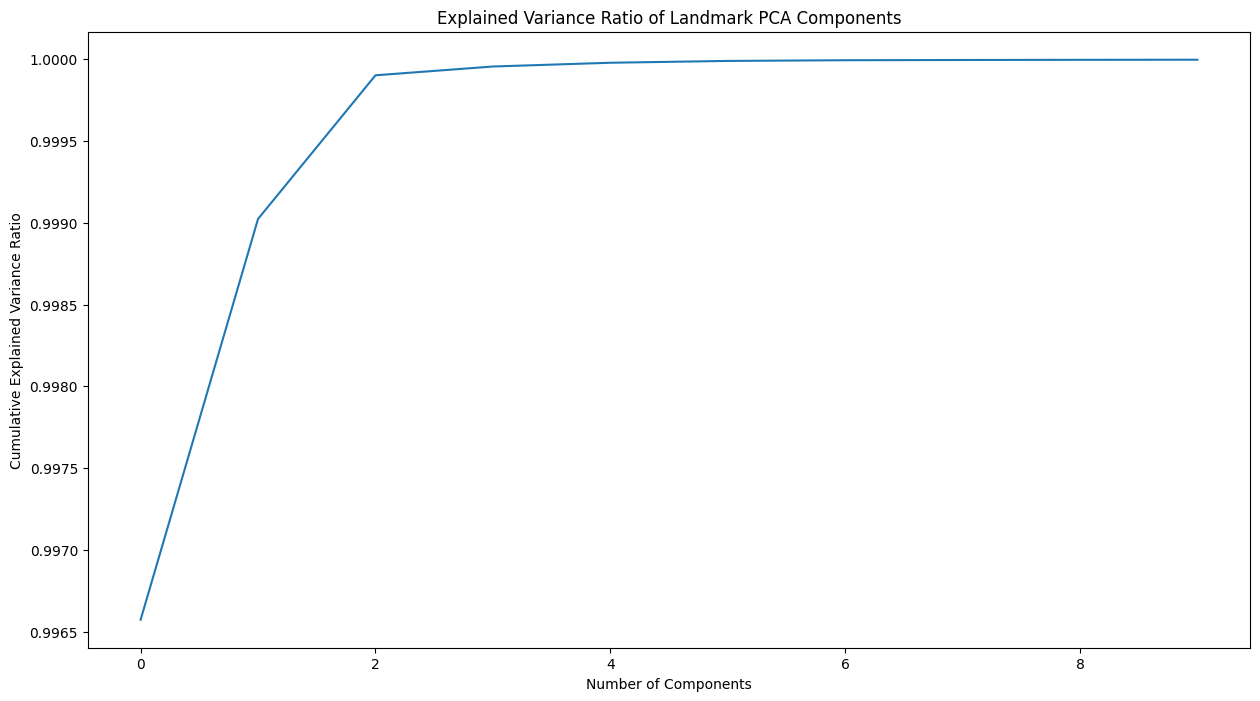

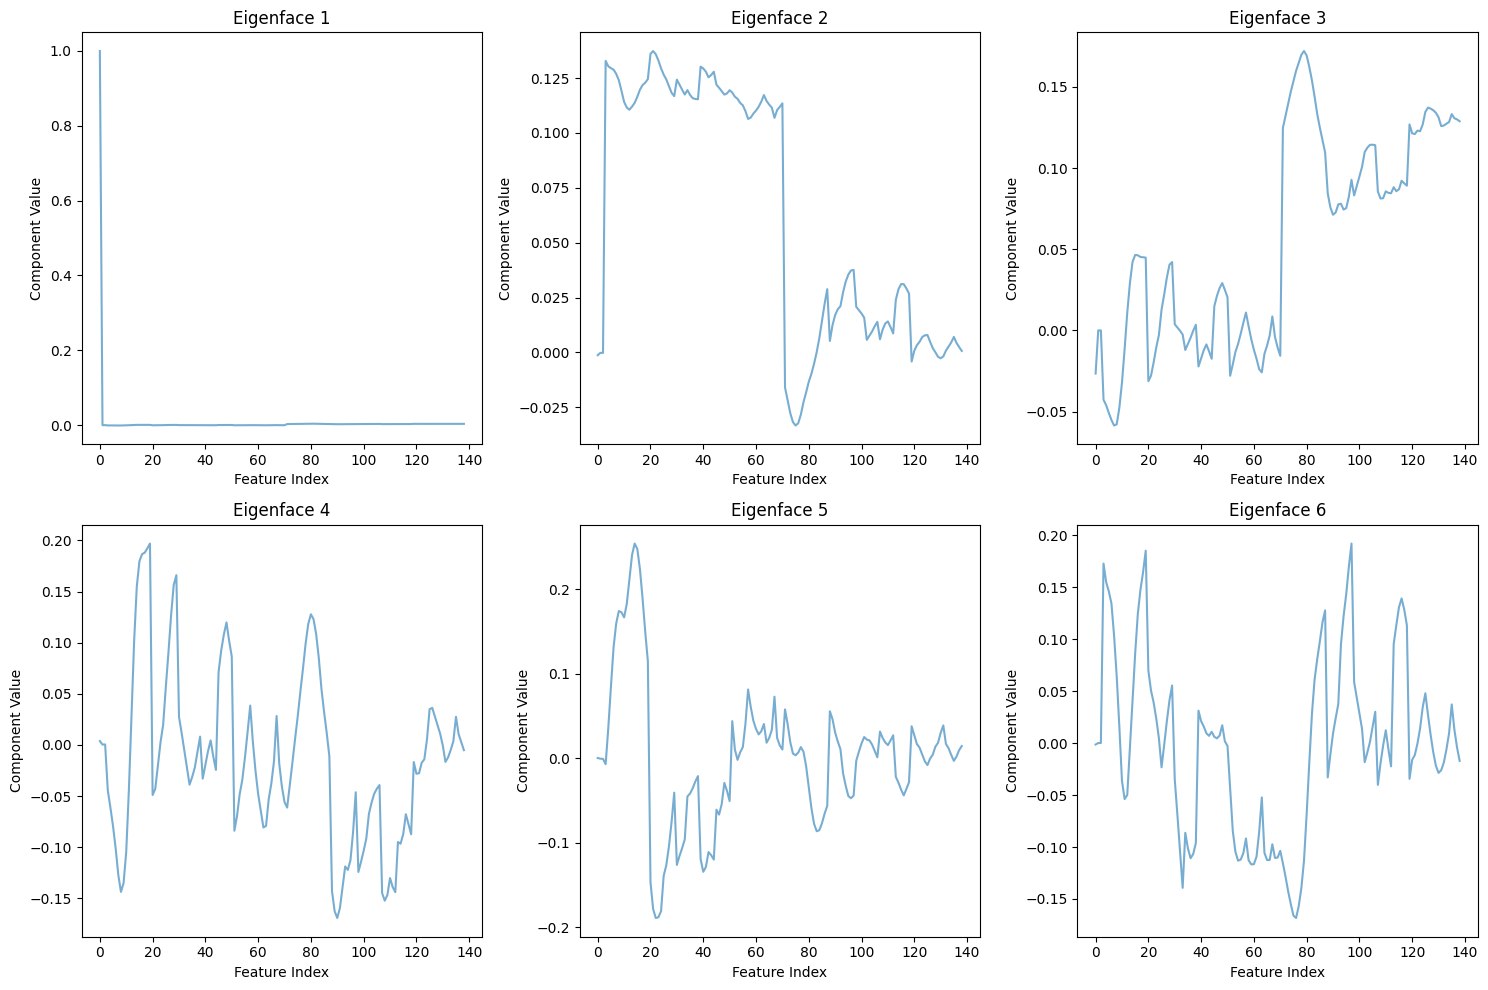

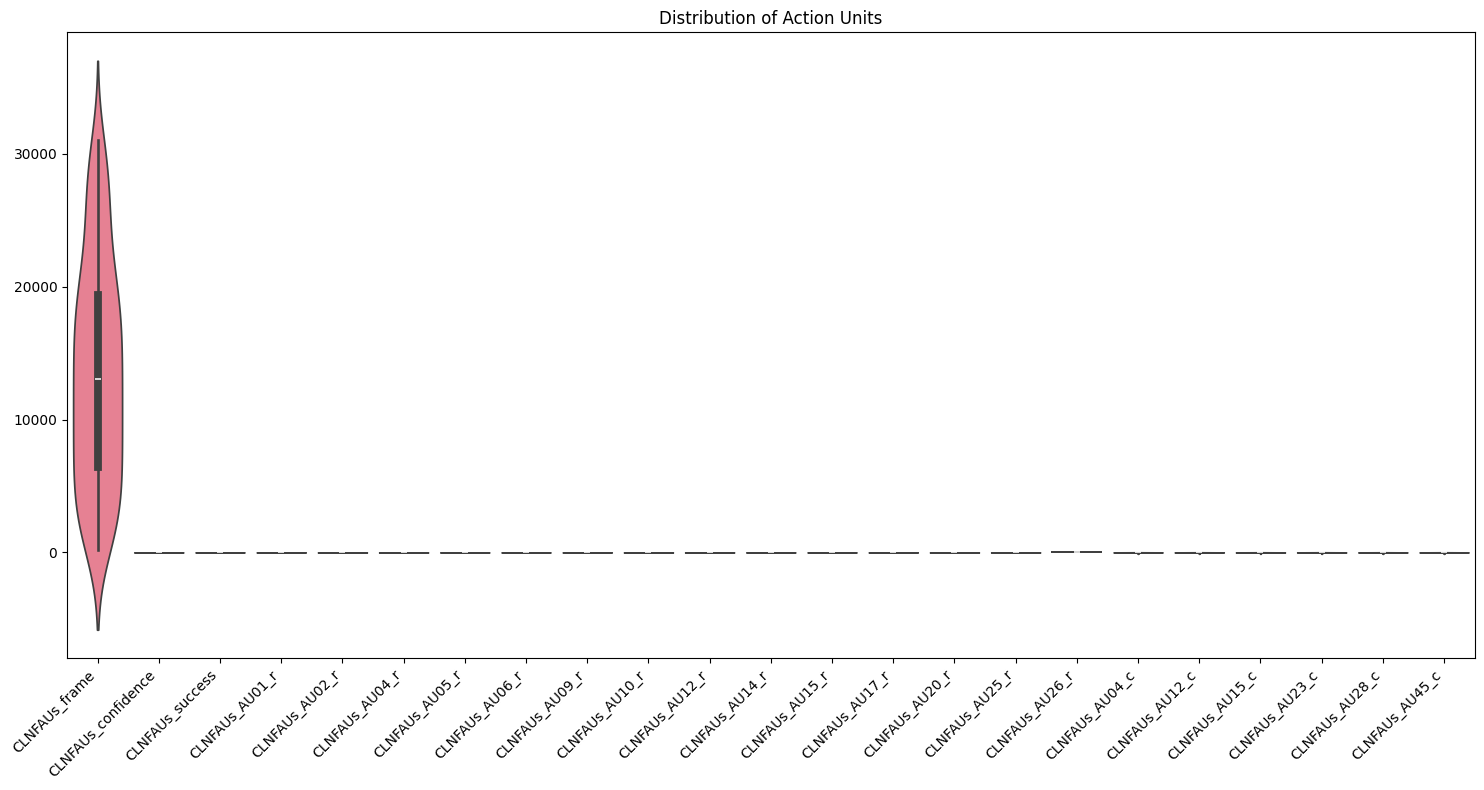

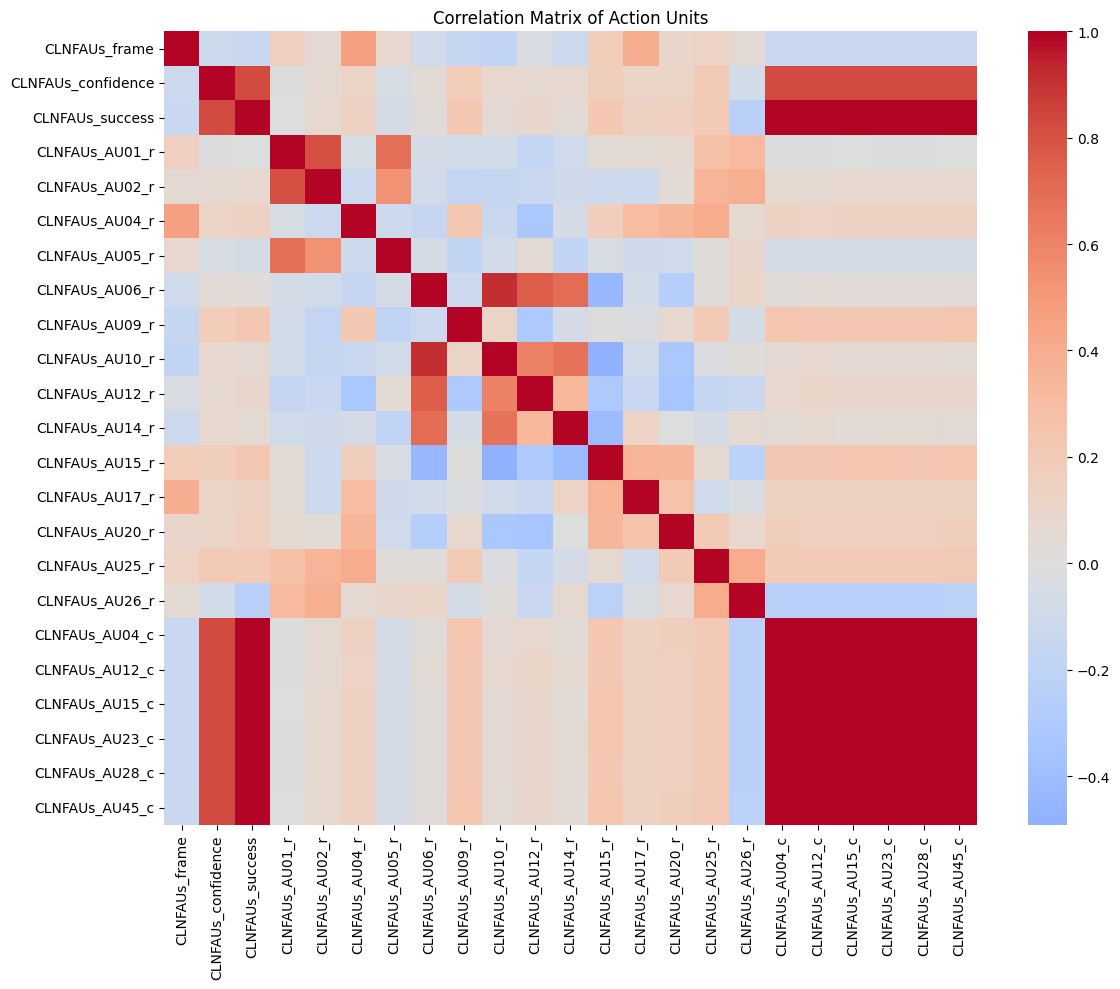

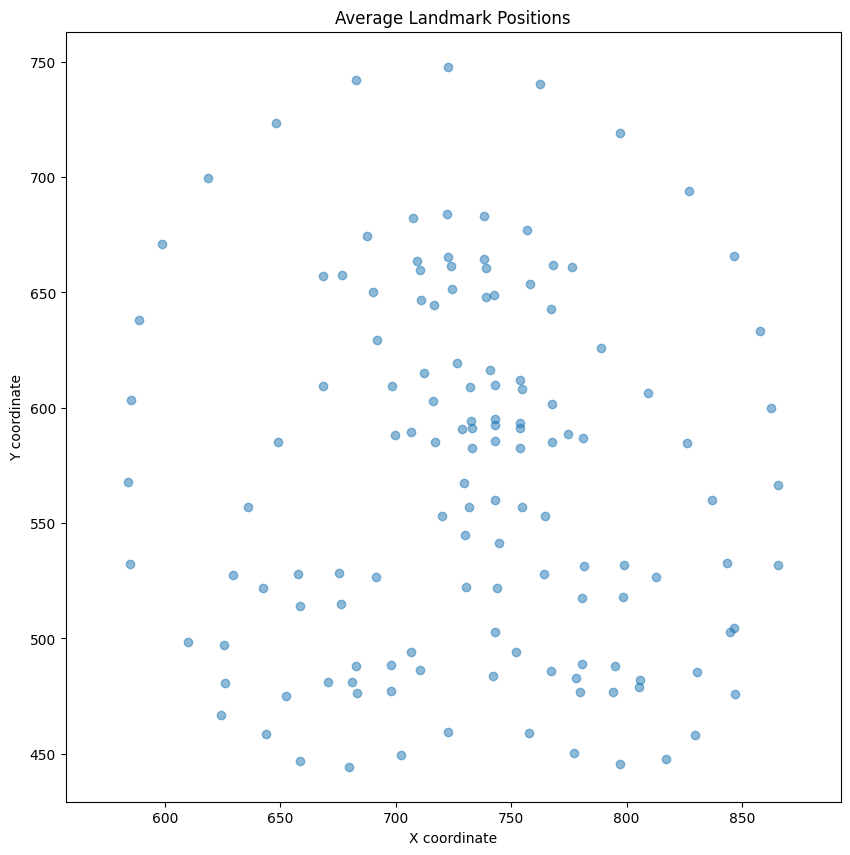

In [3]:
def analyze_landmarks(df: pd.DataFrame) -> None:
    #Analyze facial landmarks using PCA and visualization.
    # Extract landmark features
    landmark_features = [col for col in df.columns if 'CLNFfeatures_' in col]
    landmark_data = df[landmark_features]

    # Perform PCA
    pca = PCA(n_components=10)
    landmark_pca = pca.fit_transform(landmark_data)

    # Plot explained variance ratio
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio of Landmark PCA Components')
    plt.show()

    # Plot eigenfaces -> robust to feature count
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(6):
        if i < len(pca.components_):
            comp = pca.components_[i]
            n_points = comp.shape[0] // 2
            if n_points > 0 and n_points * 2 == comp.shape[0]:
                x = comp[:n_points]
                y = comp[n_points:]
                axes[i].scatter(x, y, alpha=0.6)
                axes[i].set_xlabel('X coordinate')
                axes[i].set_ylabel('Y coordinate')
            else:
                axes[i].plot(comp, alpha=0.6)
                axes[i].set_xlabel('Feature Index')
                axes[i].set_ylabel('Component Value')
            axes[i].set_title(f'Eigenface {i + 1}')

    plt.tight_layout()
    plt.show()


def analyze_action_units(df: pd.DataFrame) -> None:
    #Analyze facial action units using visualization.
    # Extract action unit features
    au_features = [col for col in df.columns if 'CLNFAUs_' in col]

    # Create violin plots
    plt.figure(figsize=FIGURE_SIZE)
    sns.violinplot(data=df[au_features])
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Action Units')
    plt.tight_layout()
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[au_features].corr(), cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Action Units')
    plt.tight_layout()
    plt.show()


def plot_landmark_positions(df: pd.DataFrame) -> None:
    #Plot average landmark positions for each subject.
    landmark_features = [col for col in df.columns if 'CLNFfeatures_' in col]
    mean_landmarks = df.groupby('ID')[landmark_features].mean()

    x_coords = mean_landmarks[[col for col in landmark_features if '_x' in col]].values
    y_coords = mean_landmarks[[col for col in landmark_features if '_y' in col]].values

    plt.figure(figsize=(10, 10))
    plt.scatter(x_coords, y_coords, alpha=0.5)
    plt.title('Average Landmark Positions')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.axis('equal')
    plt.show()


# Perform EDA
analyze_landmarks(df_face)
analyze_action_units(df_face)
plot_landmark_positions(df_face)

## Principal Component Analysis

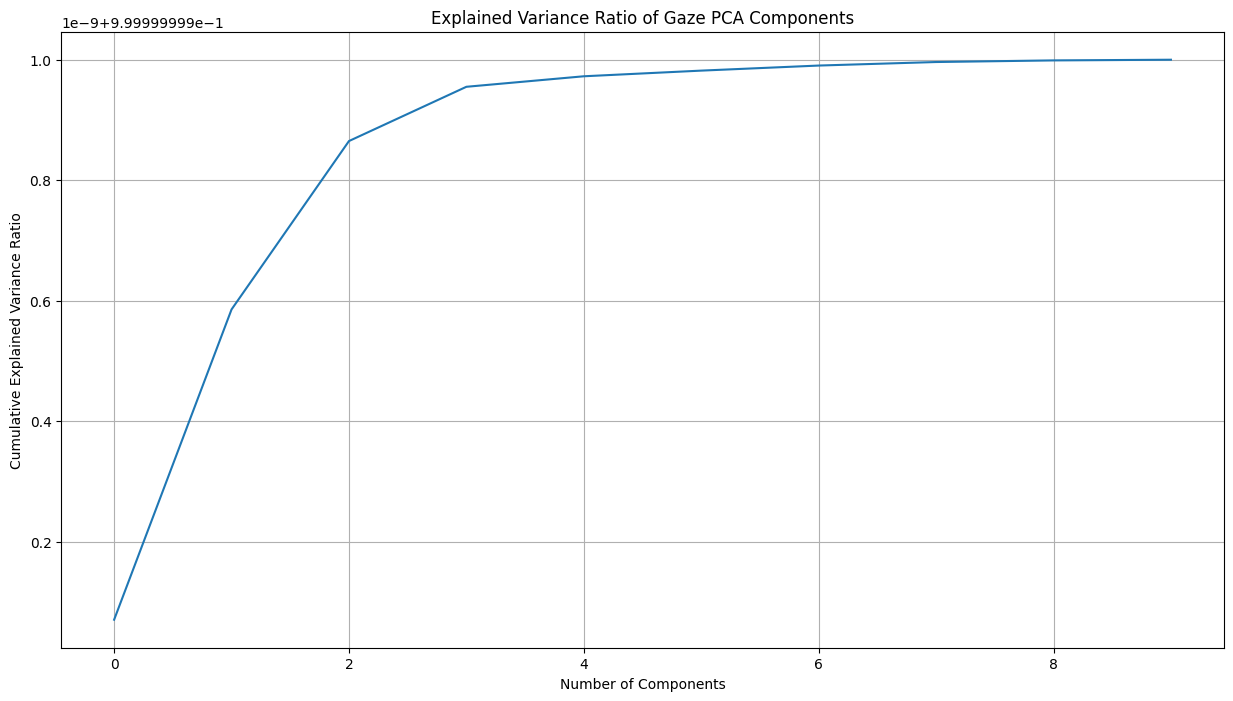


Gaze - Explained variance ratio by component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000
PC10: 0.0000


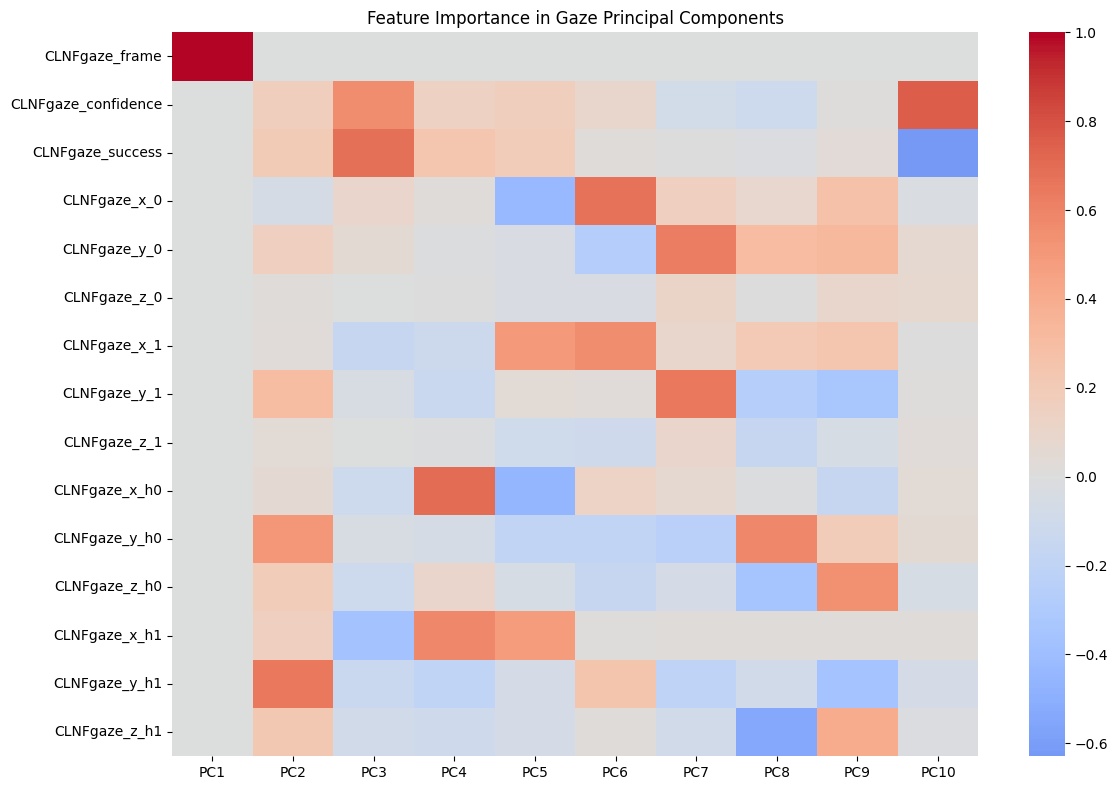

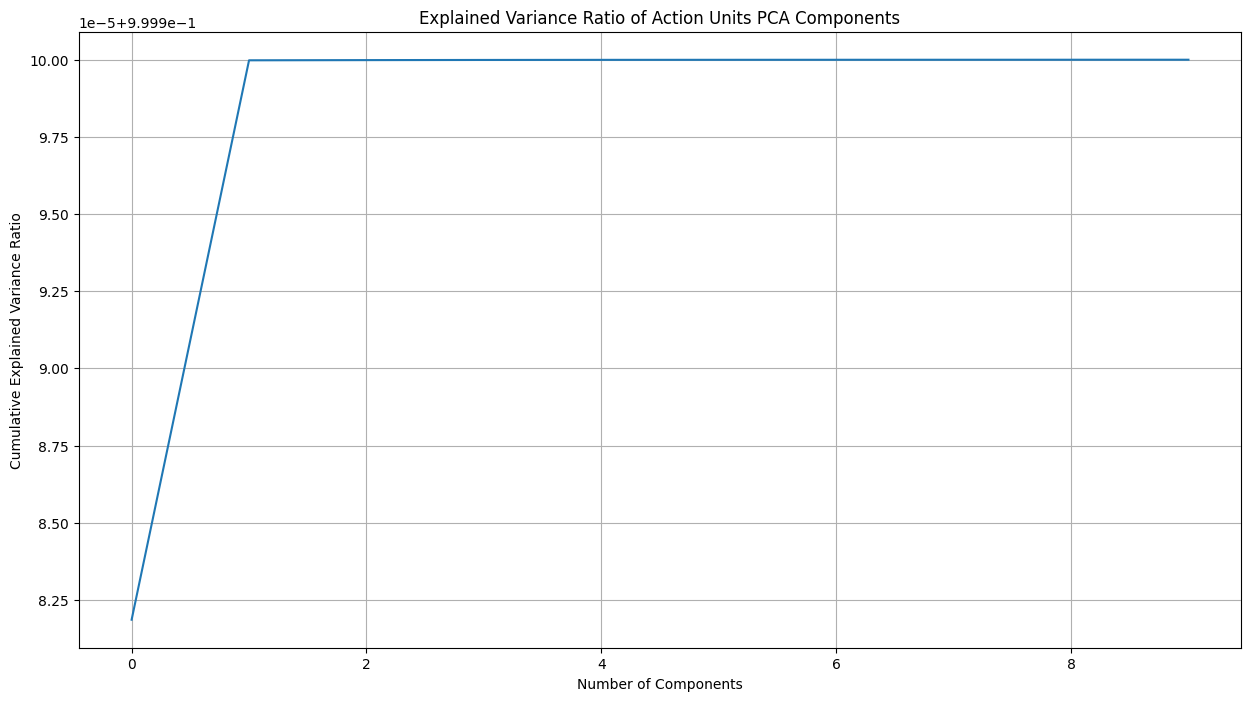


Action Units - Explained variance ratio by component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000
PC10: 0.0000


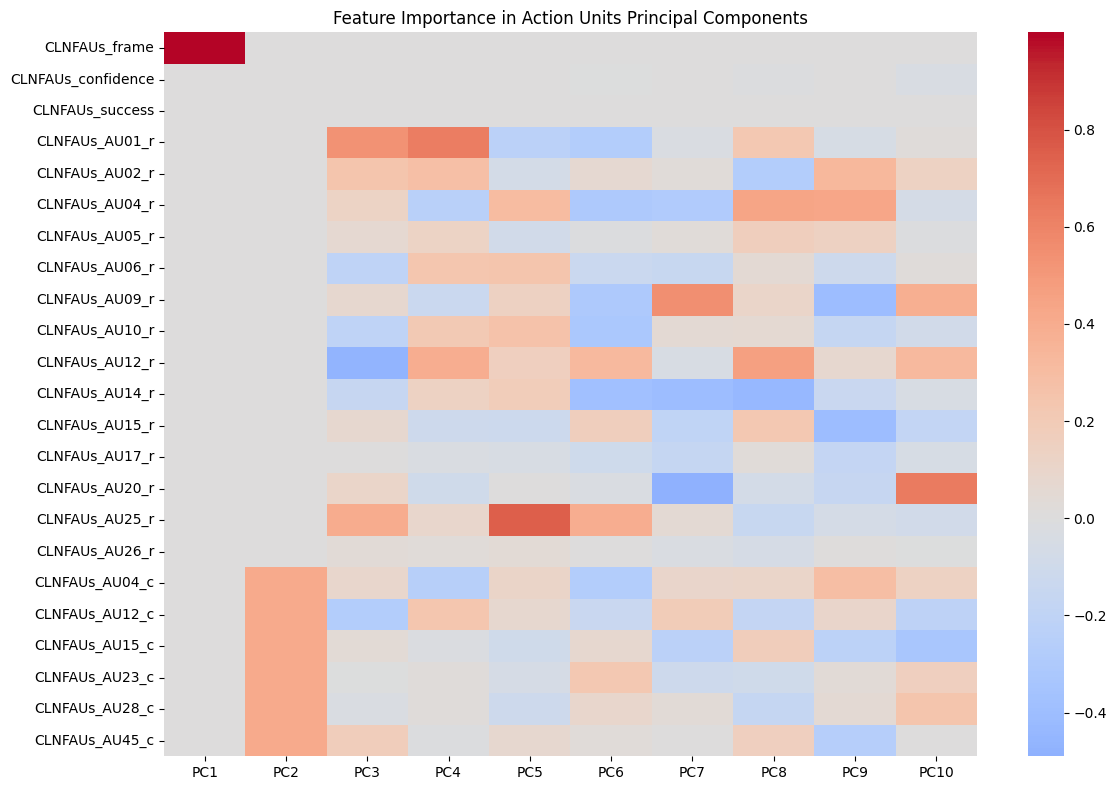

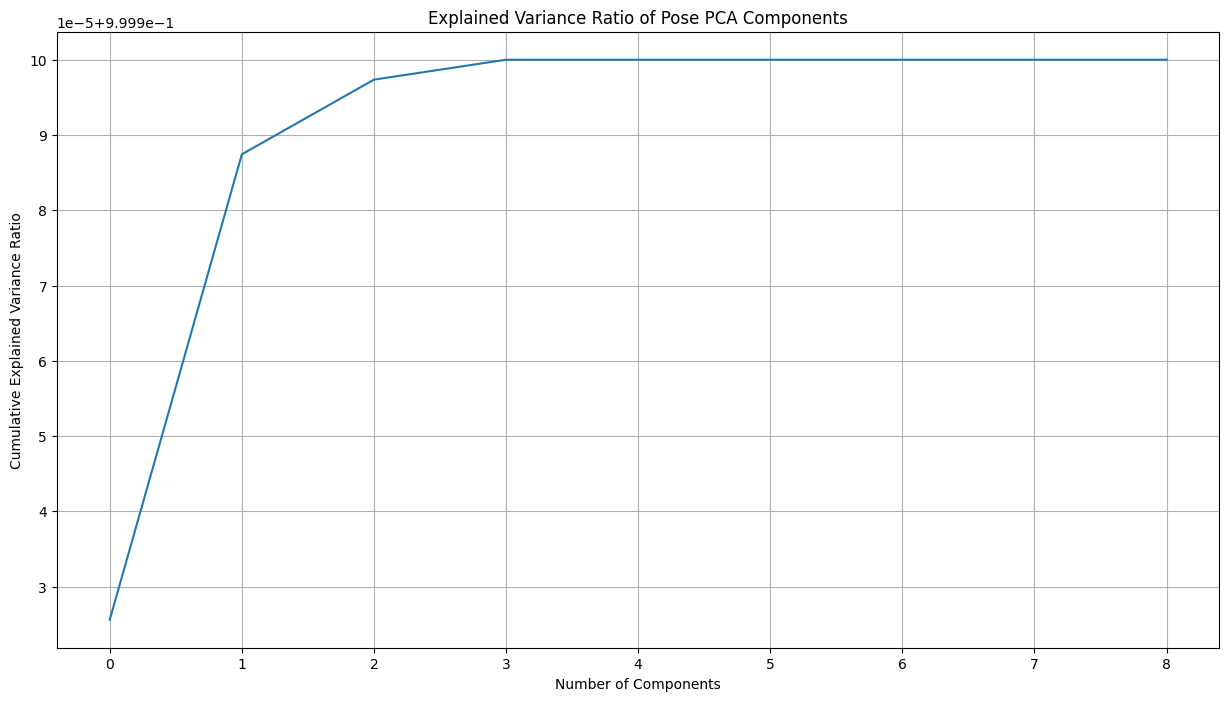


Pose - Explained variance ratio by component:
PC1: 0.9999
PC2: 0.0001
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000


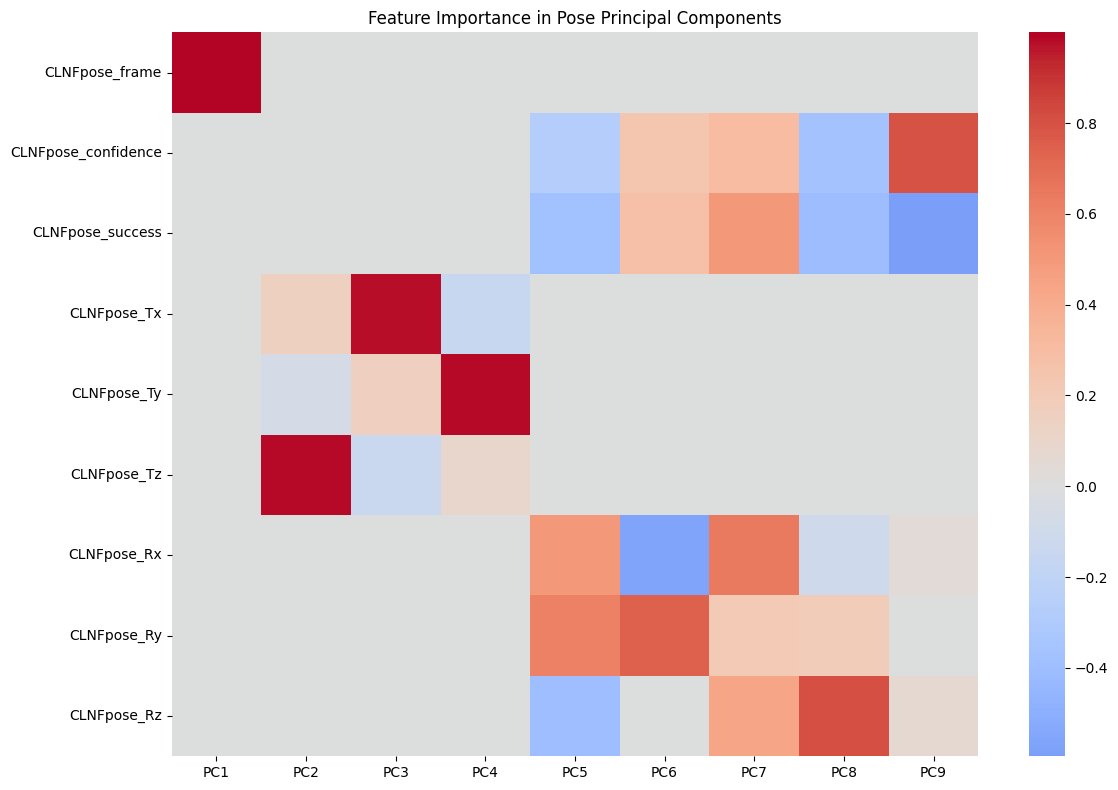

In [4]:
from utils.pca_utils import save_pca_components


def perform_feature_pca(df: pd.DataFrame, n_components: int = 10):
    #Perform PCA on different facial feature types.
    # Extract different feature types
    feature_types = {
        'Gaze': [col for col in df.columns if 'CLNFgaze_' in col],
        'Action Units': [col for col in df.columns if 'CLNFAUs_' in col],
        'Pose': [col for col in df.columns if 'CLNFpose_' in col]
    }

    # Dictionary to store PCA results
    pca_results = {}

    # Perform PCA for each feature type
    for feature_name, features in feature_types.items():
        if not features:
            continue

        # Extract data and perform PCA
        feature_data = df[features]
        pca = PCA(n_components=min(n_components, len(features)))
        feature_pca = pca.fit_transform(feature_data)

        # Determine the most important features for the first principal component
        abs_loadings = np.abs(pca.components_[0])
        sorted_indices = np.argsort(abs_loadings)[::-1]
        feature_names = [features[i] for i in sorted_indices[:min(n_components, len(features))]]

        # For compatibility, return the last computed PCA's importance
        feature_importance = pd.DataFrame(
            pca.components_.T,
            columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
            index=feature_data.columns
        )

        # Store results
        pca_results[feature_name] = {
            'pca': pca,
            'feature_pca': feature_pca,
            'feature_names': feature_names,
            'feature_importance': feature_importance
        }

        # Save PCA components
        save_pca_components(
            pca=pca,
            feature_names=feature_names,
            output_path=f'models/pca_face_{feature_name.lower().replace(" ", "_")}.pkl'
        )

    # Create combined PCA features DataFrame
    pca_df = pd.DataFrame(index=df.index)
    for feature_name, result in pca_results.items():
        pca_df[result['feature_names']] = result['feature_pca']

    return pca_df, pca_results


# Perform PCA
pca_df, pca_results = perform_feature_pca(df_face)

# Plot graphs
for feature_name, result in pca_results.items():
    pca = result['pca']
    # feature_pca = result['feature_pca'] # is this ok?
    feature_importance = result['feature_importance']

    # Plot explained variance ratio
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'Explained Variance Ratio of {feature_name} PCA Components')
    plt.grid(True)
    plt.show()

    # Print variance explained
    print(f"\n{feature_name} - Explained variance ratio by component:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i + 1}: {ratio:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.heatmap(feature_importance, cmap='coolwarm', center=0)
    plt.title(f'Feature Importance in {feature_name} Principal Components')
    plt.tight_layout()
    plt.show()



## Data Splitting

In [5]:
def prepare_data_splits(df_face: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    #Prepare data splits for training, validation, and testing.
    # Merge facial features with depression labels
    df = pd.merge(df_face, df_result, on='ID')

    # Prepare features and target
    X = df.drop(['PHQ_Binary'], axis=1)
    y = df['PHQ_Binary']

    # Create time series split
    tscv = TimeSeriesSplit(n_splits=5)
    train_indices = []
    test_indices = []

    # Get split indices while preserving temporal order
    for train_idx, test_idx in tscv.split(X):
        train_indices.append(train_idx)
        test_indices.append(test_idx)

    # Use the last fold for final train/test split
    X_train = X.iloc[train_indices[-1]]
    X_test = X.iloc[test_indices[-1]]
    y_train = y.iloc[train_indices[-1]]
    y_test = y.iloc[test_indices[-1]]

    # Further split training data into train and validation
    train_size = int(0.75 * len(X_train))
    X_train, X_val = X_train.iloc[:train_size], X_train.iloc[train_size:]
    y_train, y_val = y_train.iloc[:train_size], y_train.iloc[train_size:]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


# Prepare data splits
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data_splits(pca_df, df_result)

## Model Training

  0%|          | 0/72 [00:00<?, ?it/s]/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Validation: 100%|██████████| 2/2 [00:00<00:00, 396.76it/s, loss=0.7628]


Epoch 1/50
Train Loss: 0.5382, Val Loss: 0.7677, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.69it/s, loss=0.7726]


Epoch 2/50
Train Loss: 0.4116, Val Loss: 0.7783, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 133.13it/s, loss=0.7841]


Epoch 3/50
Train Loss: 0.3213, Val Loss: 0.7902, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 445.94it/s, loss=0.7944]


Epoch 4/50
Train Loss: 0.2865, Val Loss: 0.8002, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 200.96it/s, loss=0.8040]


Epoch 5/50
Train Loss: 0.2315, Val Loss: 0.8091, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 463.31it/s, loss=0.8055]


Epoch 6/50
Train Loss: 0.2027, Val Loss: 0.8110, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 387.52it/s, loss=0.8062]


Epoch 7/50
Train Loss: 0.1715, Val Loss: 0.8121, LR: 0.000100


  1%|▏         | 1/72 [00:00<00:55,  1.28it/s]

Epoch 8/50
Train Loss: 0.1776, Val Loss: 0.8150, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 463.31it/s, loss=0.5935]


Epoch 1/50
Train Loss: 0.8904, Val Loss: 0.5927, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 154.77it/s, loss=0.5993]


Epoch 2/50
Train Loss: 0.6614, Val Loss: 0.5972, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 456.00it/s, loss=0.6046]


Epoch 3/50
Train Loss: 0.5952, Val Loss: 0.5999, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 305.48it/s, loss=0.6134]


Epoch 4/50
Train Loss: 0.4378, Val Loss: 0.6053, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 425.88it/s, loss=0.6212]


Epoch 5/50
Train Loss: 0.3700, Val Loss: 0.6092, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.17it/s, loss=0.6187]


Epoch 6/50
Train Loss: 0.3454, Val Loss: 0.6050, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 304.51it/s, loss=0.6182]


Epoch 7/50
Train Loss: 0.2902, Val Loss: 0.6023, LR: 0.000100


  3%|▎         | 2/72 [00:01<00:33,  2.07it/s]

Epoch 8/50
Train Loss: 0.3330, Val Loss: 0.5964, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.33it/s, loss=0.7294]


Epoch 1/50
Train Loss: 0.6654, Val Loss: 0.7284, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 402.74it/s, loss=0.7376]


Epoch 2/50
Train Loss: 0.5150, Val Loss: 0.7354, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.47it/s, loss=0.7439]


Epoch 3/50
Train Loss: 0.3748, Val Loss: 0.7406, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.04it/s, loss=0.7493]


Epoch 4/50
Train Loss: 0.3107, Val Loss: 0.7438, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 384.32it/s, loss=0.7560]


Epoch 5/50
Train Loss: 0.2527, Val Loss: 0.7471, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 203.27it/s, loss=0.7537]


Epoch 6/50
Train Loss: 0.2308, Val Loss: 0.7420, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.51it/s, loss=0.7518]


Epoch 7/50
Train Loss: 0.2157, Val Loss: 0.7370, LR: 0.000100


  4%|▍         | 3/72 [00:01<00:28,  2.45it/s]

Epoch 8/50
Train Loss: 0.2178, Val Loss: 0.7339, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.20it/s, loss=0.6511]


Epoch 1/50
Train Loss: 0.7366, Val Loss: 0.6516, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.16it/s, loss=0.6652]


Epoch 2/50
Train Loss: 0.5544, Val Loss: 0.6651, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 277.55it/s, loss=0.6761]


Epoch 3/50
Train Loss: 0.4550, Val Loss: 0.6756, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.35it/s, loss=0.6866]


Epoch 4/50
Train Loss: 0.3749, Val Loss: 0.6857, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 172.95it/s, loss=0.6970]


Epoch 5/50
Train Loss: 0.2933, Val Loss: 0.6956, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.89it/s, loss=0.6942]


Epoch 6/50
Train Loss: 0.2528, Val Loss: 0.6930, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.27it/s, loss=0.6924]


Epoch 7/50
Train Loss: 0.2442, Val Loss: 0.6913, LR: 0.000100


  6%|▌         | 4/72 [00:01<00:25,  2.72it/s]

Epoch 8/50
Train Loss: 0.2510, Val Loss: 0.6901, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 444.83it/s, loss=0.6149]


Epoch 1/50
Train Loss: 0.8965, Val Loss: 0.6162, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.79it/s, loss=0.6136]


Epoch 2/50
Train Loss: 0.8350, Val Loss: 0.6151, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 544.11it/s, loss=0.6116]


Epoch 3/50
Train Loss: 0.8440, Val Loss: 0.6135, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.70it/s, loss=0.6092]


Epoch 4/50
Train Loss: 0.8069, Val Loss: 0.6115, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 327.08it/s, loss=0.6065]


Epoch 5/50
Train Loss: 0.7801, Val Loss: 0.6093, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 428.71it/s, loss=0.6022]


Epoch 6/50
Train Loss: 0.7828, Val Loss: 0.6057, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 336.53it/s, loss=0.5981]


Epoch 7/50
Train Loss: 0.7429, Val Loss: 0.6022, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 462.51it/s, loss=0.5918]


Epoch 8/50
Train Loss: 0.7818, Val Loss: 0.5970, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 306.46it/s, loss=0.5858]


Epoch 9/50
Train Loss: 0.7242, Val Loss: 0.5919, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 497.25it/s, loss=0.5774]


Epoch 10/50
Train Loss: 0.7379, Val Loss: 0.5845, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.86it/s, loss=0.5674]


Epoch 11/50
Train Loss: 0.7151, Val Loss: 0.5758, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 502.52it/s, loss=0.5537]


Epoch 12/50
Train Loss: 0.7040, Val Loss: 0.5641, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 452.39it/s, loss=0.5396]


Epoch 13/50
Train Loss: 0.6878, Val Loss: 0.5517, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 210.29it/s, loss=0.5235]


Epoch 14/50
Train Loss: 0.6624, Val Loss: 0.5377, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 487.82it/s, loss=0.5008]


Epoch 15/50
Train Loss: 0.6807, Val Loss: 0.5187, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.39it/s, loss=0.4751]


Epoch 16/50
Train Loss: 0.6463, Val Loss: 0.4971, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 282.41it/s, loss=0.4514]


Epoch 17/50
Train Loss: 0.6492, Val Loss: 0.4760, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 491.48it/s, loss=0.4348]


Epoch 18/50
Train Loss: 0.6326, Val Loss: 0.4614, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 233.18it/s, loss=0.4251]


Epoch 19/50
Train Loss: 0.5994, Val Loss: 0.4545, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 433.30it/s, loss=0.3918]


Epoch 20/50
Train Loss: 0.5900, Val Loss: 0.4255, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 351.55it/s, loss=0.3663]


Epoch 21/50
Train Loss: 0.5734, Val Loss: 0.4031, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 488.16it/s, loss=0.3549]


Epoch 22/50
Train Loss: 0.5880, Val Loss: 0.3918, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.45it/s, loss=0.3466]


Epoch 23/50
Train Loss: 0.5610, Val Loss: 0.3846, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 121.68it/s, loss=0.3390]


Epoch 24/50
Train Loss: 0.5555, Val Loss: 0.3772, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 487.45it/s, loss=0.3325]


Epoch 25/50
Train Loss: 0.5291, Val Loss: 0.3698, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 477.58it/s, loss=0.3364]


Epoch 26/50
Train Loss: 0.5279, Val Loss: 0.3724, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 477.90it/s, loss=0.3439]


Epoch 27/50
Train Loss: 0.5019, Val Loss: 0.3799, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 527.68it/s, loss=0.3262]


Epoch 28/50
Train Loss: 0.5160, Val Loss: 0.3612, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 262.71it/s, loss=0.3481]


Epoch 29/50
Train Loss: 0.4619, Val Loss: 0.3790, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 476.52it/s, loss=0.3572]


Epoch 30/50
Train Loss: 0.4480, Val Loss: 0.3875, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 199.92it/s, loss=0.3476]


Epoch 31/50
Train Loss: 0.4984, Val Loss: 0.3769, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 461.27it/s, loss=0.3377]


Epoch 32/50
Train Loss: 0.4556, Val Loss: 0.3646, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 124.08it/s, loss=0.3631]


Epoch 33/50
Train Loss: 0.4277, Val Loss: 0.3862, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.72it/s, loss=0.3428]


Epoch 34/50
Train Loss: 0.4565, Val Loss: 0.3686, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 102.19it/s, loss=0.3288]


Epoch 35/50
Train Loss: 0.4365, Val Loss: 0.3554, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.79it/s, loss=0.3417]


Epoch 36/50
Train Loss: 0.4095, Val Loss: 0.3671, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 350.26it/s, loss=0.3304]


Epoch 37/50
Train Loss: 0.4486, Val Loss: 0.3575, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.54it/s, loss=0.3227]


Epoch 38/50
Train Loss: 0.4564, Val Loss: 0.3512, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 435.52it/s, loss=0.3477]


Epoch 39/50
Train Loss: 0.4197, Val Loss: 0.3745, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 219.59it/s, loss=0.3324]


Epoch 40/50
Train Loss: 0.4506, Val Loss: 0.3610, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 460.94it/s, loss=0.3390]


Epoch 41/50
Train Loss: 0.4346, Val Loss: 0.3671, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 323.21it/s, loss=0.3672]


Epoch 42/50
Train Loss: 0.4303, Val Loss: 0.3927, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 482.77it/s, loss=0.3690]


Epoch 43/50
Train Loss: 0.4261, Val Loss: 0.3941, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 327.42it/s, loss=0.3499]


Epoch 44/50
Train Loss: 0.4406, Val Loss: 0.3758, LR: 0.000001


  7%|▋         | 5/72 [00:03<00:53,  1.25it/s]

Epoch 45/50
Train Loss: 0.4204, Val Loss: 0.3667, LR: 0.000001
Early stopping triggered at epoch 45


Validation: 100%|██████████| 2/2 [00:00<00:00, 363.79it/s, loss=0.6511]


Epoch 1/50
Train Loss: 0.7841, Val Loss: 0.6509, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 227.15it/s, loss=0.6462]


Epoch 2/50
Train Loss: 0.7605, Val Loss: 0.6450, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 398.07it/s, loss=0.6402]


Epoch 3/50
Train Loss: 0.7260, Val Loss: 0.6379, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 443.30it/s, loss=0.6332]


Epoch 4/50
Train Loss: 0.7251, Val Loss: 0.6294, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.39it/s, loss=0.6239]


Epoch 5/50
Train Loss: 0.6979, Val Loss: 0.6188, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 341.53it/s, loss=0.6133]


Epoch 6/50
Train Loss: 0.6918, Val Loss: 0.6066, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.44it/s, loss=0.6009]


Epoch 7/50
Train Loss: 0.6567, Val Loss: 0.5925, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 331.34it/s, loss=0.5849]


Epoch 8/50
Train Loss: 0.6681, Val Loss: 0.5745, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 521.23it/s, loss=0.5663]


Epoch 9/50
Train Loss: 0.6499, Val Loss: 0.5534, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 343.58it/s, loss=0.5451]


Epoch 10/50
Train Loss: 0.6553, Val Loss: 0.5293, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 496.25it/s, loss=0.5192]


Epoch 11/50
Train Loss: 0.6174, Val Loss: 0.5005, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 435.25it/s, loss=0.4932]


Epoch 12/50
Train Loss: 0.6117, Val Loss: 0.4716, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 270.23it/s, loss=0.4603]


Epoch 13/50
Train Loss: 0.6030, Val Loss: 0.4360, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 514.67it/s, loss=0.4261]


Epoch 14/50
Train Loss: 0.5716, Val Loss: 0.3992, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 468.17it/s, loss=0.3905]


Epoch 15/50
Train Loss: 0.5867, Val Loss: 0.3617, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 474.74it/s, loss=0.3706]


Epoch 16/50
Train Loss: 0.5228, Val Loss: 0.3414, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 446.01it/s, loss=0.3462]


Epoch 17/50
Train Loss: 0.5140, Val Loss: 0.3170, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.06it/s, loss=0.3235]


Epoch 18/50
Train Loss: 0.5198, Val Loss: 0.2961, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 470.37it/s, loss=0.2913]


Epoch 19/50
Train Loss: 0.5055, Val Loss: 0.2639, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 460.94it/s, loss=0.2817]


Epoch 20/50
Train Loss: 0.4788, Val Loss: 0.2563, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 461.14it/s, loss=0.2672]


Epoch 21/50
Train Loss: 0.4720, Val Loss: 0.2423, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 470.48it/s, loss=0.2606]


Epoch 22/50
Train Loss: 0.4747, Val Loss: 0.2358, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 510.32it/s, loss=0.2390]


Epoch 23/50
Train Loss: 0.4947, Val Loss: 0.2150, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 384.20it/s, loss=0.2286]


Epoch 24/50
Train Loss: 0.4770, Val Loss: 0.2057, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.68it/s, loss=0.2227]


Epoch 25/50
Train Loss: 0.4569, Val Loss: 0.2011, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 270.49it/s, loss=0.2155]


Epoch 26/50
Train Loss: 0.4500, Val Loss: 0.1940, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.22it/s, loss=0.2095]


Epoch 27/50
Train Loss: 0.4550, Val Loss: 0.1882, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 469.69it/s, loss=0.2486]


Epoch 28/50
Train Loss: 0.4044, Val Loss: 0.2302, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.54it/s, loss=0.2364]


Epoch 29/50
Train Loss: 0.4002, Val Loss: 0.2160, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 484.75it/s, loss=0.2274]


Epoch 30/50
Train Loss: 0.4477, Val Loss: 0.2074, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.62it/s, loss=0.2225]


Epoch 31/50
Train Loss: 0.4055, Val Loss: 0.2005, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 490.30it/s, loss=0.2192]


Epoch 32/50
Train Loss: 0.3917, Val Loss: 0.1970, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 257.34it/s, loss=0.2263]


Epoch 33/50
Train Loss: 0.3831, Val Loss: 0.2055, LR: 0.000010


  8%|▊         | 6/72 [00:04<01:00,  1.09it/s]

Epoch 34/50
Train Loss: 0.3799, Val Loss: 0.2130, LR: 0.000010
Early stopping triggered at epoch 34


Validation: 100%|██████████| 2/2 [00:00<00:00, 224.57it/s, loss=0.7735]


Epoch 1/50
Train Loss: 0.5854, Val Loss: 0.7741, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.39it/s, loss=0.7788]


Epoch 2/50
Train Loss: 0.5784, Val Loss: 0.7793, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.40it/s, loss=0.7831]


Epoch 3/50
Train Loss: 0.5450, Val Loss: 0.7837, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.30it/s, loss=0.7874]


Epoch 4/50
Train Loss: 0.5376, Val Loss: 0.7881, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.79it/s, loss=0.7910]


Epoch 5/50
Train Loss: 0.5278, Val Loss: 0.7918, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.09it/s, loss=0.7937]


Epoch 6/50
Train Loss: 0.5039, Val Loss: 0.7946, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 480.78it/s, loss=0.7961]


Epoch 7/50
Train Loss: 0.5151, Val Loss: 0.7971, LR: 0.000010


 10%|▉         | 7/72 [00:04<00:46,  1.39it/s]

Epoch 8/50
Train Loss: 0.5060, Val Loss: 0.7991, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.67it/s, loss=0.7214]


Epoch 1/50
Train Loss: 0.9029, Val Loss: 0.7210, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.81it/s, loss=0.7223]


Epoch 2/50
Train Loss: 0.8798, Val Loss: 0.7219, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 205.38it/s, loss=0.7225]


Epoch 3/50
Train Loss: 0.8321, Val Loss: 0.7224, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 480.78it/s, loss=0.7223]


Epoch 4/50
Train Loss: 0.8269, Val Loss: 0.7226, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.25it/s, loss=0.7212]


Epoch 5/50
Train Loss: 0.8215, Val Loss: 0.7221, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.38it/s, loss=0.7191]


Epoch 6/50
Train Loss: 0.7817, Val Loss: 0.7208, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 411.35it/s, loss=0.7165]


Epoch 7/50
Train Loss: 0.8154, Val Loss: 0.7193, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.41it/s, loss=0.7138]


Epoch 8/50
Train Loss: 0.7785, Val Loss: 0.7176, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 416.23it/s, loss=0.7105]


Epoch 9/50
Train Loss: 0.8027, Val Loss: 0.7153, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 192.32it/s, loss=0.7071]


Epoch 10/50
Train Loss: 0.7478, Val Loss: 0.7132, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.74it/s, loss=0.7022]


Epoch 11/50
Train Loss: 0.7898, Val Loss: 0.7098, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.69it/s, loss=0.6962]


Epoch 12/50
Train Loss: 0.7900, Val Loss: 0.7057, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 435.25it/s, loss=0.6886]


Epoch 13/50
Train Loss: 0.7491, Val Loss: 0.7005, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.93it/s, loss=0.6807]


Epoch 14/50
Train Loss: 0.7506, Val Loss: 0.6955, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 424.70it/s, loss=0.6714]


Epoch 15/50
Train Loss: 0.7411, Val Loss: 0.6897, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 423.82it/s, loss=0.6579]


Epoch 16/50
Train Loss: 0.7757, Val Loss: 0.6803, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 309.98it/s, loss=0.6440]


Epoch 17/50
Train Loss: 0.7499, Val Loss: 0.6714, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.39it/s, loss=0.6260]


Epoch 18/50
Train Loss: 0.7485, Val Loss: 0.6586, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.30it/s, loss=0.6044]


Epoch 19/50
Train Loss: 0.7566, Val Loss: 0.6433, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 425.97it/s, loss=0.5784]


Epoch 20/50
Train Loss: 0.7721, Val Loss: 0.6266, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 164.54it/s, loss=0.5502]


Epoch 21/50
Train Loss: 0.7666, Val Loss: 0.6067, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.71it/s, loss=0.5183]


Epoch 22/50
Train Loss: 0.7621, Val Loss: 0.5830, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 429.08it/s, loss=0.4876]


Epoch 23/50
Train Loss: 0.7784, Val Loss: 0.5613, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 319.27it/s, loss=0.4571]


Epoch 24/50
Train Loss: 0.7853, Val Loss: 0.5382, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 439.54it/s, loss=0.4290]


Epoch 25/50
Train Loss: 0.7509, Val Loss: 0.5157, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 429.28it/s, loss=0.4064]


Epoch 26/50
Train Loss: 0.7377, Val Loss: 0.5002, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 440.72it/s, loss=0.3903]


Epoch 27/50
Train Loss: 0.7626, Val Loss: 0.4869, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 474.07it/s, loss=0.3726]


Epoch 28/50
Train Loss: 0.7239, Val Loss: 0.4735, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 467.75it/s, loss=0.3541]


Epoch 29/50
Train Loss: 0.7376, Val Loss: 0.4563, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 377.51it/s, loss=0.3492]


Epoch 30/50
Train Loss: 0.7447, Val Loss: 0.4534, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.45it/s, loss=0.3320]


Epoch 31/50
Train Loss: 0.7603, Val Loss: 0.4390, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.71it/s, loss=0.3284]


Epoch 32/50
Train Loss: 0.7341, Val Loss: 0.4369, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 420.33it/s, loss=0.3215]


Epoch 33/50
Train Loss: 0.7245, Val Loss: 0.4282, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.04it/s, loss=0.3158]


Epoch 34/50
Train Loss: 0.7255, Val Loss: 0.4225, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 405.11it/s, loss=0.3095]


Epoch 35/50
Train Loss: 0.7531, Val Loss: 0.4171, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 190.55it/s, loss=0.3074]


Epoch 36/50
Train Loss: 0.7169, Val Loss: 0.4161, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.24it/s, loss=0.3058]


Epoch 37/50
Train Loss: 0.7654, Val Loss: 0.4142, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 296.69it/s, loss=0.3040]


Epoch 38/50
Train Loss: 0.7736, Val Loss: 0.4117, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 463.31it/s, loss=0.3103]


Epoch 39/50
Train Loss: 0.7088, Val Loss: 0.4176, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 336.15it/s, loss=0.3122]


Epoch 40/50
Train Loss: 0.7371, Val Loss: 0.4196, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.21it/s, loss=0.3305]


Epoch 41/50
Train Loss: 0.7174, Val Loss: 0.4387, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.41it/s, loss=0.3230]


Epoch 42/50
Train Loss: 0.7245, Val Loss: 0.4286, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 118.85it/s, loss=0.3245]


Epoch 43/50
Train Loss: 0.7175, Val Loss: 0.4308, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 424.83it/s, loss=0.3169]


Epoch 44/50
Train Loss: 0.6956, Val Loss: 0.4256, LR: 0.000001


 11%|█         | 8/72 [00:06<01:08,  1.06s/it]

Epoch 45/50
Train Loss: 0.7300, Val Loss: 0.4165, LR: 0.000001
Early stopping triggered at epoch 45


Validation: 100%|██████████| 2/2 [00:00<00:00, 453.10it/s, loss=0.7616]


Epoch 1/50
Train Loss: 0.4780, Val Loss: 0.7641, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 366.44it/s, loss=0.7657]


Epoch 2/50
Train Loss: 0.2643, Val Loss: 0.7633, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.03it/s, loss=0.7677]


Epoch 3/50
Train Loss: 0.1695, Val Loss: 0.7599, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.00it/s, loss=0.7683]


Epoch 4/50
Train Loss: 0.1067, Val Loss: 0.7556, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 445.42it/s, loss=0.7698]


Epoch 5/50
Train Loss: 0.0875, Val Loss: 0.7534, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.67it/s, loss=0.7688]


Epoch 6/50
Train Loss: 0.0598, Val Loss: 0.7484, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 160.62it/s, loss=0.7663]


Epoch 7/50
Train Loss: 0.0440, Val Loss: 0.7422, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.45it/s, loss=0.7755]


Epoch 8/50
Train Loss: 0.0336, Val Loss: 0.7444, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.34it/s, loss=0.7747]


Epoch 9/50
Train Loss: 0.0356, Val Loss: 0.7353, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.09it/s, loss=0.7671]


Epoch 10/50
Train Loss: 0.0194, Val Loss: 0.7192, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.94it/s, loss=0.7555]


Epoch 11/50
Train Loss: 0.0195, Val Loss: 0.6996, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 169.95it/s, loss=0.7454]


Epoch 12/50
Train Loss: 0.0162, Val Loss: 0.6851, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 423.20it/s, loss=0.7102]


Epoch 13/50
Train Loss: 0.0183, Val Loss: 0.6465, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.22it/s, loss=0.7030]


Epoch 14/50
Train Loss: 0.0163, Val Loss: 0.6310, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 144.14it/s, loss=0.7009]


Epoch 15/50
Train Loss: 0.0206, Val Loss: 0.6253, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 321.44it/s, loss=0.6489]


Epoch 16/50
Train Loss: 0.0110, Val Loss: 0.5755, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 272.77it/s, loss=0.5985]


Epoch 17/50
Train Loss: 0.0107, Val Loss: 0.5262, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.30it/s, loss=0.5583]


Epoch 18/50
Train Loss: 0.0137, Val Loss: 0.4881, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 293.73it/s, loss=0.5362]


Epoch 19/50
Train Loss: 0.0145, Val Loss: 0.4691, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.47it/s, loss=0.5141]


Epoch 20/50
Train Loss: 0.0081, Val Loss: 0.4518, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 439.47it/s, loss=0.4765]


Epoch 21/50
Train Loss: 0.0090, Val Loss: 0.4291, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 357.45it/s, loss=0.4612]


Epoch 22/50
Train Loss: 0.0067, Val Loss: 0.4195, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 414.31it/s, loss=0.4576]


Epoch 23/50
Train Loss: 0.0070, Val Loss: 0.4190, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 252.05it/s, loss=0.4535]


Epoch 24/50
Train Loss: 0.0088, Val Loss: 0.4190, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 414.85it/s, loss=0.4874]


Epoch 25/50
Train Loss: 0.0062, Val Loss: 0.4454, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.92it/s, loss=0.5164]


Epoch 26/50
Train Loss: 0.0064, Val Loss: 0.4706, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 193.05it/s, loss=0.5280]


Epoch 27/50
Train Loss: 0.0063, Val Loss: 0.4806, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.60it/s, loss=0.5846]


Epoch 28/50
Train Loss: 0.0050, Val Loss: 0.5315, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 356.25it/s, loss=0.5951]


Epoch 29/50
Train Loss: 0.0070, Val Loss: 0.5409, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.99it/s, loss=0.5797]


Epoch 30/50
Train Loss: 0.0052, Val Loss: 0.5254, LR: 0.000100


 12%|█▎        | 9/72 [00:07<01:12,  1.16s/it]

Epoch 31/50
Train Loss: 0.0045, Val Loss: 0.5592, LR: 0.000100
Early stopping triggered at epoch 31


Validation: 100%|██████████| 2/2 [00:00<00:00, 188.57it/s, loss=0.7716]


Epoch 1/50
Train Loss: 0.4854, Val Loss: 0.7712, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.87it/s, loss=0.7867]


Epoch 2/50
Train Loss: 0.2672, Val Loss: 0.7827, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.85it/s, loss=0.7985]


Epoch 3/50
Train Loss: 0.1837, Val Loss: 0.7898, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 461.27it/s, loss=0.8204]


Epoch 4/50
Train Loss: 0.1178, Val Loss: 0.8074, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.98it/s, loss=0.8427]


Epoch 5/50
Train Loss: 0.0879, Val Loss: 0.8240, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 440.83it/s, loss=0.8516]


Epoch 6/50
Train Loss: 0.0642, Val Loss: 0.8293, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 154.12it/s, loss=0.8600]


Epoch 7/50
Train Loss: 0.0727, Val Loss: 0.8331, LR: 0.000100


 14%|█▍        | 10/72 [00:08<00:55,  1.11it/s]

Epoch 8/50
Train Loss: 0.0596, Val Loss: 0.8416, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 142.69it/s, loss=0.6624]


Epoch 1/50
Train Loss: 0.7715, Val Loss: 0.6624, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 405.44it/s, loss=0.6732]


Epoch 2/50
Train Loss: 0.5199, Val Loss: 0.6731, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 382.76it/s, loss=0.6824]


Epoch 3/50
Train Loss: 0.3408, Val Loss: 0.6815, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 166.61it/s, loss=0.6933]


Epoch 4/50
Train Loss: 0.2439, Val Loss: 0.6901, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 405.17it/s, loss=0.7021]


Epoch 5/50
Train Loss: 0.1694, Val Loss: 0.6972, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 379.35it/s, loss=0.6977]


Epoch 6/50
Train Loss: 0.1254, Val Loss: 0.6916, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 260.31it/s, loss=0.6940]


Epoch 7/50
Train Loss: 0.1220, Val Loss: 0.6861, LR: 0.000100


 15%|█▌        | 11/72 [00:08<00:46,  1.32it/s]

Epoch 8/50
Train Loss: 0.1166, Val Loss: 0.6807, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 379.44it/s, loss=0.7122]


Epoch 1/50
Train Loss: 0.5013, Val Loss: 0.7113, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 181.00it/s, loss=0.7242]


Epoch 2/50
Train Loss: 0.2846, Val Loss: 0.7226, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.68it/s, loss=0.7356]


Epoch 3/50
Train Loss: 0.1860, Val Loss: 0.7337, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.74it/s, loss=0.7466]


Epoch 4/50
Train Loss: 0.1220, Val Loss: 0.7439, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.17it/s, loss=0.7589]


Epoch 5/50
Train Loss: 0.0839, Val Loss: 0.7544, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 374.24it/s, loss=0.7608]


Epoch 6/50
Train Loss: 0.0833, Val Loss: 0.7553, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 262.30it/s, loss=0.7630]


Epoch 7/50
Train Loss: 0.0662, Val Loss: 0.7565, LR: 0.000100


 17%|█▋        | 12/72 [00:09<00:39,  1.52it/s]

Epoch 8/50
Train Loss: 0.0691, Val Loss: 0.7571, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.94it/s, loss=0.6824]


Epoch 1/50
Train Loss: 0.7912, Val Loss: 0.6889, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 199.38it/s, loss=0.6780]


Epoch 2/50
Train Loss: 0.7056, Val Loss: 0.6856, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.55it/s, loss=0.6735]


Epoch 3/50
Train Loss: 0.6946, Val Loss: 0.6826, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 396.76it/s, loss=0.6692]


Epoch 4/50
Train Loss: 0.6379, Val Loss: 0.6797, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 262.16it/s, loss=0.6633]


Epoch 5/50
Train Loss: 0.6194, Val Loss: 0.6758, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 405.27it/s, loss=0.6561]


Epoch 6/50
Train Loss: 0.5719, Val Loss: 0.6708, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 333.84it/s, loss=0.6478]


Epoch 7/50
Train Loss: 0.5127, Val Loss: 0.6653, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.73it/s, loss=0.6370]


Epoch 8/50
Train Loss: 0.5317, Val Loss: 0.6576, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 414.42it/s, loss=0.6217]


Epoch 9/50
Train Loss: 0.4886, Val Loss: 0.6463, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 323.36it/s, loss=0.6028]


Epoch 10/50
Train Loss: 0.5056, Val Loss: 0.6321, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.44it/s, loss=0.5803]


Epoch 11/50
Train Loss: 0.4452, Val Loss: 0.6157, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 337.96it/s, loss=0.5555]


Epoch 12/50
Train Loss: 0.4635, Val Loss: 0.5967, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.60it/s, loss=0.5267]


Epoch 13/50
Train Loss: 0.4251, Val Loss: 0.5742, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 135.81it/s, loss=0.4948]


Epoch 14/50
Train Loss: 0.3982, Val Loss: 0.5494, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.42it/s, loss=0.4666]


Epoch 15/50
Train Loss: 0.3542, Val Loss: 0.5290, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 384.46it/s, loss=0.4345]


Epoch 16/50
Train Loss: 0.3352, Val Loss: 0.5046, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 361.67it/s, loss=0.3987]


Epoch 17/50
Train Loss: 0.3468, Val Loss: 0.4761, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.13it/s, loss=0.3650]


Epoch 18/50
Train Loss: 0.3048, Val Loss: 0.4482, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 321.38it/s, loss=0.3419]


Epoch 19/50
Train Loss: 0.3027, Val Loss: 0.4296, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.56it/s, loss=0.3087]


Epoch 20/50
Train Loss: 0.2925, Val Loss: 0.3974, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 257.50it/s, loss=0.2944]


Epoch 21/50
Train Loss: 0.2728, Val Loss: 0.3822, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 413.82it/s, loss=0.2830]


Epoch 22/50
Train Loss: 0.2731, Val Loss: 0.3688, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 420.78it/s, loss=0.2933]


Epoch 23/50
Train Loss: 0.2489, Val Loss: 0.3761, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 209.84it/s, loss=0.3013]


Epoch 24/50
Train Loss: 0.2321, Val Loss: 0.3831, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.76it/s, loss=0.3063]


Epoch 25/50
Train Loss: 0.2168, Val Loss: 0.3860, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 326.63it/s, loss=0.2956]


Epoch 26/50
Train Loss: 0.2440, Val Loss: 0.3678, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 418.76it/s, loss=0.2854]


Epoch 27/50
Train Loss: 0.2270, Val Loss: 0.3542, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 277.78it/s, loss=0.3185]


Epoch 28/50
Train Loss: 0.1936, Val Loss: 0.3874, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.02it/s, loss=0.3437]


Epoch 29/50
Train Loss: 0.2034, Val Loss: 0.4096, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.46it/s, loss=0.3473]


Epoch 30/50
Train Loss: 0.1839, Val Loss: 0.4113, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 167.91it/s, loss=0.3196]


Epoch 31/50
Train Loss: 0.2032, Val Loss: 0.3799, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 452.41it/s, loss=0.3132]


Epoch 32/50
Train Loss: 0.1781, Val Loss: 0.3735, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 373.19it/s, loss=0.2926]


Epoch 33/50
Train Loss: 0.1741, Val Loss: 0.3505, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.15it/s, loss=0.2865]


Epoch 34/50
Train Loss: 0.1964, Val Loss: 0.3449, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 476.08it/s, loss=0.2767]


Epoch 35/50
Train Loss: 0.1930, Val Loss: 0.3338, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 292.01it/s, loss=0.2711]


Epoch 36/50
Train Loss: 0.1892, Val Loss: 0.3271, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 453.10it/s, loss=0.2675]


Epoch 37/50
Train Loss: 0.1669, Val Loss: 0.3213, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.02it/s, loss=0.3070]


Epoch 38/50
Train Loss: 0.1623, Val Loss: 0.3637, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 340.35it/s, loss=0.3468]


Epoch 39/50
Train Loss: 0.1707, Val Loss: 0.4071, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 413.99it/s, loss=0.3445]


Epoch 40/50
Train Loss: 0.1684, Val Loss: 0.4053, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.87it/s, loss=0.3418]


Epoch 41/50
Train Loss: 0.1623, Val Loss: 0.4004, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 214.84it/s, loss=0.3117]


Epoch 42/50
Train Loss: 0.1728, Val Loss: 0.3687, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.85it/s, loss=0.3096]


Epoch 43/50
Train Loss: 0.1681, Val Loss: 0.3647, LR: 0.000001


 18%|█▊        | 13/72 [00:10<00:59,  1.01s/it]

Epoch 44/50
Train Loss: 0.1725, Val Loss: 0.3416, LR: 0.000001
Early stopping triggered at epoch 44


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.62it/s, loss=0.6767]


Epoch 1/50
Train Loss: 0.6073, Val Loss: 0.6769, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.75it/s, loss=0.6762]


Epoch 2/50
Train Loss: 0.5672, Val Loss: 0.6755, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 470.06it/s, loss=0.6758]


Epoch 3/50
Train Loss: 0.5460, Val Loss: 0.6740, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 429.46it/s, loss=0.6753]


Epoch 4/50
Train Loss: 0.4925, Val Loss: 0.6721, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.32it/s, loss=0.6750]


Epoch 5/50
Train Loss: 0.4696, Val Loss: 0.6703, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 170.85it/s, loss=0.6744]


Epoch 6/50
Train Loss: 0.4260, Val Loss: 0.6680, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.34it/s, loss=0.6744]


Epoch 7/50
Train Loss: 0.4195, Val Loss: 0.6656, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 288.02it/s, loss=0.6730]


Epoch 8/50
Train Loss: 0.4131, Val Loss: 0.6613, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.62it/s, loss=0.6703]


Epoch 9/50
Train Loss: 0.3710, Val Loss: 0.6552, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 417.61it/s, loss=0.6663]


Epoch 10/50
Train Loss: 0.3618, Val Loss: 0.6471, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 305.86it/s, loss=0.6614]


Epoch 11/50
Train Loss: 0.3465, Val Loss: 0.6366, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 418.24it/s, loss=0.6579]


Epoch 12/50
Train Loss: 0.3169, Val Loss: 0.6271, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 286.25it/s, loss=0.6516]


Epoch 13/50
Train Loss: 0.3068, Val Loss: 0.6132, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 443.84it/s, loss=0.6407]


Epoch 14/50
Train Loss: 0.2740, Val Loss: 0.5956, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 161.00it/s, loss=0.6230]


Epoch 15/50
Train Loss: 0.2835, Val Loss: 0.5702, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 444.52it/s, loss=0.6015]


Epoch 16/50
Train Loss: 0.2797, Val Loss: 0.5396, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 291.45it/s, loss=0.5779]


Epoch 17/50
Train Loss: 0.2739, Val Loss: 0.5058, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 423.11it/s, loss=0.5492]


Epoch 18/50
Train Loss: 0.2501, Val Loss: 0.4694, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.63it/s, loss=0.5492]


Epoch 19/50
Train Loss: 0.2314, Val Loss: 0.4652, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 229.89it/s, loss=0.5226]


Epoch 20/50
Train Loss: 0.2375, Val Loss: 0.4333, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.54it/s, loss=0.5084]


Epoch 21/50
Train Loss: 0.2146, Val Loss: 0.4137, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 360.92it/s, loss=0.4891]


Epoch 22/50
Train Loss: 0.2003, Val Loss: 0.3896, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.85it/s, loss=0.4739]


Epoch 23/50
Train Loss: 0.2024, Val Loss: 0.3730, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.80it/s, loss=0.4557]


Epoch 24/50
Train Loss: 0.1986, Val Loss: 0.3558, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 345.74it/s, loss=0.4493]


Epoch 25/50
Train Loss: 0.1800, Val Loss: 0.3521, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.13it/s, loss=0.4690]


Epoch 26/50
Train Loss: 0.1710, Val Loss: 0.3669, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.39it/s, loss=0.4447]


Epoch 27/50
Train Loss: 0.1757, Val Loss: 0.3471, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.73it/s, loss=0.4602]


Epoch 28/50
Train Loss: 0.1519, Val Loss: 0.3593, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 443.16it/s, loss=0.4222]


Epoch 29/50
Train Loss: 0.1636, Val Loss: 0.3262, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.89it/s, loss=0.4019]


Epoch 30/50
Train Loss: 0.1473, Val Loss: 0.3102, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 212.85it/s, loss=0.4366]


Epoch 31/50
Train Loss: 0.1184, Val Loss: 0.3402, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.18it/s, loss=0.4077]


Epoch 32/50
Train Loss: 0.1356, Val Loss: 0.3164, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 235.15it/s, loss=0.4840]


Epoch 33/50
Train Loss: 0.1200, Val Loss: 0.3845, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.93it/s, loss=0.5001]


Epoch 34/50
Train Loss: 0.1151, Val Loss: 0.3966, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.00it/s, loss=0.4583]


Epoch 35/50
Train Loss: 0.1220, Val Loss: 0.3572, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 292.70it/s, loss=0.4807]


Epoch 36/50
Train Loss: 0.1213, Val Loss: 0.3800, LR: 0.000010


 19%|█▉        | 14/72 [00:12<01:07,  1.16s/it]

Epoch 37/50
Train Loss: 0.1219, Val Loss: 0.3508, LR: 0.000010
Early stopping triggered at epoch 37


Validation: 100%|██████████| 2/2 [00:00<00:00, 367.91it/s, loss=0.6496]


Epoch 1/50
Train Loss: 0.6715, Val Loss: 0.6496, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 212.68it/s, loss=0.6493]


Epoch 2/50
Train Loss: 0.6333, Val Loss: 0.6493, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 374.94it/s, loss=0.6491]


Epoch 3/50
Train Loss: 0.5704, Val Loss: 0.6490, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 378.63it/s, loss=0.6487]


Epoch 4/50
Train Loss: 0.5409, Val Loss: 0.6487, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 124.37it/s, loss=0.6485]


Epoch 5/50
Train Loss: 0.5159, Val Loss: 0.6487, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 410.40it/s, loss=0.6483]


Epoch 6/50
Train Loss: 0.4913, Val Loss: 0.6489, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.47it/s, loss=0.6484]


Epoch 7/50
Train Loss: 0.4619, Val Loss: 0.6494, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 155.28it/s, loss=0.6494]


Epoch 8/50
Train Loss: 0.4266, Val Loss: 0.6505, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 398.34it/s, loss=0.6495]


Epoch 9/50
Train Loss: 0.4007, Val Loss: 0.6508, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.69it/s, loss=0.6495]


Epoch 10/50
Train Loss: 0.4201, Val Loss: 0.6511, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.22it/s, loss=0.6503]


Epoch 11/50
Train Loss: 0.3899, Val Loss: 0.6522, LR: 0.000010


 21%|██        | 15/72 [00:13<00:57,  1.01s/it]

Epoch 12/50
Train Loss: 0.4173, Val Loss: 0.6529, LR: 0.000010
Early stopping triggered at epoch 12


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.30it/s, loss=0.6669]


Epoch 1/50
Train Loss: 0.7205, Val Loss: 0.6663, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 194.16it/s, loss=0.6670]


Epoch 2/50
Train Loss: 0.6634, Val Loss: 0.6663, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 387.77it/s, loss=0.6668]


Epoch 3/50
Train Loss: 0.6447, Val Loss: 0.6661, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 277.36it/s, loss=0.6667]


Epoch 4/50
Train Loss: 0.5975, Val Loss: 0.6660, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 419.47it/s, loss=0.6666]


Epoch 5/50
Train Loss: 0.5563, Val Loss: 0.6659, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 403.07it/s, loss=0.6664]


Epoch 6/50
Train Loss: 0.5109, Val Loss: 0.6658, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 245.35it/s, loss=0.6664]


Epoch 7/50
Train Loss: 0.5073, Val Loss: 0.6656, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 414.09it/s, loss=0.6661]


Epoch 8/50
Train Loss: 0.4666, Val Loss: 0.6652, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 396.74it/s, loss=0.6651]


Epoch 9/50
Train Loss: 0.4512, Val Loss: 0.6638, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.11it/s, loss=0.6632]


Epoch 10/50
Train Loss: 0.4551, Val Loss: 0.6615, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 440.23it/s, loss=0.6620]


Epoch 11/50
Train Loss: 0.4064, Val Loss: 0.6599, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 365.36it/s, loss=0.6601]


Epoch 12/50
Train Loss: 0.3567, Val Loss: 0.6572, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 182.45it/s, loss=0.6553]


Epoch 13/50
Train Loss: 0.3744, Val Loss: 0.6508, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 380.37it/s, loss=0.6514]


Epoch 14/50
Train Loss: 0.3542, Val Loss: 0.6450, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 340.25it/s, loss=0.6447]


Epoch 15/50
Train Loss: 0.3451, Val Loss: 0.6356, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 160.50it/s, loss=0.6384]


Epoch 16/50
Train Loss: 0.3256, Val Loss: 0.6262, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 390.10it/s, loss=0.6242]


Epoch 17/50
Train Loss: 0.3386, Val Loss: 0.6082, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 345.25it/s, loss=0.6098]


Epoch 18/50
Train Loss: 0.2995, Val Loss: 0.5895, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 182.38it/s, loss=0.5911]


Epoch 19/50
Train Loss: 0.2949, Val Loss: 0.5668, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 421.31it/s, loss=0.5573]


Epoch 20/50
Train Loss: 0.2842, Val Loss: 0.5278, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 336.20it/s, loss=0.5232]


Epoch 21/50
Train Loss: 0.2590, Val Loss: 0.4886, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.84it/s, loss=0.4850]


Epoch 22/50
Train Loss: 0.2561, Val Loss: 0.4455, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.73it/s, loss=0.4521]


Epoch 23/50
Train Loss: 0.2318, Val Loss: 0.4087, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 379.44it/s, loss=0.3981]


Epoch 24/50
Train Loss: 0.2385, Val Loss: 0.3527, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 406.74it/s, loss=0.3646]


Epoch 25/50
Train Loss: 0.2112, Val Loss: 0.3184, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.16it/s, loss=0.3094]


Epoch 26/50
Train Loss: 0.2461, Val Loss: 0.2645, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 277.89it/s, loss=0.2886]


Epoch 27/50
Train Loss: 0.2121, Val Loss: 0.2429, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 416.31it/s, loss=0.2424]


Epoch 28/50
Train Loss: 0.1931, Val Loss: 0.2013, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.20it/s, loss=0.2236]


Epoch 29/50
Train Loss: 0.2044, Val Loss: 0.1845, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 333.52it/s, loss=0.2044]


Epoch 30/50
Train Loss: 0.1782, Val Loss: 0.1670, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 428.08it/s, loss=0.1990]


Epoch 31/50
Train Loss: 0.1815, Val Loss: 0.1613, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 127.06it/s, loss=0.1899]


Epoch 32/50
Train Loss: 0.1735, Val Loss: 0.1520, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 344.83it/s, loss=0.2051]


Epoch 33/50
Train Loss: 0.1535, Val Loss: 0.1640, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.18it/s, loss=0.1930]


Epoch 34/50
Train Loss: 0.1579, Val Loss: 0.1525, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 246.19it/s, loss=0.1944]


Epoch 35/50
Train Loss: 0.1547, Val Loss: 0.1533, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 255.76it/s, loss=0.1817]


Epoch 36/50
Train Loss: 0.1547, Val Loss: 0.1433, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 341.95it/s, loss=0.1998]


Epoch 37/50
Train Loss: 0.1339, Val Loss: 0.1581, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 373.84it/s, loss=0.1935]


Epoch 38/50
Train Loss: 0.1422, Val Loss: 0.1517, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.58it/s, loss=0.1822]


Epoch 39/50
Train Loss: 0.1330, Val Loss: 0.1427, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 303.31it/s, loss=0.1739]


Epoch 40/50
Train Loss: 0.1389, Val Loss: 0.1359, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 419.62it/s, loss=0.2016]


Epoch 41/50
Train Loss: 0.1257, Val Loss: 0.1614, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 367.52it/s, loss=0.2133]


Epoch 42/50
Train Loss: 0.1194, Val Loss: 0.1731, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 182.40it/s, loss=0.2059]


Epoch 43/50
Train Loss: 0.1181, Val Loss: 0.1657, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.33it/s, loss=0.1920]


Epoch 44/50
Train Loss: 0.1216, Val Loss: 0.1529, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 389.43it/s, loss=0.1882]


Epoch 45/50
Train Loss: 0.1196, Val Loss: 0.1496, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 259.07it/s, loss=0.1827]


Epoch 46/50
Train Loss: 0.1099, Val Loss: 0.1456, LR: 0.000010


 22%|██▏       | 16/72 [00:15<01:24,  1.50s/it]

Epoch 47/50
Train Loss: 0.1077, Val Loss: 0.1635, LR: 0.000010
Early stopping triggered at epoch 47


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.05it/s, loss=0.6851]


Epoch 1/50
Train Loss: 0.5361, Val Loss: 0.6805, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 236.74it/s, loss=0.7036]


Epoch 2/50
Train Loss: 0.2493, Val Loss: 0.6956, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 402.23it/s, loss=0.7081]


Epoch 3/50
Train Loss: 0.0985, Val Loss: 0.7016, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 372.10it/s, loss=0.7186]


Epoch 4/50
Train Loss: 0.0523, Val Loss: 0.7137, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 275.56it/s, loss=0.7330]


Epoch 5/50
Train Loss: 0.0262, Val Loss: 0.7283, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 338.47it/s, loss=0.7347]


Epoch 6/50
Train Loss: 0.0220, Val Loss: 0.7300, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.69it/s, loss=0.7356]


Epoch 7/50
Train Loss: 0.0189, Val Loss: 0.7307, LR: 0.000100


 24%|██▎       | 17/72 [00:16<01:04,  1.18s/it]

Epoch 8/50
Train Loss: 0.0215, Val Loss: 0.7315, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 395.17it/s, loss=0.6638]


Epoch 1/50
Train Loss: 0.5783, Val Loss: 0.6620, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 161.70it/s, loss=0.6694]


Epoch 2/50
Train Loss: 0.2643, Val Loss: 0.6651, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 365.84it/s, loss=0.6738]


Epoch 3/50
Train Loss: 0.0909, Val Loss: 0.6662, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 413.48it/s, loss=0.6824]


Epoch 4/50
Train Loss: 0.0725, Val Loss: 0.6712, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 367.58it/s, loss=0.6942]

Epoch 5/50
Train Loss: 0.0309, Val Loss: 0.6775, LR: 0.001000



Validation: 100%|██████████| 2/2 [00:00<00:00, 376.85it/s, loss=0.6865]


Epoch 6/50
Train Loss: 0.0195, Val Loss: 0.6663, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 295.02it/s, loss=0.6761]


Epoch 7/50
Train Loss: 0.0214, Val Loss: 0.6509, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.72it/s, loss=0.6646]


Epoch 8/50
Train Loss: 0.0221, Val Loss: 0.6336, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 341.86it/s, loss=0.6602]


Epoch 9/50
Train Loss: 0.0198, Val Loss: 0.6212, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.60it/s, loss=0.6629]


Epoch 10/50
Train Loss: 0.0201, Val Loss: 0.6146, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.30it/s, loss=0.6471]


Epoch 11/50
Train Loss: 0.0188, Val Loss: 0.5904, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.75it/s, loss=0.6299]


Epoch 12/50
Train Loss: 0.0171, Val Loss: 0.5647, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.37it/s, loss=0.6200]


Epoch 13/50
Train Loss: 0.0145, Val Loss: 0.5456, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 178.45it/s, loss=0.6008]


Epoch 14/50
Train Loss: 0.0162, Val Loss: 0.5190, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.28it/s, loss=0.5991]


Epoch 15/50
Train Loss: 0.0134, Val Loss: 0.5088, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.27it/s, loss=0.6024]


Epoch 16/50
Train Loss: 0.0119, Val Loss: 0.5038, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 227.87it/s, loss=0.5893]


Epoch 17/50
Train Loss: 0.0158, Val Loss: 0.4862, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 377.71it/s, loss=0.5902]


Epoch 18/50
Train Loss: 0.0144, Val Loss: 0.4820, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.90it/s, loss=0.6219]


Epoch 19/50
Train Loss: 0.0105, Val Loss: 0.5039, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 192.03it/s, loss=0.5903]


Epoch 20/50
Train Loss: 0.0146, Val Loss: 0.4719, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 366.72it/s, loss=0.6594]


Epoch 21/50
Train Loss: 0.0108, Val Loss: 0.5233, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 218.93it/s, loss=0.7644]


Epoch 22/50
Train Loss: 0.0188, Val Loss: 0.6118, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 375.72it/s, loss=0.7668]

Epoch 23/50
Train Loss: 0.0110, Val Loss: 0.6050, LR: 0.000100



Validation: 100%|██████████| 2/2 [00:00<00:00, 381.60it/s, loss=0.7649]


Epoch 24/50
Train Loss: 0.0109, Val Loss: 0.5987, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 198.65it/s, loss=0.6949]


Epoch 25/50
Train Loss: 0.0117, Val Loss: 0.5443, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 365.42it/s, loss=0.6539]


Epoch 26/50
Train Loss: 0.0112, Val Loss: 0.5128, LR: 0.000010


 25%|██▌       | 18/72 [00:17<01:08,  1.26s/it]

Epoch 27/50
Train Loss: 0.0104, Val Loss: 0.5447, LR: 0.000010
Early stopping triggered at epoch 27


Validation: 100%|██████████| 2/2 [00:00<00:00, 318.63it/s, loss=0.7582]


Epoch 1/50
Train Loss: 0.5167, Val Loss: 0.7572, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 320.89it/s, loss=0.7788]


Epoch 2/50
Train Loss: 0.2360, Val Loss: 0.7759, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 250.63it/s, loss=0.7989]


Epoch 3/50
Train Loss: 0.1070, Val Loss: 0.7938, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.46it/s, loss=0.8158]


Epoch 4/50
Train Loss: 0.0601, Val Loss: 0.8093, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 158.60it/s, loss=0.8213]


Epoch 5/50
Train Loss: 0.0342, Val Loss: 0.8145, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 326.10it/s, loss=0.8215]


Epoch 6/50
Train Loss: 0.0319, Val Loss: 0.8137, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 322.58it/s, loss=0.8201]


Epoch 7/50
Train Loss: 0.0216, Val Loss: 0.8109, LR: 0.000100


 26%|██▋       | 19/72 [00:18<00:57,  1.09s/it]

Epoch 8/50
Train Loss: 0.0215, Val Loss: 0.8120, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.38it/s, loss=0.6801]


Epoch 1/50
Train Loss: 0.5261, Val Loss: 0.6794, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 278.47it/s, loss=0.6968]


Epoch 2/50
Train Loss: 0.2294, Val Loss: 0.6955, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 160.85it/s, loss=0.7151]


Epoch 3/50
Train Loss: 0.0995, Val Loss: 0.7117, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 309.35it/s, loss=0.7344]


Epoch 4/50
Train Loss: 0.0558, Val Loss: 0.7291, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 314.79it/s, loss=0.7560]


Epoch 5/50
Train Loss: 0.0328, Val Loss: 0.7491, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 296.17it/s, loss=0.7552]


Epoch 6/50
Train Loss: 0.0221, Val Loss: 0.7475, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 282.96it/s, loss=0.7575]


Epoch 7/50
Train Loss: 0.0184, Val Loss: 0.7485, LR: 0.000100


 28%|██▊       | 20/72 [00:18<00:50,  1.04it/s]

Epoch 8/50
Train Loss: 0.0147, Val Loss: 0.7515, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 381.61it/s, loss=0.7033]


Epoch 1/50
Train Loss: 0.5025, Val Loss: 0.7034, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 291.20it/s, loss=0.7042]


Epoch 2/50
Train Loss: 0.4300, Val Loss: 0.7043, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 401.06it/s, loss=0.7049]


Epoch 3/50
Train Loss: 0.3733, Val Loss: 0.7046, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 121.21it/s, loss=0.7051]


Epoch 4/50
Train Loss: 0.3153, Val Loss: 0.7041, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 354.11it/s, loss=0.7042]


Epoch 5/50
Train Loss: 0.2769, Val Loss: 0.7024, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 401.27it/s, loss=0.7013]


Epoch 6/50
Train Loss: 0.2532, Val Loss: 0.6978, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.44it/s, loss=0.6996]


Epoch 7/50
Train Loss: 0.2219, Val Loss: 0.6940, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 313.52it/s, loss=0.6967]


Epoch 8/50
Train Loss: 0.2013, Val Loss: 0.6885, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 300.47it/s, loss=0.6935]


Epoch 9/50
Train Loss: 0.1869, Val Loss: 0.6820, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.69it/s, loss=0.6916]


Epoch 10/50
Train Loss: 0.1555, Val Loss: 0.6761, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 365.64it/s, loss=0.6829]


Epoch 11/50
Train Loss: 0.1540, Val Loss: 0.6630, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.77it/s, loss=0.6673]


Epoch 12/50
Train Loss: 0.1360, Val Loss: 0.6426, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 405.36it/s, loss=0.6547]


Epoch 13/50
Train Loss: 0.1231, Val Loss: 0.6235, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.54it/s, loss=0.6404]


Epoch 14/50
Train Loss: 0.1023, Val Loss: 0.6034, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 370.11it/s, loss=0.6169]


Epoch 15/50
Train Loss: 0.1016, Val Loss: 0.5734, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.36it/s, loss=0.5914]


Epoch 16/50
Train Loss: 0.0884, Val Loss: 0.5415, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.88it/s, loss=0.5496]


Epoch 17/50
Train Loss: 0.0919, Val Loss: 0.4984, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.26it/s, loss=0.5113]


Epoch 18/50
Train Loss: 0.0742, Val Loss: 0.4582, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 401.45it/s, loss=0.4672]


Epoch 19/50
Train Loss: 0.0703, Val Loss: 0.4127, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 396.64it/s, loss=0.4222]


Epoch 20/50
Train Loss: 0.0639, Val Loss: 0.3683, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.01it/s, loss=0.4260]


Epoch 21/50
Train Loss: 0.0602, Val Loss: 0.3712, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 259.60it/s, loss=0.3566]


Epoch 22/50
Train Loss: 0.0664, Val Loss: 0.3083, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 398.87it/s, loss=0.3035]


Epoch 23/50
Train Loss: 0.0541, Val Loss: 0.2603, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.71it/s, loss=0.2967]


Epoch 24/50
Train Loss: 0.0490, Val Loss: 0.2503, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 349.64it/s, loss=0.2797]


Epoch 25/50
Train Loss: 0.0445, Val Loss: 0.2363, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.25it/s, loss=0.2333]


Epoch 26/50
Train Loss: 0.0471, Val Loss: 0.1953, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 351.52it/s, loss=0.1992]


Epoch 27/50
Train Loss: 0.0429, Val Loss: 0.1676, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 237.16it/s, loss=0.1676]


Epoch 28/50
Train Loss: 0.0427, Val Loss: 0.1419, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 380.45it/s, loss=0.1691]


Epoch 29/50
Train Loss: 0.0414, Val Loss: 0.1442, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 186.57it/s, loss=0.1553]


Epoch 30/50
Train Loss: 0.0390, Val Loss: 0.1323, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.03it/s, loss=0.1970]


Epoch 31/50
Train Loss: 0.0356, Val Loss: 0.1695, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 377.44it/s, loss=0.1767]


Epoch 32/50
Train Loss: 0.0322, Val Loss: 0.1532, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 270.05it/s, loss=0.1714]


Epoch 33/50
Train Loss: 0.0333, Val Loss: 0.1482, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.00it/s, loss=0.1661]


Epoch 34/50
Train Loss: 0.0331, Val Loss: 0.1412, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 237.98it/s, loss=0.1614]


Epoch 35/50
Train Loss: 0.0345, Val Loss: 0.1372, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 398.47it/s, loss=0.1518]


Epoch 36/50
Train Loss: 0.0325, Val Loss: 0.1285, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 254.64it/s, loss=0.1748]


Epoch 37/50
Train Loss: 0.0271, Val Loss: 0.1469, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 327.22it/s, loss=0.1649]


Epoch 38/50
Train Loss: 0.0361, Val Loss: 0.1386, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 396.03it/s, loss=0.2072]


Epoch 39/50
Train Loss: 0.0255, Val Loss: 0.1746, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.50it/s, loss=0.2487]


Epoch 40/50
Train Loss: 0.0285, Val Loss: 0.2116, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 333.61it/s, loss=0.2492]


Epoch 41/50
Train Loss: 0.0282, Val Loss: 0.2129, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 172.05it/s, loss=0.2211]


Epoch 42/50
Train Loss: 0.0342, Val Loss: 0.1898, LR: 0.000001


 29%|██▉       | 21/72 [00:21<01:11,  1.40s/it]

Epoch 43/50
Train Loss: 0.0268, Val Loss: 0.1803, LR: 0.000001
Early stopping triggered at epoch 43


Validation: 100%|██████████| 2/2 [00:00<00:00, 381.25it/s, loss=0.6383]


Epoch 1/50
Train Loss: 0.9578, Val Loss: 0.6398, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.86it/s, loss=0.6357]


Epoch 2/50
Train Loss: 0.8689, Val Loss: 0.6375, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.71it/s, loss=0.6326]


Epoch 3/50
Train Loss: 0.7476, Val Loss: 0.6342, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.77it/s, loss=0.6290]


Epoch 4/50
Train Loss: 0.6590, Val Loss: 0.6299, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 181.87it/s, loss=0.6237]


Epoch 5/50
Train Loss: 0.6175, Val Loss: 0.6235, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.95it/s, loss=0.6146]


Epoch 6/50
Train Loss: 0.5589, Val Loss: 0.6125, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 398.64it/s, loss=0.6041]


Epoch 7/50
Train Loss: 0.5108, Val Loss: 0.5990, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 135.72it/s, loss=0.5933]


Epoch 8/50
Train Loss: 0.4423, Val Loss: 0.5843, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.88it/s, loss=0.5761]


Epoch 9/50
Train Loss: 0.4634, Val Loss: 0.5620, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.51it/s, loss=0.5578]


Epoch 10/50
Train Loss: 0.3693, Val Loss: 0.5379, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.84it/s, loss=0.5290]


Epoch 11/50
Train Loss: 0.3529, Val Loss: 0.5028, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.42it/s, loss=0.4972]


Epoch 12/50
Train Loss: 0.3025, Val Loss: 0.4638, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 373.26it/s, loss=0.4630]


Epoch 13/50
Train Loss: 0.3115, Val Loss: 0.4227, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.27it/s, loss=0.4240]


Epoch 14/50
Train Loss: 0.2737, Val Loss: 0.3776, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.27it/s, loss=0.3730]


Epoch 15/50
Train Loss: 0.2461, Val Loss: 0.3232, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 372.36it/s, loss=0.3176]


Epoch 16/50
Train Loss: 0.2345, Val Loss: 0.2670, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.86it/s, loss=0.2633]


Epoch 17/50
Train Loss: 0.2248, Val Loss: 0.2151, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 131.28it/s, loss=0.2320]


Epoch 18/50
Train Loss: 0.1748, Val Loss: 0.1832, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 370.21it/s, loss=0.2212]


Epoch 19/50
Train Loss: 0.1815, Val Loss: 0.1692, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 259.23it/s, loss=0.1967]


Epoch 20/50
Train Loss: 0.1445, Val Loss: 0.1451, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 425.17it/s, loss=0.1740]


Epoch 21/50
Train Loss: 0.1154, Val Loss: 0.1260, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 331.89it/s, loss=0.1690]


Epoch 22/50
Train Loss: 0.1517, Val Loss: 0.1206, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 184.95it/s, loss=0.1184]


Epoch 23/50
Train Loss: 0.1240, Val Loss: 0.0836, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.36it/s, loss=0.1083]


Epoch 24/50
Train Loss: 0.1020, Val Loss: 0.0760, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 302.85it/s, loss=0.0863]


Epoch 25/50
Train Loss: 0.1144, Val Loss: 0.0606, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 383.06it/s, loss=0.0910]


Epoch 26/50
Train Loss: 0.0826, Val Loss: 0.0632, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.31it/s, loss=0.0918]


Epoch 27/50
Train Loss: 0.0854, Val Loss: 0.0633, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 182.63it/s, loss=0.0662]


Epoch 28/50
Train Loss: 0.0879, Val Loss: 0.0451, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 428.73it/s, loss=0.0498]


Epoch 29/50
Train Loss: 0.0773, Val Loss: 0.0336, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 178.38it/s, loss=0.0574]


Epoch 30/50
Train Loss: 0.0740, Val Loss: 0.0390, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.48it/s, loss=0.0430]


Epoch 31/50
Train Loss: 0.0704, Val Loss: 0.0291, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 167.00it/s, loss=0.0355]


Epoch 32/50
Train Loss: 0.0727, Val Loss: 0.0241, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 355.95it/s, loss=0.0347]


Epoch 33/50
Train Loss: 0.0796, Val Loss: 0.0233, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 406.74it/s, loss=0.0595]


Epoch 34/50
Train Loss: 0.0492, Val Loss: 0.0394, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 338.92it/s, loss=0.0576]


Epoch 35/50
Train Loss: 0.0906, Val Loss: 0.0374, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.09it/s, loss=0.0554]


Epoch 36/50
Train Loss: 0.0685, Val Loss: 0.0355, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 274.12it/s, loss=0.0775]


Epoch 37/50
Train Loss: 0.0517, Val Loss: 0.0503, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.01it/s, loss=0.1175]


Epoch 38/50
Train Loss: 0.0520, Val Loss: 0.0772, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.97it/s, loss=0.1269]


Epoch 39/50
Train Loss: 0.0523, Val Loss: 0.0829, LR: 0.000010


 31%|███       | 22/72 [00:23<01:23,  1.67s/it]

Epoch 40/50
Train Loss: 0.0582, Val Loss: 0.0646, LR: 0.000010
Early stopping triggered at epoch 40


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.68it/s, loss=0.6920]


Epoch 1/50
Train Loss: 0.6697, Val Loss: 0.6915, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 160.14it/s, loss=0.6926]


Epoch 2/50
Train Loss: 0.5687, Val Loss: 0.6919, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 289.30it/s, loss=0.6923]


Epoch 3/50
Train Loss: 0.4851, Val Loss: 0.6911, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 305.81it/s, loss=0.6919]


Epoch 4/50
Train Loss: 0.3939, Val Loss: 0.6902, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 140.41it/s, loss=0.6917]


Epoch 5/50
Train Loss: 0.3529, Val Loss: 0.6891, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 282.53it/s, loss=0.6912]


Epoch 6/50
Train Loss: 0.3173, Val Loss: 0.6872, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 313.38it/s, loss=0.6908]


Epoch 7/50
Train Loss: 0.2971, Val Loss: 0.6850, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 100.48it/s, loss=0.6901]


Epoch 8/50
Train Loss: 0.2635, Val Loss: 0.6820, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 312.30it/s, loss=0.6905]


Epoch 9/50
Train Loss: 0.2167, Val Loss: 0.6794, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 292.05it/s, loss=0.6907]


Epoch 10/50
Train Loss: 0.1983, Val Loss: 0.6763, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 247.07it/s, loss=0.6874]


Epoch 11/50
Train Loss: 0.1965, Val Loss: 0.6691, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 160.17it/s, loss=0.6818]


Epoch 12/50
Train Loss: 0.1711, Val Loss: 0.6599, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.65it/s, loss=0.6777]


Epoch 13/50
Train Loss: 0.1565, Val Loss: 0.6508, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 286.58it/s, loss=0.6730]


Epoch 14/50
Train Loss: 0.1425, Val Loss: 0.6392, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 162.72it/s, loss=0.6625]


Epoch 15/50
Train Loss: 0.1342, Val Loss: 0.6198, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 299.75it/s, loss=0.6511]


Epoch 16/50
Train Loss: 0.1193, Val Loss: 0.5980, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 289.47it/s, loss=0.6434]


Epoch 17/50
Train Loss: 0.1118, Val Loss: 0.5789, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 163.07it/s, loss=0.6246]


Epoch 18/50
Train Loss: 0.1017, Val Loss: 0.5492, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 299.19it/s, loss=0.5936]


Epoch 19/50
Train Loss: 0.0978, Val Loss: 0.5096, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.96it/s, loss=0.5581]


Epoch 20/50
Train Loss: 0.0840, Val Loss: 0.4647, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 177.49it/s, loss=0.4899]


Epoch 21/50
Train Loss: 0.0889, Val Loss: 0.3949, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.02it/s, loss=0.4514]


Epoch 22/50
Train Loss: 0.0842, Val Loss: 0.3489, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 141.49it/s, loss=0.3750]


Epoch 23/50
Train Loss: 0.0740, Val Loss: 0.2755, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.50it/s, loss=0.2866]


Epoch 24/50
Train Loss: 0.0797, Val Loss: 0.2001, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 290.01it/s, loss=0.2277]


Epoch 25/50
Train Loss: 0.0660, Val Loss: 0.1531, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 138.76it/s, loss=0.1688]


Epoch 26/50
Train Loss: 0.0627, Val Loss: 0.1106, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 320.26it/s, loss=0.1242]


Epoch 27/50
Train Loss: 0.0756, Val Loss: 0.0790, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 286.08it/s, loss=0.0933]


Epoch 28/50
Train Loss: 0.0526, Val Loss: 0.0583, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 96.77it/s, loss=0.0813]


Epoch 29/50
Train Loss: 0.0536, Val Loss: 0.0508, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 300.56it/s, loss=0.0682]


Epoch 30/50
Train Loss: 0.0549, Val Loss: 0.0424, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 278.28it/s, loss=0.0519]


Epoch 31/50
Train Loss: 0.0564, Val Loss: 0.0318, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 185.14it/s, loss=0.0506]


Epoch 32/50
Train Loss: 0.0547, Val Loss: 0.0304, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 312.06it/s, loss=0.0459]


Epoch 33/50
Train Loss: 0.0480, Val Loss: 0.0273, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 249.04it/s, loss=0.0552]


Epoch 34/50
Train Loss: 0.0411, Val Loss: 0.0329, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 195.93it/s, loss=0.0485]


Epoch 35/50
Train Loss: 0.0426, Val Loss: 0.0287, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.59it/s, loss=0.0424]


Epoch 36/50
Train Loss: 0.0467, Val Loss: 0.0249, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 290.66it/s, loss=0.0450]


Epoch 37/50
Train Loss: 0.0434, Val Loss: 0.0263, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 217.98it/s, loss=0.0474]


Epoch 38/50
Train Loss: 0.0373, Val Loss: 0.0275, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 322.32it/s, loss=0.0449]


Epoch 39/50
Train Loss: 0.0419, Val Loss: 0.0259, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 217.18it/s, loss=0.0448]


Epoch 40/50
Train Loss: 0.0351, Val Loss: 0.0258, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.29it/s, loss=0.0496]


Epoch 41/50
Train Loss: 0.0443, Val Loss: 0.0286, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.16it/s, loss=0.0531]


Epoch 42/50
Train Loss: 0.0323, Val Loss: 0.0308, LR: 0.000010


 32%|███▏      | 23/72 [00:27<01:59,  2.44s/it]

Epoch 43/50
Train Loss: 0.0377, Val Loss: 0.0322, LR: 0.000010
Early stopping triggered at epoch 43


Validation: 100%|██████████| 2/2 [00:00<00:00, 259.24it/s, loss=0.7496]


Epoch 1/50
Train Loss: 0.6869, Val Loss: 0.7493, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 244.35it/s, loss=0.7520]


Epoch 2/50
Train Loss: 0.5853, Val Loss: 0.7514, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 136.20it/s, loss=0.7534]


Epoch 3/50
Train Loss: 0.5370, Val Loss: 0.7526, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.30it/s, loss=0.7545]


Epoch 4/50
Train Loss: 0.4480, Val Loss: 0.7534, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 278.79it/s, loss=0.7555]


Epoch 5/50
Train Loss: 0.4027, Val Loss: 0.7537, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 152.71it/s, loss=0.7549]


Epoch 6/50
Train Loss: 0.3863, Val Loss: 0.7524, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 293.98it/s, loss=0.7542]


Epoch 7/50
Train Loss: 0.3564, Val Loss: 0.7510, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 296.73it/s, loss=0.7528]


Epoch 8/50
Train Loss: 0.3594, Val Loss: 0.7489, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 162.32it/s, loss=0.7512]


Epoch 9/50
Train Loss: 0.3829, Val Loss: 0.7463, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.85it/s, loss=0.7495]


Epoch 10/50
Train Loss: 0.3788, Val Loss: 0.7434, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 279.71it/s, loss=0.7466]


Epoch 11/50
Train Loss: 0.3557, Val Loss: 0.7392, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 122.62it/s, loss=0.7450]


Epoch 12/50
Train Loss: 0.3452, Val Loss: 0.7358, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 275.98it/s, loss=0.7404]


Epoch 13/50
Train Loss: 0.3620, Val Loss: 0.7292, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 270.56it/s, loss=0.7354]


Epoch 14/50
Train Loss: 0.3430, Val Loss: 0.7218, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 228.49it/s, loss=0.7304]


Epoch 15/50
Train Loss: 0.3241, Val Loss: 0.7139, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.39it/s, loss=0.7218]


Epoch 16/50
Train Loss: 0.3384, Val Loss: 0.7016, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 296.08it/s, loss=0.7110]


Epoch 17/50
Train Loss: 0.3319, Val Loss: 0.6865, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 299.66it/s, loss=0.6976]


Epoch 18/50
Train Loss: 0.3310, Val Loss: 0.6682, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 155.62it/s, loss=0.6829]


Epoch 19/50
Train Loss: 0.3243, Val Loss: 0.6483, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 262.05it/s, loss=0.6691]


Epoch 20/50
Train Loss: 0.3147, Val Loss: 0.6277, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.23it/s, loss=0.6430]


Epoch 21/50
Train Loss: 0.3362, Val Loss: 0.5950, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 258.13it/s, loss=0.6121]


Epoch 22/50
Train Loss: 0.3022, Val Loss: 0.5580, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.74it/s, loss=0.5744]


Epoch 23/50
Train Loss: 0.3162, Val Loss: 0.5158, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 297.30it/s, loss=0.5417]


Epoch 24/50
Train Loss: 0.3139, Val Loss: 0.4779, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 252.46it/s, loss=0.5046]


Epoch 25/50
Train Loss: 0.3183, Val Loss: 0.4401, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 172.95it/s, loss=0.4564]


Epoch 26/50
Train Loss: 0.3187, Val Loss: 0.3909, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 300.72it/s, loss=0.4160]


Epoch 27/50
Train Loss: 0.3092, Val Loss: 0.3508, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 291.54it/s, loss=0.3847]


Epoch 28/50
Train Loss: 0.2881, Val Loss: 0.3204, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 210.62it/s, loss=0.3803]


Epoch 29/50
Train Loss: 0.2877, Val Loss: 0.3138, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 303.21it/s, loss=0.3469]


Epoch 30/50
Train Loss: 0.2898, Val Loss: 0.2841, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 272.00it/s, loss=0.3291]


Epoch 31/50
Train Loss: 0.2880, Val Loss: 0.2693, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 169.57it/s, loss=0.3059]


Epoch 32/50
Train Loss: 0.2734, Val Loss: 0.2483, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.39it/s, loss=0.3105]


Epoch 33/50
Train Loss: 0.2688, Val Loss: 0.2510, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 279.44it/s, loss=0.2999]


Epoch 34/50
Train Loss: 0.2813, Val Loss: 0.2417, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 125.45it/s, loss=0.2823]


Epoch 35/50
Train Loss: 0.2666, Val Loss: 0.2274, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.26it/s, loss=0.2948]


Epoch 36/50
Train Loss: 0.2612, Val Loss: 0.2362, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 230.94it/s, loss=0.2773]


Epoch 37/50
Train Loss: 0.2728, Val Loss: 0.2213, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 170.01it/s, loss=0.2690]


Epoch 38/50
Train Loss: 0.2880, Val Loss: 0.2130, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.64it/s, loss=0.2643]


Epoch 39/50
Train Loss: 0.2530, Val Loss: 0.2091, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 280.20it/s, loss=0.2501]


Epoch 40/50
Train Loss: 0.2698, Val Loss: 0.1970, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 176.96it/s, loss=0.2429]


Epoch 41/50
Train Loss: 0.2649, Val Loss: 0.1902, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 310.31it/s, loss=0.2560]


Epoch 42/50
Train Loss: 0.2456, Val Loss: 0.1996, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 280.71it/s, loss=0.2411]


Epoch 43/50
Train Loss: 0.2523, Val Loss: 0.1890, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 200.84it/s, loss=0.2304]


Epoch 44/50
Train Loss: 0.2599, Val Loss: 0.1807, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 288.23it/s, loss=0.2255]


Epoch 45/50
Train Loss: 0.2484, Val Loss: 0.1765, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 243.10it/s, loss=0.2241]


Epoch 46/50
Train Loss: 0.2540, Val Loss: 0.1752, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.57it/s, loss=0.2424]


Epoch 47/50
Train Loss: 0.2383, Val Loss: 0.1895, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 304.00it/s, loss=0.2292]


Epoch 48/50
Train Loss: 0.2406, Val Loss: 0.1786, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 150.81it/s, loss=0.2297]


Epoch 49/50
Train Loss: 0.2325, Val Loss: 0.1799, LR: 0.000010


 33%|███▎      | 24/72 [00:32<02:33,  3.19s/it]

Epoch 50/50
Train Loss: 0.2357, Val Loss: 0.1720, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 364.77it/s, loss=0.7612]


Epoch 1/50
Train Loss: 0.6622, Val Loss: 0.7623, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.40it/s, loss=0.7678]


Epoch 2/50
Train Loss: 0.5311, Val Loss: 0.7691, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 469.48it/s, loss=0.7760]


Epoch 3/50
Train Loss: 0.4221, Val Loss: 0.7777, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.47it/s, loss=0.7862]


Epoch 4/50
Train Loss: 0.3325, Val Loss: 0.7871, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 456.20it/s, loss=0.7962]


Epoch 5/50
Train Loss: 0.2924, Val Loss: 0.7955, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 497.87it/s, loss=0.7975]


Epoch 6/50
Train Loss: 0.2728, Val Loss: 0.7970, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.19it/s, loss=0.7994]


Epoch 7/50
Train Loss: 0.2426, Val Loss: 0.7989, LR: 0.000100


 35%|███▍      | 25/72 [00:33<01:48,  2.31s/it]

Epoch 8/50
Train Loss: 0.2319, Val Loss: 0.8046, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 475.38it/s, loss=0.7248]


Epoch 1/50
Train Loss: 0.6885, Val Loss: 0.7154, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 484.75it/s, loss=0.7383]


Epoch 2/50
Train Loss: 0.5372, Val Loss: 0.7246, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 474.71it/s, loss=0.7506]


Epoch 3/50
Train Loss: 0.4339, Val Loss: 0.7316, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.41it/s, loss=0.7633]


Epoch 4/50
Train Loss: 0.3362, Val Loss: 0.7382, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 292.56it/s, loss=0.7690]


Epoch 5/50
Train Loss: 0.3059, Val Loss: 0.7384, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 500.63it/s, loss=0.7698]


Epoch 6/50
Train Loss: 0.2836, Val Loss: 0.7340, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 464.79it/s, loss=0.7728]


Epoch 7/50
Train Loss: 0.2222, Val Loss: 0.7303, LR: 0.000100


 36%|███▌      | 26/72 [00:33<01:17,  1.69s/it]

Epoch 8/50
Train Loss: 0.2520, Val Loss: 0.7245, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 493.59it/s, loss=0.7258]


Epoch 1/50
Train Loss: 0.6225, Val Loss: 0.7265, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 460.51it/s, loss=0.7387]


Epoch 2/50
Train Loss: 0.4705, Val Loss: 0.7397, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 318.87it/s, loss=0.7505]


Epoch 3/50
Train Loss: 0.4107, Val Loss: 0.7517, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.92it/s, loss=0.7603]


Epoch 4/50
Train Loss: 0.3267, Val Loss: 0.7618, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 214.57it/s, loss=0.7674]


Epoch 5/50
Train Loss: 0.2586, Val Loss: 0.7697, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 476.08it/s, loss=0.7664]


Epoch 6/50
Train Loss: 0.2379, Val Loss: 0.7691, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 491.77it/s, loss=0.7657]


Epoch 7/50
Train Loss: 0.2244, Val Loss: 0.7688, LR: 0.000100


 38%|███▊      | 27/72 [00:33<00:57,  1.27s/it]

Epoch 8/50
Train Loss: 0.2424, Val Loss: 0.7682, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.02it/s, loss=0.8214]


Epoch 1/50
Train Loss: 0.5870, Val Loss: 0.8198, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.71it/s, loss=0.8238]


Epoch 2/50
Train Loss: 0.4087, Val Loss: 0.8218, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.71it/s, loss=0.8236]


Epoch 3/50
Train Loss: 0.3704, Val Loss: 0.8210, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 320.97it/s, loss=0.8224]


Epoch 4/50
Train Loss: 0.3072, Val Loss: 0.8190, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 455.06it/s, loss=0.8197]


Epoch 5/50
Train Loss: 0.2223, Val Loss: 0.8157, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.12it/s, loss=0.8148]


Epoch 6/50
Train Loss: 0.1735, Val Loss: 0.8105, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 361.27it/s, loss=0.8080]


Epoch 7/50
Train Loss: 0.1491, Val Loss: 0.8026, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 346.87it/s, loss=0.7978]


Epoch 8/50
Train Loss: 0.1260, Val Loss: 0.7905, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.75it/s, loss=0.7845]


Epoch 9/50
Train Loss: 0.1140, Val Loss: 0.7753, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 405.68it/s, loss=0.7715]


Epoch 10/50
Train Loss: 0.0912, Val Loss: 0.7607, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.98it/s, loss=0.7521]


Epoch 11/50
Train Loss: 0.0899, Val Loss: 0.7389, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 461.14it/s, loss=0.7351]


Epoch 12/50
Train Loss: 0.0740, Val Loss: 0.7179, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.00it/s, loss=0.7123]


Epoch 13/50
Train Loss: 0.0581, Val Loss: 0.6930, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.27it/s, loss=0.6968]


Epoch 14/50
Train Loss: 0.0558, Val Loss: 0.6755, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 413.74it/s, loss=0.6682]


Epoch 15/50
Train Loss: 0.0502, Val Loss: 0.6460, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.89it/s, loss=0.6389]


Epoch 16/50
Train Loss: 0.0518, Val Loss: 0.6156, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 463.31it/s, loss=0.6065]


Epoch 17/50
Train Loss: 0.0368, Val Loss: 0.5855, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.85it/s, loss=0.6167]


Epoch 18/50
Train Loss: 0.0432, Val Loss: 0.5977, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 478.69it/s, loss=0.5459]


Epoch 19/50
Train Loss: 0.0402, Val Loss: 0.5303, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 173.04it/s, loss=0.4779]


Epoch 20/50
Train Loss: 0.0411, Val Loss: 0.4685, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 476.41it/s, loss=0.3980]


Epoch 21/50
Train Loss: 0.0363, Val Loss: 0.3937, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 484.30it/s, loss=0.3518]


Epoch 22/50
Train Loss: 0.0294, Val Loss: 0.3530, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 474.50it/s, loss=0.3076]


Epoch 23/50
Train Loss: 0.0283, Val Loss: 0.3163, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 467.85it/s, loss=0.3335]


Epoch 24/50
Train Loss: 0.0240, Val Loss: 0.3489, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 480.53it/s, loss=0.3420]


Epoch 25/50
Train Loss: 0.0231, Val Loss: 0.3569, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 293.82it/s, loss=0.3114]


Epoch 26/50
Train Loss: 0.0219, Val Loss: 0.3282, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 446.04it/s, loss=0.3313]


Epoch 27/50
Train Loss: 0.0171, Val Loss: 0.3516, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.87it/s, loss=0.3420]


Epoch 28/50
Train Loss: 0.0146, Val Loss: 0.3597, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 352.30it/s, loss=0.3120]


Epoch 29/50
Train Loss: 0.0181, Val Loss: 0.3303, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.57it/s, loss=0.2888]


Epoch 30/50
Train Loss: 0.0188, Val Loss: 0.3069, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 482.88it/s, loss=0.2612]


Epoch 31/50
Train Loss: 0.0184, Val Loss: 0.2789, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 503.16it/s, loss=0.2585]


Epoch 32/50
Train Loss: 0.0200, Val Loss: 0.2761, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.30it/s, loss=0.2493]


Epoch 33/50
Train Loss: 0.0148, Val Loss: 0.2663, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 417.09it/s, loss=0.2377]


Epoch 34/50
Train Loss: 0.0182, Val Loss: 0.2543, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 260.99it/s, loss=0.2781]


Epoch 35/50
Train Loss: 0.0251, Val Loss: 0.2981, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.36it/s, loss=0.2561]


Epoch 36/50
Train Loss: 0.0166, Val Loss: 0.2751, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.47it/s, loss=0.2438]


Epoch 37/50
Train Loss: 0.0162, Val Loss: 0.2638, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.03it/s, loss=0.3715]


Epoch 38/50
Train Loss: 0.0345, Val Loss: 0.3951, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 475.73it/s, loss=0.3764]


Epoch 39/50
Train Loss: 0.0194, Val Loss: 0.4010, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 335.75it/s, loss=0.3663]


Epoch 40/50
Train Loss: 0.0183, Val Loss: 0.3889, LR: 0.000010


 39%|███▉      | 28/72 [00:35<00:58,  1.34s/it]

Epoch 41/50
Train Loss: 0.0147, Val Loss: 0.3821, LR: 0.000010
Early stopping triggered at epoch 41


Validation: 100%|██████████| 2/2 [00:00<00:00, 277.13it/s, loss=0.6253]


Epoch 1/50
Train Loss: 0.7401, Val Loss: 0.6290, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.87it/s, loss=0.6247]


Epoch 2/50
Train Loss: 0.7364, Val Loss: 0.6285, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 470.50it/s, loss=0.6244]


Epoch 3/50
Train Loss: 0.7002, Val Loss: 0.6284, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.62it/s, loss=0.6247]


Epoch 4/50
Train Loss: 0.6581, Val Loss: 0.6285, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 439.75it/s, loss=0.6247]


Epoch 5/50
Train Loss: 0.6672, Val Loss: 0.6283, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 347.41it/s, loss=0.6243]


Epoch 6/50
Train Loss: 0.6698, Val Loss: 0.6277, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 453.32it/s, loss=0.6235]


Epoch 7/50
Train Loss: 0.6228, Val Loss: 0.6268, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 501.26it/s, loss=0.6218]


Epoch 8/50
Train Loss: 0.5731, Val Loss: 0.6246, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 215.19it/s, loss=0.6193]


Epoch 9/50
Train Loss: 0.5933, Val Loss: 0.6216, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 473.61it/s, loss=0.6152]


Epoch 10/50
Train Loss: 0.5744, Val Loss: 0.6173, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 455.46it/s, loss=0.6121]


Epoch 11/50
Train Loss: 0.5383, Val Loss: 0.6132, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 473.37it/s, loss=0.6072]


Epoch 12/50
Train Loss: 0.5219, Val Loss: 0.6075, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 498.88it/s, loss=0.5979]


Epoch 13/50
Train Loss: 0.5458, Val Loss: 0.5971, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 439.47it/s, loss=0.5852]


Epoch 14/50
Train Loss: 0.5255, Val Loss: 0.5841, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.20it/s, loss=0.5761]


Epoch 15/50
Train Loss: 0.4907, Val Loss: 0.5739, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.78it/s, loss=0.5637]


Epoch 16/50
Train Loss: 0.5113, Val Loss: 0.5609, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.34it/s, loss=0.5535]


Epoch 17/50
Train Loss: 0.4673, Val Loss: 0.5494, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 134.82it/s, loss=0.5455]


Epoch 18/50
Train Loss: 0.4835, Val Loss: 0.5387, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.29it/s, loss=0.5458]


Epoch 19/50
Train Loss: 0.4870, Val Loss: 0.5369, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 444.36it/s, loss=0.5308]


Epoch 20/50
Train Loss: 0.4550, Val Loss: 0.5198, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 473.37it/s, loss=0.5219]


Epoch 21/50
Train Loss: 0.4334, Val Loss: 0.5102, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 483.91it/s, loss=0.5092]


Epoch 22/50
Train Loss: 0.4375, Val Loss: 0.4963, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 378.56it/s, loss=0.5009]


Epoch 23/50
Train Loss: 0.4291, Val Loss: 0.4873, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.15it/s, loss=0.4928]


Epoch 24/50
Train Loss: 0.4254, Val Loss: 0.4797, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 178.41it/s, loss=0.4917]


Epoch 25/50
Train Loss: 0.3878, Val Loss: 0.4791, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 456.10it/s, loss=0.4729]


Epoch 26/50
Train Loss: 0.4032, Val Loss: 0.4603, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 464.36it/s, loss=0.4652]


Epoch 27/50
Train Loss: 0.4012, Val Loss: 0.4517, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 478.72it/s, loss=0.4559]


Epoch 28/50
Train Loss: 0.3955, Val Loss: 0.4420, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 416.08it/s, loss=0.4659]


Epoch 29/50
Train Loss: 0.3658, Val Loss: 0.4520, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.71it/s, loss=0.4565]


Epoch 30/50
Train Loss: 0.3512, Val Loss: 0.4455, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 495.02it/s, loss=0.4491]


Epoch 31/50
Train Loss: 0.3694, Val Loss: 0.4380, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.27it/s, loss=0.4521]


Epoch 32/50
Train Loss: 0.3418, Val Loss: 0.4419, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 413.74it/s, loss=0.4476]


Epoch 33/50
Train Loss: 0.3180, Val Loss: 0.4374, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.11it/s, loss=0.4466]


Epoch 34/50
Train Loss: 0.3278, Val Loss: 0.4361, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 470.58it/s, loss=0.4459]


Epoch 35/50
Train Loss: 0.3250, Val Loss: 0.4367, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 468.06it/s, loss=0.4393]


Epoch 36/50
Train Loss: 0.3101, Val Loss: 0.4294, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 523.70it/s, loss=0.4706]


Epoch 37/50
Train Loss: 0.3036, Val Loss: 0.4567, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.95it/s, loss=0.4455]


Epoch 38/50
Train Loss: 0.3063, Val Loss: 0.4319, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.65it/s, loss=0.4268]


Epoch 39/50
Train Loss: 0.2973, Val Loss: 0.4150, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 474.39it/s, loss=0.4409]


Epoch 40/50
Train Loss: 0.2720, Val Loss: 0.4302, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 487.91it/s, loss=0.4331]


Epoch 41/50
Train Loss: 0.2667, Val Loss: 0.4227, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 483.69it/s, loss=0.4187]


Epoch 42/50
Train Loss: 0.2932, Val Loss: 0.4077, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 267.59it/s, loss=0.4075]


Epoch 43/50
Train Loss: 0.2846, Val Loss: 0.3973, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 466.32it/s, loss=0.4290]


Epoch 44/50
Train Loss: 0.2515, Val Loss: 0.4157, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 511.88it/s, loss=0.4336]


Epoch 45/50
Train Loss: 0.2457, Val Loss: 0.4203, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 418.22it/s, loss=0.4409]


Epoch 46/50
Train Loss: 0.2460, Val Loss: 0.4258, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 348.25it/s, loss=0.4298]


Epoch 47/50
Train Loss: 0.2593, Val Loss: 0.4143, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 362.77it/s, loss=0.4210]


Epoch 48/50
Train Loss: 0.2387, Val Loss: 0.4060, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.81it/s, loss=0.4067]


Epoch 49/50
Train Loss: 0.2595, Val Loss: 0.3923, LR: 0.000010


 40%|████      | 29/72 [00:36<01:00,  1.41s/it]

Epoch 50/50
Train Loss: 0.2478, Val Loss: 0.3932, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.50it/s, loss=0.6397]


Epoch 1/50
Train Loss: 0.8188, Val Loss: 0.6460, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 498.25it/s, loss=0.6394]


Epoch 2/50
Train Loss: 0.8170, Val Loss: 0.6469, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 339.80it/s, loss=0.6388]


Epoch 3/50
Train Loss: 0.7894, Val Loss: 0.6469, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 423.71it/s, loss=0.6374]


Epoch 4/50
Train Loss: 0.7468, Val Loss: 0.6464, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.35it/s, loss=0.6340]


Epoch 5/50
Train Loss: 0.7106, Val Loss: 0.6443, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.97it/s, loss=0.6276]


Epoch 6/50
Train Loss: 0.7189, Val Loss: 0.6395, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 455.28it/s, loss=0.6195]


Epoch 7/50
Train Loss: 0.7400, Val Loss: 0.6335, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 296.07it/s, loss=0.6096]


Epoch 8/50
Train Loss: 0.6754, Val Loss: 0.6261, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 494.06it/s, loss=0.5961]


Epoch 9/50
Train Loss: 0.6915, Val Loss: 0.6161, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 428.84it/s, loss=0.5814]


Epoch 10/50
Train Loss: 0.6177, Val Loss: 0.6051, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 304.13it/s, loss=0.5630]


Epoch 11/50
Train Loss: 0.5768, Val Loss: 0.5910, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 552.94it/s, loss=0.5411]


Epoch 12/50
Train Loss: 0.5861, Val Loss: 0.5745, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 189.56it/s, loss=0.5132]


Epoch 13/50
Train Loss: 0.5746, Val Loss: 0.5517, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.78it/s, loss=0.4838]


Epoch 14/50
Train Loss: 0.5738, Val Loss: 0.5265, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 484.75it/s, loss=0.4569]


Epoch 15/50
Train Loss: 0.5483, Val Loss: 0.5031, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 346.49it/s, loss=0.4325]


Epoch 16/50
Train Loss: 0.5502, Val Loss: 0.4809, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 500.48it/s, loss=0.4119]


Epoch 17/50
Train Loss: 0.5130, Val Loss: 0.4615, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 173.58it/s, loss=0.3802]


Epoch 18/50
Train Loss: 0.5532, Val Loss: 0.4297, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.99it/s, loss=0.3607]


Epoch 19/50
Train Loss: 0.4808, Val Loss: 0.4114, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 184.24it/s, loss=0.3352]


Epoch 20/50
Train Loss: 0.5293, Val Loss: 0.3869, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.39it/s, loss=0.3264]


Epoch 21/50
Train Loss: 0.4987, Val Loss: 0.3773, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.70it/s, loss=0.3394]


Epoch 22/50
Train Loss: 0.4634, Val Loss: 0.3908, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 479.27it/s, loss=0.3421]


Epoch 23/50
Train Loss: 0.4667, Val Loss: 0.3924, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 364.63it/s, loss=0.3219]


Epoch 24/50
Train Loss: 0.4597, Val Loss: 0.3718, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 463.28it/s, loss=0.3161]


Epoch 25/50
Train Loss: 0.4263, Val Loss: 0.3656, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.41it/s, loss=0.3168]


Epoch 26/50
Train Loss: 0.4323, Val Loss: 0.3679, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 521.74it/s, loss=0.3148]


Epoch 27/50
Train Loss: 0.4725, Val Loss: 0.3621, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 496.90it/s, loss=0.3142]


Epoch 28/50
Train Loss: 0.3970, Val Loss: 0.3572, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 377.85it/s, loss=0.3069]


Epoch 29/50
Train Loss: 0.4548, Val Loss: 0.3493, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 471.27it/s, loss=0.3302]


Epoch 30/50
Train Loss: 0.3998, Val Loss: 0.3704, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 246.15it/s, loss=0.3253]


Epoch 31/50
Train Loss: 0.3996, Val Loss: 0.3653, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 477.58it/s, loss=0.3252]


Epoch 32/50
Train Loss: 0.4125, Val Loss: 0.3637, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 477.58it/s, loss=0.3551]


Epoch 33/50
Train Loss: 0.3740, Val Loss: 0.3921, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 555.43it/s, loss=0.3414]


Epoch 34/50
Train Loss: 0.3827, Val Loss: 0.3788, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 120.63it/s, loss=0.3338]


Epoch 35/50
Train Loss: 0.3540, Val Loss: 0.3717, LR: 0.000010


 42%|████▏     | 30/72 [00:37<00:55,  1.33s/it]

Epoch 36/50
Train Loss: 0.3622, Val Loss: 0.3593, LR: 0.000010
Early stopping triggered at epoch 36


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.12it/s, loss=0.6557]


Epoch 1/50
Train Loss: 0.7084, Val Loss: 0.6559, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 470.90it/s, loss=0.6532]


Epoch 2/50
Train Loss: 0.7438, Val Loss: 0.6534, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 476.52it/s, loss=0.6512]


Epoch 3/50
Train Loss: 0.7251, Val Loss: 0.6513, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 328.94it/s, loss=0.6495]


Epoch 4/50
Train Loss: 0.7166, Val Loss: 0.6494, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 418.30it/s, loss=0.6480]


Epoch 5/50
Train Loss: 0.7020, Val Loss: 0.6477, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 428.71it/s, loss=0.6473]


Epoch 6/50
Train Loss: 0.6605, Val Loss: 0.6466, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 311.20it/s, loss=0.6477]


Epoch 7/50
Train Loss: 0.6247, Val Loss: 0.6461, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 393.41it/s, loss=0.6481]


Epoch 8/50
Train Loss: 0.6155, Val Loss: 0.6453, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 161.21it/s, loss=0.6494]


Epoch 9/50
Train Loss: 0.6099, Val Loss: 0.6452, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.97it/s, loss=0.6500]


Epoch 10/50
Train Loss: 0.5926, Val Loss: 0.6440, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 247.56it/s, loss=0.6522]


Epoch 11/50
Train Loss: 0.5812, Val Loss: 0.6439, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.15it/s, loss=0.6541]


Epoch 12/50
Train Loss: 0.6079, Val Loss: 0.6430, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 327.27it/s, loss=0.6540]


Epoch 13/50
Train Loss: 0.5809, Val Loss: 0.6403, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 425.52it/s, loss=0.6566]


Epoch 14/50
Train Loss: 0.5302, Val Loss: 0.6384, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 268.56it/s, loss=0.6600]


Epoch 15/50
Train Loss: 0.5646, Val Loss: 0.6360, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.85it/s, loss=0.6612]


Epoch 16/50
Train Loss: 0.5347, Val Loss: 0.6312, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.71it/s, loss=0.6649]


Epoch 17/50
Train Loss: 0.5384, Val Loss: 0.6272, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 302.11it/s, loss=0.6716]


Epoch 18/50
Train Loss: 0.5351, Val Loss: 0.6237, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 435.91it/s, loss=0.6791]


Epoch 19/50
Train Loss: 0.5266, Val Loss: 0.6199, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 453.00it/s, loss=0.6892]


Epoch 20/50
Train Loss: 0.5024, Val Loss: 0.6178, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 134.45it/s, loss=0.6967]


Epoch 21/50
Train Loss: 0.4693, Val Loss: 0.6112, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 428.91it/s, loss=0.7038]


Epoch 22/50
Train Loss: 0.4666, Val Loss: 0.6087, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 230.29it/s, loss=0.6909]


Epoch 23/50
Train Loss: 0.4570, Val Loss: 0.5860, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 421.07it/s, loss=0.6849]


Epoch 24/50
Train Loss: 0.4480, Val Loss: 0.5728, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.26it/s, loss=0.6708]


Epoch 25/50
Train Loss: 0.4166, Val Loss: 0.5544, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.31it/s, loss=0.6626]


Epoch 26/50
Train Loss: 0.4338, Val Loss: 0.5411, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.15it/s, loss=0.6382]


Epoch 27/50
Train Loss: 0.4184, Val Loss: 0.5189, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 253.03it/s, loss=0.6266]


Epoch 28/50
Train Loss: 0.4199, Val Loss: 0.5086, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.10it/s, loss=0.6315]


Epoch 29/50
Train Loss: 0.4056, Val Loss: 0.5112, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 452.58it/s, loss=0.6210]


Epoch 30/50
Train Loss: 0.4175, Val Loss: 0.4987, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 204.79it/s, loss=0.6174]


Epoch 31/50
Train Loss: 0.3814, Val Loss: 0.4912, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 468.93it/s, loss=0.6100]


Epoch 32/50
Train Loss: 0.3986, Val Loss: 0.4830, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 237.54it/s, loss=0.6113]


Epoch 33/50
Train Loss: 0.3631, Val Loss: 0.4818, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.85it/s, loss=0.6104]


Epoch 34/50
Train Loss: 0.3670, Val Loss: 0.4814, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 332.06it/s, loss=0.6124]


Epoch 35/50
Train Loss: 0.3685, Val Loss: 0.4808, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.82it/s, loss=0.6115]


Epoch 36/50
Train Loss: 0.3563, Val Loss: 0.4796, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.57it/s, loss=0.6163]


Epoch 37/50
Train Loss: 0.3538, Val Loss: 0.4858, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 270.41it/s, loss=0.6155]


Epoch 38/50
Train Loss: 0.3394, Val Loss: 0.4836, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 460.28it/s, loss=0.6123]


Epoch 39/50
Train Loss: 0.3242, Val Loss: 0.4817, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 433.30it/s, loss=0.5943]


Epoch 40/50
Train Loss: 0.3209, Val Loss: 0.4643, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 221.07it/s, loss=0.6194]


Epoch 41/50
Train Loss: 0.3059, Val Loss: 0.4846, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 453.61it/s, loss=0.6180]


Epoch 42/50
Train Loss: 0.3145, Val Loss: 0.4806, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.54it/s, loss=0.6067]


Epoch 43/50
Train Loss: 0.3146, Val Loss: 0.4710, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 456.00it/s, loss=0.6103]


Epoch 44/50
Train Loss: 0.2915, Val Loss: 0.4726, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.74it/s, loss=0.6036]


Epoch 45/50
Train Loss: 0.2991, Val Loss: 0.4647, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 323.01it/s, loss=0.6210]


Epoch 46/50
Train Loss: 0.2780, Val Loss: 0.4776, LR: 0.000010


 43%|████▎     | 31/72 [00:39<01:00,  1.48s/it]

Epoch 47/50
Train Loss: 0.2929, Val Loss: 0.5002, LR: 0.000010
Early stopping triggered at epoch 47


Validation: 100%|██████████| 2/2 [00:00<00:00, 370.44it/s, loss=0.6766]


Epoch 1/50
Train Loss: 0.7944, Val Loss: 0.6776, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.66it/s, loss=0.6773]


Epoch 2/50
Train Loss: 0.7829, Val Loss: 0.6786, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 424.37it/s, loss=0.6782]


Epoch 3/50
Train Loss: 0.7808, Val Loss: 0.6797, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.92it/s, loss=0.6789]


Epoch 4/50
Train Loss: 0.7436, Val Loss: 0.6803, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.90it/s, loss=0.6800]


Epoch 5/50
Train Loss: 0.7103, Val Loss: 0.6812, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 312.11it/s, loss=0.6794]


Epoch 6/50
Train Loss: 0.7274, Val Loss: 0.6805, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 377.15it/s, loss=0.6789]


Epoch 7/50
Train Loss: 0.6835, Val Loss: 0.6802, LR: 0.000010


 44%|████▍     | 32/72 [00:39<00:44,  1.12s/it]

Epoch 8/50
Train Loss: 0.7548, Val Loss: 0.6807, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 397.30it/s, loss=0.6491]


Epoch 1/50
Train Loss: 0.8190, Val Loss: 0.6467, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.08it/s, loss=0.6589]


Epoch 2/50
Train Loss: 0.4816, Val Loss: 0.6536, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.14it/s, loss=0.6626]


Epoch 3/50
Train Loss: 0.3051, Val Loss: 0.6552, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 437.23it/s, loss=0.6758]


Epoch 4/50
Train Loss: 0.2235, Val Loss: 0.6624, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 467.05it/s, loss=0.6860]


Epoch 5/50
Train Loss: 0.1455, Val Loss: 0.6640, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 350.08it/s, loss=0.6820]


Epoch 6/50
Train Loss: 0.1259, Val Loss: 0.6550, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 382.41it/s, loss=0.6789]


Epoch 7/50
Train Loss: 0.1078, Val Loss: 0.6465, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.06it/s, loss=0.6780]


Epoch 8/50
Train Loss: 0.1006, Val Loss: 0.6388, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.31it/s, loss=0.6735]


Epoch 9/50
Train Loss: 0.1137, Val Loss: 0.6266, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 304.10it/s, loss=0.6668]


Epoch 10/50
Train Loss: 0.1003, Val Loss: 0.6116, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 444.15it/s, loss=0.6761]


Epoch 11/50
Train Loss: 0.0942, Val Loss: 0.6078, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.78it/s, loss=0.6646]


Epoch 12/50
Train Loss: 0.1112, Val Loss: 0.5875, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.21it/s, loss=0.6608]


Epoch 13/50
Train Loss: 0.0988, Val Loss: 0.5743, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.04it/s, loss=0.6775]


Epoch 14/50
Train Loss: 0.0858, Val Loss: 0.5801, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.29it/s, loss=0.6708]


Epoch 15/50
Train Loss: 0.0810, Val Loss: 0.5675, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 221.83it/s, loss=0.6991]


Epoch 16/50
Train Loss: 0.0730, Val Loss: 0.5845, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.06it/s, loss=0.7070]


Epoch 17/50
Train Loss: 0.0852, Val Loss: 0.5850, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.11it/s, loss=0.7341]


Epoch 18/50
Train Loss: 0.0700, Val Loss: 0.6043, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 114.26it/s, loss=0.7171]


Epoch 19/50
Train Loss: 0.0851, Val Loss: 0.5878, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.25it/s, loss=0.7088]


Epoch 20/50
Train Loss: 0.0809, Val Loss: 0.5815, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 319.38it/s, loss=0.7807]


Epoch 21/50
Train Loss: 0.0755, Val Loss: 0.6360, LR: 0.000010


 46%|████▌     | 33/72 [00:40<00:40,  1.03s/it]

Epoch 22/50
Train Loss: 0.0853, Val Loss: 0.6073, LR: 0.000010
Early stopping triggered at epoch 22


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.82it/s, loss=0.6857]


Epoch 1/50
Train Loss: 0.6720, Val Loss: 0.6844, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 375.65it/s, loss=0.6945]


Epoch 2/50
Train Loss: 0.3926, Val Loss: 0.6908, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 211.26it/s, loss=0.6976]


Epoch 3/50
Train Loss: 0.2708, Val Loss: 0.6910, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 466.97it/s, loss=0.7044]


Epoch 4/50
Train Loss: 0.1721, Val Loss: 0.6943, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.21it/s, loss=0.7109]


Epoch 5/50
Train Loss: 0.1465, Val Loss: 0.6984, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.75it/s, loss=0.7047]


Epoch 6/50
Train Loss: 0.0968, Val Loss: 0.6896, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 411.27it/s, loss=0.6977]


Epoch 7/50
Train Loss: 0.0917, Val Loss: 0.6797, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 461.80it/s, loss=0.6948]


Epoch 8/50
Train Loss: 0.0971, Val Loss: 0.6741, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 401.52it/s, loss=0.6891]


Epoch 9/50
Train Loss: 0.0952, Val Loss: 0.6652, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.79it/s, loss=0.6822]


Epoch 10/50
Train Loss: 0.0836, Val Loss: 0.6542, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 238.00it/s, loss=0.6670]


Epoch 11/50
Train Loss: 0.0914, Val Loss: 0.6355, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.03it/s, loss=0.6571]


Epoch 12/50
Train Loss: 0.0800, Val Loss: 0.6232, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 365.90it/s, loss=0.6469]


Epoch 13/50
Train Loss: 0.0881, Val Loss: 0.6126, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 419.30it/s, loss=0.6511]


Epoch 14/50
Train Loss: 0.0706, Val Loss: 0.6165, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 229.91it/s, loss=0.6360]


Epoch 15/50
Train Loss: 0.0862, Val Loss: 0.5999, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 535.60it/s, loss=0.6251]


Epoch 16/50
Train Loss: 0.0869, Val Loss: 0.5865, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 326.70it/s, loss=0.6290]


Epoch 17/50
Train Loss: 0.0779, Val Loss: 0.5890, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 463.08it/s, loss=0.6356]


Epoch 18/50
Train Loss: 0.0707, Val Loss: 0.5978, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 350.07it/s, loss=0.6329]


Epoch 19/50
Train Loss: 0.0891, Val Loss: 0.5961, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 437.13it/s, loss=0.6928]


Epoch 20/50
Train Loss: 0.0592, Val Loss: 0.6515, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 180.44it/s, loss=0.6758]


Epoch 21/50
Train Loss: 0.0703, Val Loss: 0.6376, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 417.09it/s, loss=0.7710]


Epoch 22/50
Train Loss: 0.0613, Val Loss: 0.7242, LR: 0.000010


 47%|████▋     | 34/72 [00:41<00:37,  1.02it/s]

Epoch 23/50
Train Loss: 0.0662, Val Loss: 0.7017, LR: 0.000010
Early stopping triggered at epoch 23


Validation: 100%|██████████| 2/2 [00:00<00:00, 302.79it/s, loss=0.7366]


Epoch 1/50
Train Loss: 0.8253, Val Loss: 0.7376, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 375.95it/s, loss=0.7468]


Epoch 2/50
Train Loss: 0.5898, Val Loss: 0.7487, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 406.58it/s, loss=0.7527]


Epoch 3/50
Train Loss: 0.3918, Val Loss: 0.7549, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 190.33it/s, loss=0.7536]


Epoch 4/50
Train Loss: 0.3293, Val Loss: 0.7558, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.06it/s, loss=0.7538]


Epoch 5/50
Train Loss: 0.1920, Val Loss: 0.7542, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 374.61it/s, loss=0.7464]


Epoch 6/50
Train Loss: 0.1509, Val Loss: 0.7457, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 362.99it/s, loss=0.7367]


Epoch 7/50
Train Loss: 0.1569, Val Loss: 0.7351, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 382.19it/s, loss=0.7238]


Epoch 8/50
Train Loss: 0.1652, Val Loss: 0.7211, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 317.11it/s, loss=0.7078]


Epoch 9/50
Train Loss: 0.1434, Val Loss: 0.7042, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.72it/s, loss=0.6884]


Epoch 10/50
Train Loss: 0.1433, Val Loss: 0.6839, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 379.37it/s, loss=0.6636]


Epoch 11/50
Train Loss: 0.1553, Val Loss: 0.6583, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 107.18it/s, loss=0.6381]


Epoch 12/50
Train Loss: 0.1495, Val Loss: 0.6318, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.28it/s, loss=0.6038]


Epoch 13/50
Train Loss: 0.1150, Val Loss: 0.5986, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 366.49it/s, loss=0.5599]


Epoch 14/50
Train Loss: 0.1262, Val Loss: 0.5561, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 179.77it/s, loss=0.5170]


Epoch 15/50
Train Loss: 0.1254, Val Loss: 0.5139, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 356.64it/s, loss=0.4729]


Epoch 16/50
Train Loss: 0.1119, Val Loss: 0.4704, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.82it/s, loss=0.4296]


Epoch 17/50
Train Loss: 0.1007, Val Loss: 0.4297, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 164.81it/s, loss=0.3970]


Epoch 18/50
Train Loss: 0.1045, Val Loss: 0.3991, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.28it/s, loss=0.3556]


Epoch 19/50
Train Loss: 0.0981, Val Loss: 0.3591, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 382.99it/s, loss=0.3002]


Epoch 20/50
Train Loss: 0.1001, Val Loss: 0.3049, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 305.57it/s, loss=0.2368]


Epoch 21/50
Train Loss: 0.0963, Val Loss: 0.2453, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 381.98it/s, loss=0.2068]


Epoch 22/50
Train Loss: 0.0826, Val Loss: 0.2168, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 159.15it/s, loss=0.1788]


Epoch 23/50
Train Loss: 0.0857, Val Loss: 0.1886, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.17it/s, loss=0.1614]


Epoch 24/50
Train Loss: 0.0923, Val Loss: 0.1715, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 314.27it/s, loss=0.1587]


Epoch 25/50
Train Loss: 0.0885, Val Loss: 0.1682, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 381.89it/s, loss=0.1487]


Epoch 26/50
Train Loss: 0.0969, Val Loss: 0.1585, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.20it/s, loss=0.1351]


Epoch 27/50
Train Loss: 0.0840, Val Loss: 0.1437, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 328.35it/s, loss=0.1322]


Epoch 28/50
Train Loss: 0.0910, Val Loss: 0.1410, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 192.20it/s, loss=0.1366]


Epoch 29/50
Train Loss: 0.0855, Val Loss: 0.1476, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 414.52it/s, loss=0.1535]


Epoch 30/50
Train Loss: 0.0792, Val Loss: 0.1695, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 351.68it/s, loss=0.1450]


Epoch 31/50
Train Loss: 0.0789, Val Loss: 0.1597, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.34it/s, loss=0.1501]


Epoch 32/50
Train Loss: 0.0771, Val Loss: 0.1630, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 341.07it/s, loss=0.1893]


Epoch 33/50
Train Loss: 0.0645, Val Loss: 0.2028, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 350.64it/s, loss=0.1651]


Epoch 34/50
Train Loss: 0.0779, Val Loss: 0.1772, LR: 0.000010


 49%|████▊     | 35/72 [00:43<00:47,  1.29s/it]

Epoch 35/50
Train Loss: 0.0750, Val Loss: 0.1674, LR: 0.000010
Early stopping triggered at epoch 35


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.02it/s, loss=0.7457]


Epoch 1/50
Train Loss: 0.4769, Val Loss: 0.7462, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.78it/s, loss=0.7571]


Epoch 2/50
Train Loss: 0.3015, Val Loss: 0.7573, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 289.05it/s, loss=0.7673]


Epoch 3/50
Train Loss: 0.2073, Val Loss: 0.7671, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 370.85it/s, loss=0.7767]


Epoch 4/50
Train Loss: 0.1297, Val Loss: 0.7754, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 380.97it/s, loss=0.7858]


Epoch 5/50
Train Loss: 0.0991, Val Loss: 0.7815, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 389.95it/s, loss=0.7838]


Epoch 6/50
Train Loss: 0.0719, Val Loss: 0.7781, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 443.04it/s, loss=0.7807]


Epoch 7/50
Train Loss: 0.0830, Val Loss: 0.7737, LR: 0.000100


 50%|█████     | 36/72 [00:44<00:36,  1.02s/it]

Epoch 8/50
Train Loss: 0.0775, Val Loss: 0.7730, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 291.46it/s, loss=0.6393]


Epoch 1/50
Train Loss: 0.6302, Val Loss: 0.6412, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.32it/s, loss=0.6375]


Epoch 2/50
Train Loss: 0.5825, Val Loss: 0.6400, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 370.91it/s, loss=0.6355]


Epoch 3/50
Train Loss: 0.5456, Val Loss: 0.6386, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 421.75it/s, loss=0.6337]


Epoch 4/50
Train Loss: 0.4940, Val Loss: 0.6373, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.25it/s, loss=0.6323]


Epoch 5/50
Train Loss: 0.4586, Val Loss: 0.6366, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 389.41it/s, loss=0.6315]


Epoch 6/50
Train Loss: 0.4425, Val Loss: 0.6363, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 346.85it/s, loss=0.6292]


Epoch 7/50
Train Loss: 0.4449, Val Loss: 0.6347, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.16it/s, loss=0.6276]


Epoch 8/50
Train Loss: 0.4128, Val Loss: 0.6339, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 196.95it/s, loss=0.6242]


Epoch 9/50
Train Loss: 0.3845, Val Loss: 0.6318, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 401.62it/s, loss=0.6214]


Epoch 10/50
Train Loss: 0.3646, Val Loss: 0.6305, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 355.16it/s, loss=0.6186]


Epoch 11/50
Train Loss: 0.3671, Val Loss: 0.6292, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 367.73it/s, loss=0.6135]


Epoch 12/50
Train Loss: 0.3389, Val Loss: 0.6258, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 443.87it/s, loss=0.6105]


Epoch 13/50
Train Loss: 0.3376, Val Loss: 0.6244, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 366.17it/s, loss=0.6014]


Epoch 14/50
Train Loss: 0.3226, Val Loss: 0.6170, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 410.42it/s, loss=0.6052]


Epoch 15/50
Train Loss: 0.3069, Val Loss: 0.6223, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 410.34it/s, loss=0.5968]


Epoch 16/50
Train Loss: 0.2970, Val Loss: 0.6173, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.77it/s, loss=0.5940]


Epoch 17/50
Train Loss: 0.2631, Val Loss: 0.6174, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 455.90it/s, loss=0.5814]


Epoch 18/50
Train Loss: 0.2501, Val Loss: 0.6072, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 446.11it/s, loss=0.5504]


Epoch 19/50
Train Loss: 0.2540, Val Loss: 0.5773, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 174.20it/s, loss=0.5229]


Epoch 20/50
Train Loss: 0.2546, Val Loss: 0.5515, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.47it/s, loss=0.5146]


Epoch 21/50
Train Loss: 0.2419, Val Loss: 0.5438, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.30it/s, loss=0.4920]


Epoch 22/50
Train Loss: 0.2214, Val Loss: 0.5202, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 457.14it/s, loss=0.4799]


Epoch 23/50
Train Loss: 0.2008, Val Loss: 0.5070, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 420.67it/s, loss=0.4889]


Epoch 24/50
Train Loss: 0.2060, Val Loss: 0.5166, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 180.13it/s, loss=0.4580]


Epoch 25/50
Train Loss: 0.2062, Val Loss: 0.4863, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 411.27it/s, loss=0.4425]


Epoch 26/50
Train Loss: 0.1860, Val Loss: 0.4690, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 425.36it/s, loss=0.4353]


Epoch 27/50
Train Loss: 0.1789, Val Loss: 0.4600, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 262.54it/s, loss=0.4410]

Epoch 28/50
Train Loss: 0.1697, Val Loss: 0.4631, LR: 0.000100



Validation: 100%|██████████| 2/2 [00:00<00:00, 422.30it/s, loss=0.4440]


Epoch 29/50
Train Loss: 0.1683, Val Loss: 0.4639, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 395.48it/s, loss=0.4497]


Epoch 30/50
Train Loss: 0.1533, Val Loss: 0.4649, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.10it/s, loss=0.4585]


Epoch 31/50
Train Loss: 0.1399, Val Loss: 0.4688, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 395.89it/s, loss=0.5000]


Epoch 32/50
Train Loss: 0.1416, Val Loss: 0.5152, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.20it/s, loss=0.4783]


Epoch 33/50
Train Loss: 0.1537, Val Loss: 0.4945, LR: 0.000010


 51%|█████▏    | 37/72 [00:45<00:39,  1.12s/it]

Epoch 34/50
Train Loss: 0.1312, Val Loss: 0.5326, LR: 0.000010
Early stopping triggered at epoch 34


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.98it/s, loss=0.7473]


Epoch 1/50
Train Loss: 0.6093, Val Loss: 0.7427, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.54it/s, loss=0.7462]


Epoch 2/50
Train Loss: 0.5924, Val Loss: 0.7414, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.27it/s, loss=0.7470]


Epoch 3/50
Train Loss: 0.5616, Val Loss: 0.7416, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 410.02it/s, loss=0.7482]


Epoch 4/50
Train Loss: 0.5226, Val Loss: 0.7419, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.00it/s, loss=0.7499]


Epoch 5/50
Train Loss: 0.4705, Val Loss: 0.7421, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.04it/s, loss=0.7523]


Epoch 6/50
Train Loss: 0.4608, Val Loss: 0.7427, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 255.72it/s, loss=0.7552]


Epoch 7/50
Train Loss: 0.4587, Val Loss: 0.7437, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.55it/s, loss=0.7609]


Epoch 8/50
Train Loss: 0.4403, Val Loss: 0.7466, LR: 0.000010


 53%|█████▎    | 38/72 [00:45<00:30,  1.13it/s]

Epoch 9/50
Train Loss: 0.4505, Val Loss: 0.7504, LR: 0.000010
Early stopping triggered at epoch 9


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.13it/s, loss=0.7284]


Epoch 1/50
Train Loss: 0.6165, Val Loss: 0.7276, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 416.58it/s, loss=0.7274]


Epoch 2/50
Train Loss: 0.5652, Val Loss: 0.7263, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.90it/s, loss=0.7265]


Epoch 3/50
Train Loss: 0.5381, Val Loss: 0.7251, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 310.61it/s, loss=0.7258]


Epoch 4/50
Train Loss: 0.5475, Val Loss: 0.7240, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.00it/s, loss=0.7258]


Epoch 5/50
Train Loss: 0.4761, Val Loss: 0.7237, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.96it/s, loss=0.7265]


Epoch 6/50
Train Loss: 0.4755, Val Loss: 0.7239, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 346.92it/s, loss=0.7266]


Epoch 7/50
Train Loss: 0.4572, Val Loss: 0.7235, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 138.38it/s, loss=0.7267]


Epoch 8/50
Train Loss: 0.4280, Val Loss: 0.7230, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 370.31it/s, loss=0.7270]


Epoch 9/50
Train Loss: 0.4403, Val Loss: 0.7223, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 327.44it/s, loss=0.7270]


Epoch 10/50
Train Loss: 0.4008, Val Loss: 0.7210, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.26it/s, loss=0.7281]


Epoch 11/50
Train Loss: 0.3600, Val Loss: 0.7205, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.05it/s, loss=0.7264]


Epoch 12/50
Train Loss: 0.3738, Val Loss: 0.7167, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 127.61it/s, loss=0.7270]


Epoch 13/50
Train Loss: 0.3517, Val Loss: 0.7145, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 401.70it/s, loss=0.7247]


Epoch 14/50
Train Loss: 0.3500, Val Loss: 0.7091, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 419.30it/s, loss=0.7204]


Epoch 15/50
Train Loss: 0.3475, Val Loss: 0.7007, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 324.94it/s, loss=0.7170]


Epoch 16/50
Train Loss: 0.3221, Val Loss: 0.6929, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 140.06it/s, loss=0.7094]


Epoch 17/50
Train Loss: 0.3014, Val Loss: 0.6795, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.57it/s, loss=0.7080]


Epoch 18/50
Train Loss: 0.2916, Val Loss: 0.6707, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.58it/s, loss=0.6993]


Epoch 19/50
Train Loss: 0.2944, Val Loss: 0.6542, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 377.07it/s, loss=0.6794]


Epoch 20/50
Train Loss: 0.2808, Val Loss: 0.6260, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 435.64it/s, loss=0.6614]


Epoch 21/50
Train Loss: 0.2716, Val Loss: 0.5989, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 356.08it/s, loss=0.6466]


Epoch 22/50
Train Loss: 0.2485, Val Loss: 0.5744, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 397.45it/s, loss=0.6197]


Epoch 23/50
Train Loss: 0.2366, Val Loss: 0.5392, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 192.39it/s, loss=0.6249]


Epoch 24/50
Train Loss: 0.2192, Val Loss: 0.5347, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.09it/s, loss=0.5771]


Epoch 25/50
Train Loss: 0.2214, Val Loss: 0.4840, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.92it/s, loss=0.5533]


Epoch 26/50
Train Loss: 0.2031, Val Loss: 0.4583, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 417.53it/s, loss=0.4864]


Epoch 27/50
Train Loss: 0.2073, Val Loss: 0.3972, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 275.67it/s, loss=0.4516]


Epoch 28/50
Train Loss: 0.1902, Val Loss: 0.3633, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 440.02it/s, loss=0.4355]


Epoch 29/50
Train Loss: 0.1778, Val Loss: 0.3479, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.11it/s, loss=0.4260]


Epoch 30/50
Train Loss: 0.1709, Val Loss: 0.3393, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 238.41it/s, loss=0.4216]


Epoch 31/50
Train Loss: 0.1689, Val Loss: 0.3357, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 403.40it/s, loss=0.3771]


Epoch 32/50
Train Loss: 0.1796, Val Loss: 0.2985, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 348.87it/s, loss=0.3534]


Epoch 33/50
Train Loss: 0.1556, Val Loss: 0.2764, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 326.44it/s, loss=0.3391]


Epoch 34/50
Train Loss: 0.1649, Val Loss: 0.2640, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 373.69it/s, loss=0.3220]


Epoch 35/50
Train Loss: 0.1546, Val Loss: 0.2494, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.26it/s, loss=0.3658]


Epoch 36/50
Train Loss: 0.1516, Val Loss: 0.2865, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 250.81it/s, loss=0.3373]


Epoch 37/50
Train Loss: 0.1548, Val Loss: 0.2635, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 250.06it/s, loss=0.3378]


Epoch 38/50
Train Loss: 0.1295, Val Loss: 0.2655, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 343.42it/s, loss=0.3437]


Epoch 39/50
Train Loss: 0.1284, Val Loss: 0.2694, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 348.78it/s, loss=0.3415]


Epoch 40/50
Train Loss: 0.1233, Val Loss: 0.2688, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 193.22it/s, loss=0.3453]


Epoch 41/50
Train Loss: 0.1299, Val Loss: 0.2709, LR: 0.000010


 54%|█████▍    | 39/72 [00:48<00:44,  1.34s/it]

Epoch 42/50
Train Loss: 0.1330, Val Loss: 0.2732, LR: 0.000010
Early stopping triggered at epoch 42


Validation: 100%|██████████| 2/2 [00:00<00:00, 352.92it/s, loss=0.6781]


Epoch 1/50
Train Loss: 0.7146, Val Loss: 0.6790, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.09it/s, loss=0.6798]


Epoch 2/50
Train Loss: 0.6848, Val Loss: 0.6809, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 374.61it/s, loss=0.6807]


Epoch 3/50
Train Loss: 0.6797, Val Loss: 0.6820, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 353.67it/s, loss=0.6811]


Epoch 4/50
Train Loss: 0.5948, Val Loss: 0.6823, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 319.13it/s, loss=0.6817]


Epoch 5/50
Train Loss: 0.5800, Val Loss: 0.6826, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.56it/s, loss=0.6814]


Epoch 6/50
Train Loss: 0.5849, Val Loss: 0.6820, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 355.63it/s, loss=0.6813]


Epoch 7/50
Train Loss: 0.5557, Val Loss: 0.6815, LR: 0.000010


 56%|█████▌    | 40/72 [00:48<00:34,  1.07s/it]

Epoch 8/50
Train Loss: 0.5484, Val Loss: 0.6807, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.79it/s, loss=0.7048]


Epoch 1/50
Train Loss: 0.5128, Val Loss: 0.7049, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.19it/s, loss=0.6972]


Epoch 2/50
Train Loss: 0.2847, Val Loss: 0.6953, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 178.08it/s, loss=0.6978]


Epoch 3/50
Train Loss: 0.1037, Val Loss: 0.6903, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 362.23it/s, loss=0.7133]


Epoch 4/50
Train Loss: 0.0513, Val Loss: 0.6998, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.15it/s, loss=0.7424]


Epoch 5/50
Train Loss: 0.0326, Val Loss: 0.7212, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 216.92it/s, loss=0.7652]


Epoch 6/50
Train Loss: 0.0211, Val Loss: 0.7404, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.74it/s, loss=0.7584]

Epoch 7/50
Train Loss: 0.0140, Val Loss: 0.7344, LR: 0.001000



Validation: 100%|██████████| 2/2 [00:00<00:00, 282.48it/s, loss=0.7479]


Epoch 8/50
Train Loss: 0.0110, Val Loss: 0.7200, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 396.59it/s, loss=0.7437]


Epoch 9/50
Train Loss: 0.0122, Val Loss: 0.7109, LR: 0.000100


 57%|█████▋    | 41/72 [00:49<00:28,  1.10it/s]

Epoch 10/50
Train Loss: 0.0090, Val Loss: 0.6958, LR: 0.000100
Early stopping triggered at epoch 10


Validation: 100%|██████████| 2/2 [00:00<00:00, 380.80it/s, loss=0.7054]


Epoch 1/50
Train Loss: 0.7070, Val Loss: 0.7038, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 383.15it/s, loss=0.7139]


Epoch 2/50
Train Loss: 0.2922, Val Loss: 0.7071, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 144.35it/s, loss=0.7216]


Epoch 3/50
Train Loss: 0.1357, Val Loss: 0.7113, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 304.32it/s, loss=0.7486]


Epoch 4/50
Train Loss: 0.0775, Val Loss: 0.7350, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 359.90it/s, loss=0.7677]


Epoch 5/50
Train Loss: 0.0382, Val Loss: 0.7493, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.07it/s, loss=0.7662]


Epoch 6/50
Train Loss: 0.0333, Val Loss: 0.7446, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.76it/s, loss=0.7626]


Epoch 7/50
Train Loss: 0.0261, Val Loss: 0.7379, LR: 0.000100


 58%|█████▊    | 42/72 [00:49<00:22,  1.32it/s]

Epoch 8/50
Train Loss: 0.0241, Val Loss: 0.7419, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 256.18it/s, loss=0.7405]


Epoch 1/50
Train Loss: 0.5387, Val Loss: 0.7394, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 292.83it/s, loss=0.7542]


Epoch 2/50
Train Loss: 0.2395, Val Loss: 0.7514, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 247.31it/s, loss=0.7690]


Epoch 3/50
Train Loss: 0.1166, Val Loss: 0.7634, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 272.63it/s, loss=0.7955]


Epoch 4/50
Train Loss: 0.0568, Val Loss: 0.7837, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 239.78it/s, loss=0.8199]


Epoch 5/50
Train Loss: 0.0317, Val Loss: 0.8015, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 183.38it/s, loss=0.8249]


Epoch 6/50
Train Loss: 0.0263, Val Loss: 0.8024, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.14it/s, loss=0.8293]


Epoch 7/50
Train Loss: 0.0260, Val Loss: 0.8027, LR: 0.000100


 60%|█████▉    | 43/72 [00:50<00:21,  1.35it/s]

Epoch 8/50
Train Loss: 0.0223, Val Loss: 0.8023, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 269.17it/s, loss=0.6668]


Epoch 1/50
Train Loss: 0.6632, Val Loss: 0.6673, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 288.89it/s, loss=0.6843]


Epoch 2/50
Train Loss: 0.3029, Val Loss: 0.6839, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 279.33it/s, loss=0.6983]


Epoch 3/50
Train Loss: 0.1526, Val Loss: 0.6957, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 278.13it/s, loss=0.7054]


Epoch 4/50
Train Loss: 0.0720, Val Loss: 0.7019, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 259.87it/s, loss=0.7070]


Epoch 5/50
Train Loss: 0.0387, Val Loss: 0.7033, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 300.30it/s, loss=0.7005]


Epoch 6/50
Train Loss: 0.0259, Val Loss: 0.6961, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 288.19it/s, loss=0.6962]


Epoch 7/50
Train Loss: 0.0314, Val Loss: 0.6907, LR: 0.000100


 61%|██████    | 44/72 [00:50<00:20,  1.37it/s]

Epoch 8/50
Train Loss: 0.0292, Val Loss: 0.6815, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 343.65it/s, loss=0.6989]


Epoch 1/50
Train Loss: 0.7551, Val Loss: 0.6991, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.82it/s, loss=0.6994]


Epoch 2/50
Train Loss: 0.6246, Val Loss: 0.6993, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 393.54it/s, loss=0.6980]


Epoch 3/50
Train Loss: 0.5600, Val Loss: 0.6978, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 349.41it/s, loss=0.6952]


Epoch 4/50
Train Loss: 0.4926, Val Loss: 0.6949, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 181.32it/s, loss=0.6933]


Epoch 5/50
Train Loss: 0.4239, Val Loss: 0.6930, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.02it/s, loss=0.6902]


Epoch 6/50
Train Loss: 0.4031, Val Loss: 0.6894, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 253.77it/s, loss=0.6855]


Epoch 7/50
Train Loss: 0.3462, Val Loss: 0.6836, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.21it/s, loss=0.6782]


Epoch 8/50
Train Loss: 0.2996, Val Loss: 0.6751, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.97it/s, loss=0.6659]


Epoch 9/50
Train Loss: 0.3402, Val Loss: 0.6621, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 269.90it/s, loss=0.6535]


Epoch 10/50
Train Loss: 0.2761, Val Loss: 0.6479, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.01it/s, loss=0.6397]


Epoch 11/50
Train Loss: 0.2759, Val Loss: 0.6323, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.26it/s, loss=0.6295]


Epoch 12/50
Train Loss: 0.2205, Val Loss: 0.6194, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 380.80it/s, loss=0.6072]


Epoch 13/50
Train Loss: 0.1886, Val Loss: 0.5948, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 220.42it/s, loss=0.5732]


Epoch 14/50
Train Loss: 0.1713, Val Loss: 0.5607, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 410.34it/s, loss=0.5303]


Epoch 15/50
Train Loss: 0.2000, Val Loss: 0.5183, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 390.24it/s, loss=0.5000]


Epoch 16/50
Train Loss: 0.1532, Val Loss: 0.4888, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 325.52it/s, loss=0.4552]


Epoch 17/50
Train Loss: 0.1664, Val Loss: 0.4439, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.87it/s, loss=0.4401]


Epoch 18/50
Train Loss: 0.1255, Val Loss: 0.4284, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.26it/s, loss=0.3969]


Epoch 19/50
Train Loss: 0.1430, Val Loss: 0.3852, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 151.70it/s, loss=0.3730]


Epoch 20/50
Train Loss: 0.1138, Val Loss: 0.3655, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.33it/s, loss=0.3565]


Epoch 21/50
Train Loss: 0.0924, Val Loss: 0.3535, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.93it/s, loss=0.3199]


Epoch 22/50
Train Loss: 0.1070, Val Loss: 0.3205, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 177.60it/s, loss=0.3341]


Epoch 23/50
Train Loss: 0.0931, Val Loss: 0.3432, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 344.81it/s, loss=0.2967]


Epoch 24/50
Train Loss: 0.0949, Val Loss: 0.3109, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.11it/s, loss=0.3066]


Epoch 25/50
Train Loss: 0.0789, Val Loss: 0.3229, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 387.14it/s, loss=0.2665]


Epoch 26/50
Train Loss: 0.0839, Val Loss: 0.2881, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 345.72it/s, loss=0.3072]


Epoch 27/50
Train Loss: 0.0678, Val Loss: 0.3301, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.76it/s, loss=0.3044]


Epoch 28/50
Train Loss: 0.0723, Val Loss: 0.3230, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 357.14it/s, loss=0.2780]


Epoch 29/50
Train Loss: 0.0714, Val Loss: 0.2907, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 362.45it/s, loss=0.3461]


Epoch 30/50
Train Loss: 0.0609, Val Loss: 0.3466, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.39it/s, loss=0.2841]


Epoch 31/50
Train Loss: 0.0709, Val Loss: 0.2840, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 380.50it/s, loss=0.2488]


Epoch 32/50
Train Loss: 0.0626, Val Loss: 0.2479, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 243.78it/s, loss=0.2283]


Epoch 33/50
Train Loss: 0.0605, Val Loss: 0.2266, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.51it/s, loss=0.2599]


Epoch 34/50
Train Loss: 0.0572, Val Loss: 0.2565, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 361.20it/s, loss=0.2422]


Epoch 35/50
Train Loss: 0.0658, Val Loss: 0.2399, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 354.05it/s, loss=0.2726]


Epoch 36/50
Train Loss: 0.0523, Val Loss: 0.2690, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 364.71it/s, loss=0.2978]


Epoch 37/50
Train Loss: 0.0574, Val Loss: 0.2910, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 402.23it/s, loss=0.2582]


Epoch 38/50
Train Loss: 0.0580, Val Loss: 0.2559, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 417.20it/s, loss=0.2645]


Epoch 39/50
Train Loss: 0.0584, Val Loss: 0.2627, LR: 0.000001


 62%|██████▎   | 45/72 [00:53<00:32,  1.19s/it]

Epoch 40/50
Train Loss: 0.0589, Val Loss: 0.2540, LR: 0.000001
Early stopping triggered at epoch 40


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.34it/s, loss=0.6805]


Epoch 1/50
Train Loss: 0.7673, Val Loss: 0.6843, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 275.97it/s, loss=0.6811]


Epoch 2/50
Train Loss: 0.6629, Val Loss: 0.6853, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 346.09it/s, loss=0.6807]


Epoch 3/50
Train Loss: 0.5522, Val Loss: 0.6855, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 413.58it/s, loss=0.6785]


Epoch 4/50
Train Loss: 0.5283, Val Loss: 0.6839, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 210.09it/s, loss=0.6754]


Epoch 5/50
Train Loss: 0.4390, Val Loss: 0.6816, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.30it/s, loss=0.6678]


Epoch 6/50
Train Loss: 0.3995, Val Loss: 0.6750, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.18it/s, loss=0.6575]


Epoch 7/50
Train Loss: 0.3619, Val Loss: 0.6655, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 135.53it/s, loss=0.6470]


Epoch 8/50
Train Loss: 0.3339, Val Loss: 0.6562, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 349.42it/s, loss=0.6297]


Epoch 9/50
Train Loss: 0.3299, Val Loss: 0.6416, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.93it/s, loss=0.6091]


Epoch 10/50
Train Loss: 0.3030, Val Loss: 0.6244, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 359.50it/s, loss=0.5842]


Epoch 11/50
Train Loss: 0.2788, Val Loss: 0.6038, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 342.99it/s, loss=0.5461]


Epoch 12/50
Train Loss: 0.2520, Val Loss: 0.5701, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 361.14it/s, loss=0.5109]


Epoch 13/50
Train Loss: 0.2095, Val Loss: 0.5378, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 395.41it/s, loss=0.4810]


Epoch 14/50
Train Loss: 0.2051, Val Loss: 0.5088, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.93it/s, loss=0.4533]


Epoch 15/50
Train Loss: 0.1904, Val Loss: 0.4825, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.38it/s, loss=0.4181]


Epoch 16/50
Train Loss: 0.1638, Val Loss: 0.4490, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 206.95it/s, loss=0.3854]


Epoch 17/50
Train Loss: 0.1613, Val Loss: 0.4204, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 414.95it/s, loss=0.3476]


Epoch 18/50
Train Loss: 0.1451, Val Loss: 0.3883, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 374.11it/s, loss=0.3314]


Epoch 19/50
Train Loss: 0.1256, Val Loss: 0.3727, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 147.27it/s, loss=0.3058]


Epoch 20/50
Train Loss: 0.1145, Val Loss: 0.3456, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 411.11it/s, loss=0.2813]


Epoch 21/50
Train Loss: 0.0953, Val Loss: 0.3191, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.64it/s, loss=0.2377]


Epoch 22/50
Train Loss: 0.1055, Val Loss: 0.2697, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.61it/s, loss=0.2475]


Epoch 23/50
Train Loss: 0.0925, Val Loss: 0.2765, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.67it/s, loss=0.2218]


Epoch 24/50
Train Loss: 0.0932, Val Loss: 0.2510, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 155.36it/s, loss=0.2170]


Epoch 25/50
Train Loss: 0.0962, Val Loss: 0.2480, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 351.37it/s, loss=0.1904]


Epoch 26/50
Train Loss: 0.0853, Val Loss: 0.2227, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.55it/s, loss=0.1621]


Epoch 27/50
Train Loss: 0.0700, Val Loss: 0.1965, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 237.58it/s, loss=0.1504]


Epoch 28/50
Train Loss: 0.0718, Val Loss: 0.1853, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.93it/s, loss=0.1530]


Epoch 29/50
Train Loss: 0.0758, Val Loss: 0.1890, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 370.24it/s, loss=0.1862]


Epoch 30/50
Train Loss: 0.0655, Val Loss: 0.2267, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 365.10it/s, loss=0.1551]


Epoch 31/50
Train Loss: 0.0647, Val Loss: 0.1920, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.15it/s, loss=0.1674]


Epoch 32/50
Train Loss: 0.0573, Val Loss: 0.2034, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 411.79it/s, loss=0.1921]


Epoch 33/50
Train Loss: 0.0516, Val Loss: 0.2338, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 353.49it/s, loss=0.1935]


Epoch 34/50
Train Loss: 0.0482, Val Loss: 0.2343, LR: 0.000010


 64%|██████▍   | 46/72 [00:55<00:37,  1.43s/it]

Epoch 35/50
Train Loss: 0.0536, Val Loss: 0.2413, LR: 0.000010
Early stopping triggered at epoch 35


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.15it/s, loss=0.7314]


Epoch 1/50
Train Loss: 0.7418, Val Loss: 0.7310, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 188.27it/s, loss=0.7311]


Epoch 2/50
Train Loss: 0.5943, Val Loss: 0.7305, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.16it/s, loss=0.7312]


Epoch 3/50
Train Loss: 0.5550, Val Loss: 0.7303, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.00it/s, loss=0.7310]


Epoch 4/50
Train Loss: 0.4845, Val Loss: 0.7298, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 263.68it/s, loss=0.7308]


Epoch 5/50
Train Loss: 0.4239, Val Loss: 0.7292, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 266.14it/s, loss=0.7305]


Epoch 6/50
Train Loss: 0.3809, Val Loss: 0.7283, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 256.57it/s, loss=0.7298]


Epoch 7/50
Train Loss: 0.3409, Val Loss: 0.7268, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 148.96it/s, loss=0.7275]


Epoch 8/50
Train Loss: 0.3127, Val Loss: 0.7238, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.74it/s, loss=0.7231]


Epoch 9/50
Train Loss: 0.2795, Val Loss: 0.7187, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 291.37it/s, loss=0.7175]


Epoch 10/50
Train Loss: 0.2533, Val Loss: 0.7120, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 216.89it/s, loss=0.7105]


Epoch 11/50
Train Loss: 0.2180, Val Loss: 0.7034, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 169.41it/s, loss=0.7020]


Epoch 12/50
Train Loss: 0.2267, Val Loss: 0.6926, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 252.68it/s, loss=0.6925]


Epoch 13/50
Train Loss: 0.1917, Val Loss: 0.6807, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 228.29it/s, loss=0.6773]


Epoch 14/50
Train Loss: 0.1859, Val Loss: 0.6627, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 168.07it/s, loss=0.6607]


Epoch 15/50
Train Loss: 0.1577, Val Loss: 0.6431, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.70it/s, loss=0.6362]


Epoch 16/50
Train Loss: 0.1752, Val Loss: 0.6151, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.82it/s, loss=0.6022]


Epoch 17/50
Train Loss: 0.1538, Val Loss: 0.5782, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 254.06it/s, loss=0.5617]


Epoch 18/50
Train Loss: 0.1372, Val Loss: 0.5362, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 278.13it/s, loss=0.5454]


Epoch 19/50
Train Loss: 0.1095, Val Loss: 0.5131, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.24it/s, loss=0.5226]


Epoch 20/50
Train Loss: 0.1135, Val Loss: 0.4846, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 242.11it/s, loss=0.4750]


Epoch 21/50
Train Loss: 0.0927, Val Loss: 0.4360, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 253.93it/s, loss=0.4036]


Epoch 22/50
Train Loss: 0.1145, Val Loss: 0.3667, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 282.61it/s, loss=0.3423]


Epoch 23/50
Train Loss: 0.1037, Val Loss: 0.3097, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 289.42it/s, loss=0.2773]


Epoch 24/50
Train Loss: 0.0971, Val Loss: 0.2494, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 284.33it/s, loss=0.2255]


Epoch 25/50
Train Loss: 0.0786, Val Loss: 0.2022, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 260.18it/s, loss=0.2047]


Epoch 26/50
Train Loss: 0.0789, Val Loss: 0.1833, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 263.86it/s, loss=0.1557]


Epoch 27/50
Train Loss: 0.0746, Val Loss: 0.1415, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 312.88it/s, loss=0.1235]


Epoch 28/50
Train Loss: 0.0725, Val Loss: 0.1130, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.19it/s, loss=0.0963]


Epoch 29/50
Train Loss: 0.0691, Val Loss: 0.0903, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 267.70it/s, loss=0.0837]


Epoch 30/50
Train Loss: 0.0720, Val Loss: 0.0797, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.20it/s, loss=0.0636]


Epoch 31/50
Train Loss: 0.0678, Val Loss: 0.0628, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 166.03it/s, loss=0.0507]


Epoch 32/50
Train Loss: 0.0660, Val Loss: 0.0522, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 282.68it/s, loss=0.0408]


Epoch 33/50
Train Loss: 0.0603, Val Loss: 0.0445, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.32it/s, loss=0.0447]


Epoch 34/50
Train Loss: 0.0533, Val Loss: 0.0495, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 172.96it/s, loss=0.0435]


Epoch 35/50
Train Loss: 0.0490, Val Loss: 0.0499, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.92it/s, loss=0.0368]


Epoch 36/50
Train Loss: 0.0532, Val Loss: 0.0431, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.10it/s, loss=0.0464]


Epoch 37/50
Train Loss: 0.0469, Val Loss: 0.0510, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 283.40it/s, loss=0.0444]


Epoch 38/50
Train Loss: 0.0455, Val Loss: 0.0490, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 139.86it/s, loss=0.0430]


Epoch 39/50
Train Loss: 0.0411, Val Loss: 0.0464, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.14it/s, loss=0.0393]


Epoch 40/50
Train Loss: 0.0453, Val Loss: 0.0419, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 270.20it/s, loss=0.0439]


Epoch 41/50
Train Loss: 0.0382, Val Loss: 0.0446, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 269.50it/s, loss=0.0465]


Epoch 42/50
Train Loss: 0.0368, Val Loss: 0.0462, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 289.18it/s, loss=0.0467]


Epoch 43/50
Train Loss: 0.0409, Val Loss: 0.0459, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.08it/s, loss=0.0561]


Epoch 44/50
Train Loss: 0.0386, Val Loss: 0.0538, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.48it/s, loss=0.0522]


Epoch 45/50
Train Loss: 0.0364, Val Loss: 0.0502, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 269.91it/s, loss=0.0477]


Epoch 46/50
Train Loss: 0.0385, Val Loss: 0.0469, LR: 0.000010


 65%|██████▌   | 47/72 [00:59<01:00,  2.44s/it]

Epoch 47/50
Train Loss: 0.0399, Val Loss: 0.0492, LR: 0.000010
Early stopping triggered at epoch 47


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.12it/s, loss=0.7019]


Epoch 1/50
Train Loss: 0.5996, Val Loss: 0.7017, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 286.90it/s, loss=0.7035]


Epoch 2/50
Train Loss: 0.5240, Val Loss: 0.7034, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 131.90it/s, loss=0.7045]


Epoch 3/50
Train Loss: 0.4403, Val Loss: 0.7044, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 285.19it/s, loss=0.7060]


Epoch 4/50
Train Loss: 0.4191, Val Loss: 0.7054, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 286.33it/s, loss=0.7084]


Epoch 5/50
Train Loss: 0.3633, Val Loss: 0.7070, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 272.26it/s, loss=0.7094]


Epoch 6/50
Train Loss: 0.3447, Val Loss: 0.7074, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 157.09it/s, loss=0.7101]


Epoch 7/50
Train Loss: 0.3309, Val Loss: 0.7078, LR: 0.000010


 67%|██████▋   | 48/72 [01:00<00:45,  1.92s/it]

Epoch 8/50
Train Loss: 0.3273, Val Loss: 0.7077, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 390.02it/s, loss=0.6292]


Epoch 1/50
Train Loss: 0.7063, Val Loss: 0.6323, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.39it/s, loss=0.6396]


Epoch 2/50
Train Loss: 0.5308, Val Loss: 0.6422, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 505.95it/s, loss=0.6489]


Epoch 3/50
Train Loss: 0.4247, Val Loss: 0.6506, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 477.58it/s, loss=0.6637]


Epoch 4/50
Train Loss: 0.3715, Val Loss: 0.6637, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 518.81it/s, loss=0.6771]


Epoch 5/50
Train Loss: 0.2783, Val Loss: 0.6744, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 487.79it/s, loss=0.6803]


Epoch 6/50
Train Loss: 0.2480, Val Loss: 0.6770, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.95it/s, loss=0.6865]


Epoch 7/50
Train Loss: 0.2392, Val Loss: 0.6822, LR: 0.000100


 68%|██████▊   | 49/72 [01:00<00:32,  1.42s/it]

Epoch 8/50
Train Loss: 0.2541, Val Loss: 0.6883, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 198.63it/s, loss=0.7983]


Epoch 1/50
Train Loss: 0.4497, Val Loss: 0.7991, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 437.07it/s, loss=0.8038]


Epoch 2/50
Train Loss: 0.3790, Val Loss: 0.8042, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 518.65it/s, loss=0.8121]


Epoch 3/50
Train Loss: 0.2971, Val Loss: 0.8105, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 422.92it/s, loss=0.8238]


Epoch 4/50
Train Loss: 0.2311, Val Loss: 0.8203, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 241.84it/s, loss=0.8396]


Epoch 5/50
Train Loss: 0.2008, Val Loss: 0.8334, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 518.55it/s, loss=0.8452]


Epoch 6/50
Train Loss: 0.1688, Val Loss: 0.8375, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 485.68it/s, loss=0.8569]


Epoch 7/50
Train Loss: 0.1812, Val Loss: 0.8470, LR: 0.000100


 69%|██████▉   | 50/72 [01:01<00:23,  1.06s/it]

Epoch 8/50
Train Loss: 0.1618, Val Loss: 0.8584, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.85it/s, loss=0.6659]


Epoch 1/50
Train Loss: 0.7469, Val Loss: 0.6659, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 139.71it/s, loss=0.6762]


Epoch 2/50
Train Loss: 0.6414, Val Loss: 0.6761, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 473.37it/s, loss=0.6848]


Epoch 3/50
Train Loss: 0.5146, Val Loss: 0.6845, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.68it/s, loss=0.6930]


Epoch 4/50
Train Loss: 0.4363, Val Loss: 0.6926, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 446.73it/s, loss=0.7025]


Epoch 5/50
Train Loss: 0.3939, Val Loss: 0.7012, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 261.54it/s, loss=0.6998]


Epoch 6/50
Train Loss: 0.3351, Val Loss: 0.6979, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.42it/s, loss=0.6988]


Epoch 7/50
Train Loss: 0.3231, Val Loss: 0.6960, LR: 0.000100


 71%|███████   | 51/72 [01:01<00:17,  1.20it/s]

Epoch 8/50
Train Loss: 0.3273, Val Loss: 0.6927, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 313.14it/s, loss=0.7273]


Epoch 1/50
Train Loss: 0.6247, Val Loss: 0.7283, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.48it/s, loss=0.7337]


Epoch 2/50
Train Loss: 0.5023, Val Loss: 0.7351, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 114.10it/s, loss=0.7393]


Epoch 3/50
Train Loss: 0.4037, Val Loss: 0.7407, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.00it/s, loss=0.7465]


Epoch 4/50
Train Loss: 0.3262, Val Loss: 0.7472, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 418.13it/s, loss=0.7533]


Epoch 5/50
Train Loss: 0.2758, Val Loss: 0.7526, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 432.25it/s, loss=0.7535]


Epoch 6/50
Train Loss: 0.2449, Val Loss: 0.7516, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 301.65it/s, loss=0.7525]


Epoch 7/50
Train Loss: 0.2207, Val Loss: 0.7496, LR: 0.000100


 72%|███████▏  | 52/72 [01:01<00:13,  1.49it/s]

Epoch 8/50
Train Loss: 0.2361, Val Loss: 0.7463, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 464.90it/s, loss=0.6232]


Epoch 1/50
Train Loss: 0.7288, Val Loss: 0.6201, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.08it/s, loss=0.6254]


Epoch 2/50
Train Loss: 0.6761, Val Loss: 0.6217, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 460.18it/s, loss=0.6273]


Epoch 3/50
Train Loss: 0.6869, Val Loss: 0.6230, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 492.14it/s, loss=0.6295]


Epoch 4/50
Train Loss: 0.7394, Val Loss: 0.6243, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 550.36it/s, loss=0.6318]


Epoch 5/50
Train Loss: 0.6042, Val Loss: 0.6256, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 473.26it/s, loss=0.6340]


Epoch 6/50
Train Loss: 0.6394, Val Loss: 0.6264, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 455.16it/s, loss=0.6365]


Epoch 7/50
Train Loss: 0.5533, Val Loss: 0.6268, LR: 0.000010


 74%|███████▎  | 53/72 [01:01<00:10,  1.85it/s]

Epoch 8/50
Train Loss: 0.6237, Val Loss: 0.6268, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 428.82it/s, loss=0.7032]


Epoch 1/50
Train Loss: 0.6425, Val Loss: 0.7037, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.61it/s, loss=0.7031]


Epoch 2/50
Train Loss: 0.6319, Val Loss: 0.7045, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 496.28it/s, loss=0.7030]


Epoch 3/50
Train Loss: 0.6073, Val Loss: 0.7048, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 435.52it/s, loss=0.7028]


Epoch 4/50
Train Loss: 0.5589, Val Loss: 0.7046, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 499.11it/s, loss=0.7017]


Epoch 5/50
Train Loss: 0.5966, Val Loss: 0.7037, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 301.11it/s, loss=0.7009]


Epoch 6/50
Train Loss: 0.5700, Val Loss: 0.7030, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 547.95it/s, loss=0.6989]


Epoch 7/50
Train Loss: 0.5945, Val Loss: 0.7015, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.29it/s, loss=0.6967]


Epoch 8/50
Train Loss: 0.5526, Val Loss: 0.6997, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 450.23it/s, loss=0.6955]


Epoch 9/50
Train Loss: 0.5669, Val Loss: 0.6992, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 205.61it/s, loss=0.6922]


Epoch 10/50
Train Loss: 0.5537, Val Loss: 0.6970, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 474.01it/s, loss=0.6877]


Epoch 11/50
Train Loss: 0.5565, Val Loss: 0.6942, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 442.27it/s, loss=0.6832]


Epoch 12/50
Train Loss: 0.5483, Val Loss: 0.6916, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 413.90it/s, loss=0.6789]


Epoch 13/50
Train Loss: 0.5366, Val Loss: 0.6892, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 585.27it/s, loss=0.6694]


Epoch 14/50
Train Loss: 0.5436, Val Loss: 0.6825, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 633.34it/s, loss=0.6590]


Epoch 15/50
Train Loss: 0.5611, Val Loss: 0.6767, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 292.32it/s, loss=0.6483]


Epoch 16/50
Train Loss: 0.5464, Val Loss: 0.6711, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 438.51it/s, loss=0.6294]


Epoch 17/50
Train Loss: 0.5619, Val Loss: 0.6583, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 491.40it/s, loss=0.6126]


Epoch 18/50
Train Loss: 0.5556, Val Loss: 0.6473, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 468.19it/s, loss=0.5934]


Epoch 19/50
Train Loss: 0.5549, Val Loss: 0.6363, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 521.91it/s, loss=0.5733]


Epoch 20/50
Train Loss: 0.5486, Val Loss: 0.6228, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 535.47it/s, loss=0.5434]


Epoch 21/50
Train Loss: 0.5112, Val Loss: 0.5999, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 486.86it/s, loss=0.5214]


Epoch 22/50
Train Loss: 0.5161, Val Loss: 0.5849, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 157.91it/s, loss=0.5077]


Epoch 23/50
Train Loss: 0.5269, Val Loss: 0.5753, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.46it/s, loss=0.4945]


Epoch 24/50
Train Loss: 0.5884, Val Loss: 0.5670, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.56it/s, loss=0.4924]


Epoch 25/50
Train Loss: 0.5492, Val Loss: 0.5678, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.76it/s, loss=0.4801]


Epoch 26/50
Train Loss: 0.5432, Val Loss: 0.5556, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.09it/s, loss=0.4798]


Epoch 27/50
Train Loss: 0.5441, Val Loss: 0.5555, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 437.82it/s, loss=0.4970]


Epoch 28/50
Train Loss: 0.5496, Val Loss: 0.5699, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 254.52it/s, loss=0.4968]


Epoch 29/50
Train Loss: 0.5579, Val Loss: 0.5704, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.73it/s, loss=0.4786]


Epoch 30/50
Train Loss: 0.5850, Val Loss: 0.5555, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 200.06it/s, loss=0.4943]


Epoch 31/50
Train Loss: 0.5369, Val Loss: 0.5697, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 464.15it/s, loss=0.4849]


Epoch 32/50
Train Loss: 0.5424, Val Loss: 0.5604, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 467.51it/s, loss=0.4749]


Epoch 33/50
Train Loss: 0.5564, Val Loss: 0.5523, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.45it/s, loss=0.4851]


Epoch 34/50
Train Loss: 0.5080, Val Loss: 0.5565, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 483.91it/s, loss=0.4752]


Epoch 35/50
Train Loss: 0.5155, Val Loss: 0.5501, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 569.49it/s, loss=0.4818]


Epoch 36/50
Train Loss: 0.5157, Val Loss: 0.5554, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 531.06it/s, loss=0.4746]


Epoch 37/50
Train Loss: 0.5292, Val Loss: 0.5508, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 378.79it/s, loss=0.4769]


Epoch 38/50
Train Loss: 0.5260, Val Loss: 0.5534, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 502.76it/s, loss=0.4579]


Epoch 39/50
Train Loss: 0.4915, Val Loss: 0.5347, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 478.01it/s, loss=0.4621]


Epoch 40/50
Train Loss: 0.5271, Val Loss: 0.5382, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 210.71it/s, loss=0.4645]


Epoch 41/50
Train Loss: 0.5561, Val Loss: 0.5398, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.32it/s, loss=0.4624]


Epoch 42/50
Train Loss: 0.5253, Val Loss: 0.5392, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 420.67it/s, loss=0.4552]


Epoch 43/50
Train Loss: 0.5171, Val Loss: 0.5319, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.07it/s, loss=0.4449]


Epoch 44/50
Train Loss: 0.5429, Val Loss: 0.5234, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 455.98it/s, loss=0.4410]


Epoch 45/50
Train Loss: 0.5401, Val Loss: 0.5212, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 588.39it/s, loss=0.4489]


Epoch 46/50
Train Loss: 0.5003, Val Loss: 0.5275, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 393.39it/s, loss=0.4494]


Epoch 47/50
Train Loss: 0.5454, Val Loss: 0.5285, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 266.84it/s, loss=0.4513]


Epoch 48/50
Train Loss: 0.5321, Val Loss: 0.5288, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 458.29it/s, loss=0.4602]


Epoch 49/50
Train Loss: 0.5162, Val Loss: 0.5388, LR: 0.000001


 75%|███████▌  | 54/72 [01:03<00:15,  1.19it/s]

Epoch 50/50
Train Loss: 0.5408, Val Loss: 0.5573, LR: 0.000000


Validation: 100%|██████████| 2/2 [00:00<00:00, 425.36it/s, loss=0.6550]


Epoch 1/50
Train Loss: 0.9283, Val Loss: 0.6547, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 383.58it/s, loss=0.6626]


Epoch 2/50
Train Loss: 0.8825, Val Loss: 0.6621, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.51it/s, loss=0.6685]


Epoch 3/50
Train Loss: 0.9062, Val Loss: 0.6676, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 445.33it/s, loss=0.6725]


Epoch 4/50
Train Loss: 0.8740, Val Loss: 0.6713, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 443.47it/s, loss=0.6744]


Epoch 5/50
Train Loss: 0.9023, Val Loss: 0.6727, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 445.33it/s, loss=0.6733]


Epoch 6/50
Train Loss: 0.8478, Val Loss: 0.6713, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.42it/s, loss=0.6704]


Epoch 7/50
Train Loss: 0.8575, Val Loss: 0.6679, LR: 0.000010


 76%|███████▋  | 55/72 [01:03<00:11,  1.48it/s]

Epoch 8/50
Train Loss: 0.8783, Val Loss: 0.6635, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 437.07it/s, loss=0.5703]


Epoch 1/50
Train Loss: 1.1384, Val Loss: 0.5714, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 189.64it/s, loss=0.5742]


Epoch 2/50
Train Loss: 1.1046, Val Loss: 0.5754, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.11it/s, loss=0.5773]


Epoch 3/50
Train Loss: 1.0636, Val Loss: 0.5787, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.66it/s, loss=0.5798]


Epoch 4/50
Train Loss: 1.0994, Val Loss: 0.5809, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.75it/s, loss=0.5812]


Epoch 5/50
Train Loss: 1.0514, Val Loss: 0.5815, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 218.33it/s, loss=0.5815]


Epoch 6/50
Train Loss: 0.9855, Val Loss: 0.5810, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.07it/s, loss=0.5807]


Epoch 7/50
Train Loss: 1.1182, Val Loss: 0.5791, LR: 0.000010


 78%|███████▊  | 56/72 [01:04<00:08,  1.80it/s]

Epoch 8/50
Train Loss: 0.9880, Val Loss: 0.5763, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 384.46it/s, loss=0.7311]


Epoch 1/50
Train Loss: 0.4624, Val Loss: 0.7287, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 460.84it/s, loss=0.7350]


Epoch 2/50
Train Loss: 0.2778, Val Loss: 0.7319, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 456.00it/s, loss=0.7411]


Epoch 3/50
Train Loss: 0.1737, Val Loss: 0.7374, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.74it/s, loss=0.7532]


Epoch 4/50
Train Loss: 0.1319, Val Loss: 0.7497, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.25it/s, loss=0.7715]


Epoch 5/50
Train Loss: 0.0742, Val Loss: 0.7682, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 404.45it/s, loss=0.7674]


Epoch 6/50
Train Loss: 0.0824, Val Loss: 0.7637, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.22it/s, loss=0.7678]


Epoch 7/50
Train Loss: 0.0635, Val Loss: 0.7637, LR: 0.000100


 79%|███████▉  | 57/72 [01:04<00:07,  2.09it/s]

Epoch 8/50
Train Loss: 0.0677, Val Loss: 0.7617, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 483.69it/s, loss=0.7050]


Epoch 1/50
Train Loss: 0.7732, Val Loss: 0.7058, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 447.73it/s, loss=0.7096]


Epoch 2/50
Train Loss: 0.5645, Val Loss: 0.7106, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 429.00it/s, loss=0.7098]


Epoch 3/50
Train Loss: 0.3213, Val Loss: 0.7114, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.30it/s, loss=0.7119]


Epoch 4/50
Train Loss: 0.2050, Val Loss: 0.7134, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 441.88it/s, loss=0.7167]


Epoch 5/50
Train Loss: 0.1574, Val Loss: 0.7169, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 235.82it/s, loss=0.7055]


Epoch 6/50
Train Loss: 0.1395, Val Loss: 0.7056, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 433.27it/s, loss=0.6923]


Epoch 7/50
Train Loss: 0.1090, Val Loss: 0.6931, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.06it/s, loss=0.6764]


Epoch 8/50
Train Loss: 0.1110, Val Loss: 0.6775, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.32it/s, loss=0.6648]


Epoch 9/50
Train Loss: 0.0922, Val Loss: 0.6659, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.03it/s, loss=0.6452]


Epoch 10/50
Train Loss: 0.1063, Val Loss: 0.6468, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 384.92it/s, loss=0.6254]


Epoch 11/50
Train Loss: 0.1037, Val Loss: 0.6286, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.22it/s, loss=0.6085]


Epoch 12/50
Train Loss: 0.0842, Val Loss: 0.6142, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 459.95it/s, loss=0.5971]


Epoch 13/50
Train Loss: 0.0864, Val Loss: 0.6060, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 362.52it/s, loss=0.5881]


Epoch 14/50
Train Loss: 0.0819, Val Loss: 0.5997, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 490.33it/s, loss=0.5541]


Epoch 15/50
Train Loss: 0.0979, Val Loss: 0.5716, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 330.83it/s, loss=0.5555]


Epoch 16/50
Train Loss: 0.0880, Val Loss: 0.5773, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.67it/s, loss=0.5356]


Epoch 17/50
Train Loss: 0.0752, Val Loss: 0.5636, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.87it/s, loss=0.5375]


Epoch 18/50
Train Loss: 0.0683, Val Loss: 0.5737, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 414.09it/s, loss=0.5206]


Epoch 19/50
Train Loss: 0.0930, Val Loss: 0.5637, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 446.73it/s, loss=0.5224]


Epoch 20/50
Train Loss: 0.0747, Val Loss: 0.5719, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 420.17it/s, loss=0.5289]


Epoch 21/50
Train Loss: 0.0712, Val Loss: 0.5870, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 264.80it/s, loss=0.5133]


Epoch 22/50
Train Loss: 0.0789, Val Loss: 0.5748, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.53it/s, loss=0.4977]


Epoch 23/50
Train Loss: 0.0754, Val Loss: 0.5612, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 395.19it/s, loss=0.5379]


Epoch 24/50
Train Loss: 0.0629, Val Loss: 0.6012, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 362.91it/s, loss=0.5564]


Epoch 25/50
Train Loss: 0.0624, Val Loss: 0.6230, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 430.85it/s, loss=0.5980]


Epoch 26/50
Train Loss: 0.0625, Val Loss: 0.6664, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 372.43it/s, loss=0.6019]


Epoch 27/50
Train Loss: 0.0807, Val Loss: 0.6738, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.25it/s, loss=0.5562]


Epoch 28/50
Train Loss: 0.0780, Val Loss: 0.6291, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 444.71it/s, loss=0.5258]


Epoch 29/50
Train Loss: 0.0744, Val Loss: 0.5970, LR: 0.000001


 81%|████████  | 58/72 [01:05<00:09,  1.49it/s]

Epoch 30/50
Train Loss: 0.0693, Val Loss: 0.5722, LR: 0.000001
Early stopping triggered at epoch 30


Validation: 100%|██████████| 2/2 [00:00<00:00, 353.55it/s, loss=0.7459]


Epoch 1/50
Train Loss: 0.6796, Val Loss: 0.7466, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 326.47it/s, loss=0.7596]


Epoch 2/50
Train Loss: 0.4534, Val Loss: 0.7605, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 366.04it/s, loss=0.7697]


Epoch 3/50
Train Loss: 0.3353, Val Loss: 0.7705, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 198.02it/s, loss=0.7795]


Epoch 4/50
Train Loss: 0.2236, Val Loss: 0.7792, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 377.00it/s, loss=0.7893]


Epoch 5/50
Train Loss: 0.1689, Val Loss: 0.7877, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 351.37it/s, loss=0.7858]


Epoch 6/50
Train Loss: 0.1377, Val Loss: 0.7837, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 344.70it/s, loss=0.7825]


Epoch 7/50
Train Loss: 0.1449, Val Loss: 0.7803, LR: 0.000100


 82%|████████▏ | 59/72 [01:05<00:07,  1.67it/s]

Epoch 8/50
Train Loss: 0.1247, Val Loss: 0.7761, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 141.15it/s, loss=0.6775]


Epoch 1/50
Train Loss: 0.7740, Val Loss: 0.6772, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.47it/s, loss=0.6906]


Epoch 2/50
Train Loss: 0.5808, Val Loss: 0.6902, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 362.06it/s, loss=0.7029]


Epoch 3/50
Train Loss: 0.4252, Val Loss: 0.7026, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 390.02it/s, loss=0.7181]


Epoch 4/50
Train Loss: 0.3062, Val Loss: 0.7171, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.44it/s, loss=0.7328]


Epoch 5/50
Train Loss: 0.2326, Val Loss: 0.7310, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 416.74it/s, loss=0.7317]


Epoch 6/50
Train Loss: 0.1865, Val Loss: 0.7297, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 406.98it/s, loss=0.7300]


Epoch 7/50
Train Loss: 0.1758, Val Loss: 0.7277, LR: 0.000100


 83%|████████▎ | 60/72 [01:06<00:06,  1.84it/s]

Epoch 8/50
Train Loss: 0.1733, Val Loss: 0.7273, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.32it/s, loss=0.6915]


Epoch 1/50
Train Loss: 0.7488, Val Loss: 0.6909, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 310.90it/s, loss=0.6960]


Epoch 2/50
Train Loss: 0.8254, Val Loss: 0.6946, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 417.55it/s, loss=0.6997]


Epoch 3/50
Train Loss: 0.7781, Val Loss: 0.6975, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 207.81it/s, loss=0.7019]


Epoch 4/50
Train Loss: 0.7402, Val Loss: 0.6990, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.71it/s, loss=0.7022]


Epoch 5/50
Train Loss: 0.6596, Val Loss: 0.6984, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 303.18it/s, loss=0.7026]


Epoch 6/50
Train Loss: 0.6680, Val Loss: 0.6976, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 455.88it/s, loss=0.7009]


Epoch 7/50
Train Loss: 0.6821, Val Loss: 0.6949, LR: 0.000010


 85%|████████▍ | 61/72 [01:06<00:05,  2.12it/s]

Epoch 8/50
Train Loss: 0.6387, Val Loss: 0.6915, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 437.36it/s, loss=0.6432]


Epoch 1/50
Train Loss: 0.5783, Val Loss: 0.6416, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 378.65it/s, loss=0.6437]


Epoch 2/50
Train Loss: 0.5165, Val Loss: 0.6420, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 419.83it/s, loss=0.6443]


Epoch 3/50
Train Loss: 0.5003, Val Loss: 0.6426, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 456.13it/s, loss=0.6448]


Epoch 4/50
Train Loss: 0.5040, Val Loss: 0.6435, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 426.73it/s, loss=0.6454]


Epoch 5/50
Train Loss: 0.4543, Val Loss: 0.6443, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 423.80it/s, loss=0.6453]


Epoch 6/50
Train Loss: 0.4602, Val Loss: 0.6444, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 468.72it/s, loss=0.6457]


Epoch 7/50
Train Loss: 0.4609, Val Loss: 0.6451, LR: 0.000010


 86%|████████▌ | 62/72 [01:06<00:04,  2.40it/s]

Epoch 8/50
Train Loss: 0.4657, Val Loss: 0.6449, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.31it/s, loss=0.7428]


Epoch 1/50
Train Loss: 0.5935, Val Loss: 0.7427, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 247.25it/s, loss=0.7432]


Epoch 2/50
Train Loss: 0.5995, Val Loss: 0.7430, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.44it/s, loss=0.7437]


Epoch 3/50
Train Loss: 0.5502, Val Loss: 0.7433, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 199.66it/s, loss=0.7449]


Epoch 4/50
Train Loss: 0.5249, Val Loss: 0.7441, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 403.80it/s, loss=0.7465]


Epoch 5/50
Train Loss: 0.5033, Val Loss: 0.7452, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 218.96it/s, loss=0.7474]


Epoch 6/50
Train Loss: 0.4928, Val Loss: 0.7455, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 374.73it/s, loss=0.7486]

Epoch 7/50


Train Loss: 0.4800, Val Loss: 0.7459, LR: 0.000010


 88%|████████▊ | 63/72 [01:07<00:03,  2.40it/s]

Epoch 8/50
Train Loss: 0.5174, Val Loss: 0.7472, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 181.22it/s, loss=0.7094]


Epoch 1/50
Train Loss: 0.7687, Val Loss: 0.7093, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 382.27it/s, loss=0.7087]


Epoch 2/50
Train Loss: 0.6965, Val Loss: 0.7087, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.80it/s, loss=0.7081]


Epoch 3/50
Train Loss: 0.6932, Val Loss: 0.7082, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 402.83it/s, loss=0.7078]


Epoch 4/50
Train Loss: 0.6112, Val Loss: 0.7077, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 418.95it/s, loss=0.7079]


Epoch 5/50
Train Loss: 0.6240, Val Loss: 0.7077, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 110.71it/s, loss=0.7088]


Epoch 6/50
Train Loss: 0.6293, Val Loss: 0.7085, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 351.31it/s, loss=0.7098]


Epoch 7/50
Train Loss: 0.6261, Val Loss: 0.7093, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 318.32it/s, loss=0.7107]


Epoch 8/50
Train Loss: 0.5472, Val Loss: 0.7097, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 367.24it/s, loss=0.7108]


Epoch 9/50
Train Loss: 0.5196, Val Loss: 0.7095, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 410.16it/s, loss=0.7111]


Epoch 10/50
Train Loss: 0.5277, Val Loss: 0.7092, LR: 0.000010


 89%|████████▉ | 64/72 [01:07<00:03,  2.15it/s]

Epoch 11/50
Train Loss: 0.5554, Val Loss: 0.7091, LR: 0.000010
Early stopping triggered at epoch 11


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.51it/s, loss=0.6792]


Epoch 1/50
Train Loss: 0.6023, Val Loss: 0.6753, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 308.54it/s, loss=0.6934]


Epoch 2/50
Train Loss: 0.3405, Val Loss: 0.6864, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 173.00it/s, loss=0.7169]


Epoch 3/50
Train Loss: 0.1250, Val Loss: 0.7050, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 399.29it/s, loss=0.7398]


Epoch 4/50
Train Loss: 0.0726, Val Loss: 0.7251, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 353.47it/s, loss=0.7543]


Epoch 5/50
Train Loss: 0.0382, Val Loss: 0.7382, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 148.29it/s, loss=0.7588]


Epoch 6/50
Train Loss: 0.0275, Val Loss: 0.7406, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.11it/s, loss=0.7638]


Epoch 7/50
Train Loss: 0.0249, Val Loss: 0.7421, LR: 0.000100


 90%|█████████ | 65/72 [01:08<00:03,  2.21it/s]

Epoch 8/50
Train Loss: 0.0309, Val Loss: 0.7426, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.71it/s, loss=0.6514]


Epoch 1/50
Train Loss: 0.8519, Val Loss: 0.6441, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 402.49it/s, loss=0.6452]


Epoch 2/50
Train Loss: 0.3671, Val Loss: 0.6376, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 410.00it/s, loss=0.6410]


Epoch 3/50
Train Loss: 0.2132, Val Loss: 0.6316, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.99it/s, loss=0.6473]


Epoch 4/50
Train Loss: 0.0952, Val Loss: 0.6325, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 358.99it/s, loss=0.6670]


Epoch 5/50
Train Loss: 0.0653, Val Loss: 0.6471, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 234.00it/s, loss=0.7050]


Epoch 6/50
Train Loss: 0.0303, Val Loss: 0.6739, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 392.69it/s, loss=0.7402]


Epoch 7/50
Train Loss: 0.0194, Val Loss: 0.6942, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 387.52it/s, loss=0.7578]


Epoch 8/50
Train Loss: 0.0220, Val Loss: 0.7015, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 415.90it/s, loss=0.7574]


Epoch 9/50
Train Loss: 0.0169, Val Loss: 0.6917, LR: 0.000100


 92%|█████████▏| 66/72 [01:08<00:02,  2.13it/s]

Epoch 10/50
Train Loss: 0.0212, Val Loss: 0.6831, LR: 0.000100
Early stopping triggered at epoch 10


Validation: 100%|██████████| 2/2 [00:00<00:00, 279.80it/s, loss=0.7053]


Epoch 1/50
Train Loss: 0.7027, Val Loss: 0.7058, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 300.08it/s, loss=0.7174]


Epoch 2/50
Train Loss: 0.3560, Val Loss: 0.7183, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 256.11it/s, loss=0.7349]


Epoch 3/50
Train Loss: 0.1891, Val Loss: 0.7338, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 102.01it/s, loss=0.7509]


Epoch 4/50
Train Loss: 0.0903, Val Loss: 0.7458, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 273.82it/s, loss=0.7523]


Epoch 5/50
Train Loss: 0.0527, Val Loss: 0.7449, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 291.41it/s, loss=0.7507]


Epoch 6/50
Train Loss: 0.0266, Val Loss: 0.7419, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 243.93it/s, loss=0.7495]


Epoch 7/50
Train Loss: 0.0299, Val Loss: 0.7395, LR: 0.000100


 93%|█████████▎| 67/72 [01:09<00:02,  1.87it/s]

Epoch 8/50
Train Loss: 0.0364, Val Loss: 0.7323, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 178.49it/s, loss=0.7376]


Epoch 1/50
Train Loss: 0.5691, Val Loss: 0.7359, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 273.19it/s, loss=0.7514]


Epoch 2/50
Train Loss: 0.2751, Val Loss: 0.7487, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 275.03it/s, loss=0.7665]


Epoch 3/50
Train Loss: 0.1428, Val Loss: 0.7635, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 241.49it/s, loss=0.7841]


Epoch 4/50
Train Loss: 0.0688, Val Loss: 0.7811, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 233.41it/s, loss=0.7957]


Epoch 5/50
Train Loss: 0.0382, Val Loss: 0.7926, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 155.95it/s, loss=0.7954]


Epoch 6/50
Train Loss: 0.0288, Val Loss: 0.7922, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.53it/s, loss=0.8036]


Epoch 7/50
Train Loss: 0.0247, Val Loss: 0.7998, LR: 0.000100


 94%|█████████▍| 68/72 [01:10<00:02,  1.69it/s]

Epoch 8/50
Train Loss: 0.0363, Val Loss: 0.8041, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 376.66it/s, loss=0.6409]


Epoch 1/50
Train Loss: 0.9866, Val Loss: 0.6422, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 412.89it/s, loss=0.6358]


Epoch 2/50
Train Loss: 0.8867, Val Loss: 0.6380, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 291.97it/s, loss=0.6298]


Epoch 3/50
Train Loss: 0.7938, Val Loss: 0.6330, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 367.79it/s, loss=0.6213]


Epoch 4/50
Train Loss: 0.7355, Val Loss: 0.6253, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 322.69it/s, loss=0.6127]


Epoch 5/50
Train Loss: 0.6602, Val Loss: 0.6174, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 117.37it/s, loss=0.6008]


Epoch 6/50
Train Loss: 0.5768, Val Loss: 0.6063, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 406.19it/s, loss=0.5858]


Epoch 7/50
Train Loss: 0.5563, Val Loss: 0.5916, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.74it/s, loss=0.5680]


Epoch 8/50
Train Loss: 0.4964, Val Loss: 0.5738, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 315.10it/s, loss=0.5521]


Epoch 9/50
Train Loss: 0.4174, Val Loss: 0.5580, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.63it/s, loss=0.5271]


Epoch 10/50
Train Loss: 0.3857, Val Loss: 0.5327, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 424.18it/s, loss=0.4963]


Epoch 11/50
Train Loss: 0.3926, Val Loss: 0.5017, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 378.09it/s, loss=0.4611]


Epoch 12/50
Train Loss: 0.3866, Val Loss: 0.4663, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 368.39it/s, loss=0.4307]


Epoch 13/50
Train Loss: 0.3373, Val Loss: 0.4353, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 365.76it/s, loss=0.3938]


Epoch 14/50
Train Loss: 0.2787, Val Loss: 0.3971, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 102.27it/s, loss=0.3484]


Epoch 15/50
Train Loss: 0.2342, Val Loss: 0.3505, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 398.91it/s, loss=0.2972]


Epoch 16/50
Train Loss: 0.2466, Val Loss: 0.2979, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 390.48it/s, loss=0.2412]


Epoch 17/50
Train Loss: 0.2789, Val Loss: 0.2415, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 207.40it/s, loss=0.2077]


Epoch 18/50
Train Loss: 0.2024, Val Loss: 0.2067, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 355.48it/s, loss=0.1665]


Epoch 19/50
Train Loss: 0.1894, Val Loss: 0.1641, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.26it/s, loss=0.1288]


Epoch 20/50
Train Loss: 0.1730, Val Loss: 0.1258, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.44it/s, loss=0.1037]


Epoch 21/50
Train Loss: 0.1804, Val Loss: 0.1005, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 369.01it/s, loss=0.0917]


Epoch 22/50
Train Loss: 0.1556, Val Loss: 0.0897, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 352.74it/s, loss=0.1114]


Epoch 23/50
Train Loss: 0.1459, Val Loss: 0.1111, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 231.08it/s, loss=0.0903]


Epoch 24/50
Train Loss: 0.1371, Val Loss: 0.0908, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 378.67it/s, loss=0.1098]

Epoch 25/50
Train Loss: 0.1172, Val Loss: 0.1094, LR: 0.000100



Validation: 100%|██████████| 2/2 [00:00<00:00, 214.89it/s, loss=0.0903]


Epoch 26/50
Train Loss: 0.1215, Val Loss: 0.0903, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.84it/s, loss=0.1059]


Epoch 27/50
Train Loss: 0.1142, Val Loss: 0.1059, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 333.73it/s, loss=0.0875]


Epoch 28/50
Train Loss: 0.1242, Val Loss: 0.0867, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.24it/s, loss=0.0778]


Epoch 29/50
Train Loss: 0.1189, Val Loss: 0.0774, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 351.31it/s, loss=0.0735]


Epoch 30/50
Train Loss: 0.1569, Val Loss: 0.0724, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 389.55it/s, loss=0.0636]


Epoch 31/50
Train Loss: 0.1126, Val Loss: 0.0628, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 367.04it/s, loss=0.0746]


Epoch 32/50
Train Loss: 0.1005, Val Loss: 0.0741, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 176.07it/s, loss=0.0774]


Epoch 33/50
Train Loss: 0.1540, Val Loss: 0.0763, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 359.90it/s, loss=0.0697]


Epoch 34/50
Train Loss: 0.0976, Val Loss: 0.0688, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 269.25it/s, loss=0.0895]


Epoch 35/50
Train Loss: 0.0931, Val Loss: 0.0884, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 382.64it/s, loss=0.0912]


Epoch 36/50
Train Loss: 0.0946, Val Loss: 0.0900, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 416.68it/s, loss=0.1107]


Epoch 37/50
Train Loss: 0.1076, Val Loss: 0.1093, LR: 0.000001


 96%|█████████▌| 69/72 [01:12<00:03,  1.08s/it]

Epoch 38/50
Train Loss: 0.1041, Val Loss: 0.1061, LR: 0.000001
Early stopping triggered at epoch 38


Validation: 100%|██████████| 2/2 [00:00<00:00, 238.69it/s, loss=0.6748]


Epoch 1/50
Train Loss: 0.7059, Val Loss: 0.6765, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 395.80it/s, loss=0.6757]


Epoch 2/50
Train Loss: 0.6230, Val Loss: 0.6764, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 329.66it/s, loss=0.6749]


Epoch 3/50
Train Loss: 0.5616, Val Loss: 0.6743, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 277.21it/s, loss=0.6727]


Epoch 4/50
Train Loss: 0.5139, Val Loss: 0.6710, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 274.60it/s, loss=0.6706]


Epoch 5/50
Train Loss: 0.4140, Val Loss: 0.6678, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 386.63it/s, loss=0.6689]


Epoch 6/50
Train Loss: 0.3710, Val Loss: 0.6641, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 346.57it/s, loss=0.6635]


Epoch 7/50
Train Loss: 0.3532, Val Loss: 0.6560, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 231.08it/s, loss=0.6561]


Epoch 8/50
Train Loss: 0.3247, Val Loss: 0.6456, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.19it/s, loss=0.6494]


Epoch 9/50
Train Loss: 0.3484, Val Loss: 0.6348, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.06it/s, loss=0.6388]


Epoch 10/50
Train Loss: 0.2898, Val Loss: 0.6197, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 385.35it/s, loss=0.6258]


Epoch 11/50
Train Loss: 0.3192, Val Loss: 0.6013, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 408.72it/s, loss=0.6152]


Epoch 12/50
Train Loss: 0.2478, Val Loss: 0.5834, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 299.35it/s, loss=0.6066]


Epoch 13/50
Train Loss: 0.1798, Val Loss: 0.5674, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 352.48it/s, loss=0.5909]


Epoch 14/50
Train Loss: 0.2140, Val Loss: 0.5435, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 356.17it/s, loss=0.5693]


Epoch 15/50
Train Loss: 0.2034, Val Loss: 0.5165, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 378.07it/s, loss=0.5667]


Epoch 16/50
Train Loss: 0.1668, Val Loss: 0.5081, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 449.84it/s, loss=0.5425]


Epoch 17/50
Train Loss: 0.1579, Val Loss: 0.4809, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 361.73it/s, loss=0.5150]


Epoch 18/50
Train Loss: 0.1437, Val Loss: 0.4522, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 379.58it/s, loss=0.4934]


Epoch 19/50
Train Loss: 0.1659, Val Loss: 0.4281, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 358.99it/s, loss=0.4754]


Epoch 20/50
Train Loss: 0.1309, Val Loss: 0.4081, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 257.83it/s, loss=0.4373]


Epoch 21/50
Train Loss: 0.1084, Val Loss: 0.3722, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 353.98it/s, loss=0.4095]


Epoch 22/50
Train Loss: 0.1156, Val Loss: 0.3468, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 364.71it/s, loss=0.3768]


Epoch 23/50
Train Loss: 0.0908, Val Loss: 0.3175, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 388.27it/s, loss=0.3882]


Epoch 24/50
Train Loss: 0.0812, Val Loss: 0.3305, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 363.17it/s, loss=0.3671]


Epoch 25/50
Train Loss: 0.1045, Val Loss: 0.3128, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 127.13it/s, loss=0.3501]


Epoch 26/50
Train Loss: 0.0858, Val Loss: 0.2965, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 353.00it/s, loss=0.4607]


Epoch 27/50
Train Loss: 0.0714, Val Loss: 0.3955, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 313.52it/s, loss=0.4143]


Epoch 28/50
Train Loss: 0.0681, Val Loss: 0.3455, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 276.40it/s, loss=0.4177]


Epoch 29/50
Train Loss: 0.0541, Val Loss: 0.3407, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 407.15it/s, loss=0.3847]


Epoch 30/50
Train Loss: 0.0645, Val Loss: 0.3090, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 389.19it/s, loss=0.3669]


Epoch 31/50
Train Loss: 0.0584, Val Loss: 0.2920, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 333.99it/s, loss=0.3497]


Epoch 32/50
Train Loss: 0.0617, Val Loss: 0.2769, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 373.13it/s, loss=0.3856]


Epoch 33/50
Train Loss: 0.0599, Val Loss: 0.3054, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 197.51it/s, loss=0.4077]


Epoch 34/50
Train Loss: 0.0519, Val Loss: 0.3250, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 357.65it/s, loss=0.3820]


Epoch 35/50
Train Loss: 0.0543, Val Loss: 0.3037, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.67it/s, loss=0.3569]


Epoch 36/50
Train Loss: 0.0618, Val Loss: 0.2834, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 356.81it/s, loss=0.3779]


Epoch 37/50
Train Loss: 0.0512, Val Loss: 0.2995, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 398.96it/s, loss=0.3553]


Epoch 38/50
Train Loss: 0.0686, Val Loss: 0.2814, LR: 0.000001


 97%|█████████▋| 70/72 [01:14<00:02,  1.42s/it]

Epoch 39/50
Train Loss: 0.0559, Val Loss: 0.3772, LR: 0.000001
Early stopping triggered at epoch 39


Validation: 100%|██████████| 2/2 [00:00<00:00, 283.08it/s, loss=0.7433]


Epoch 1/50
Train Loss: 0.4530, Val Loss: 0.7434, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 283.42it/s, loss=0.7430]


Epoch 2/50
Train Loss: 0.4206, Val Loss: 0.7433, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 157.00it/s, loss=0.7418]


Epoch 3/50
Train Loss: 0.4060, Val Loss: 0.7421, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.03it/s, loss=0.7402]


Epoch 4/50
Train Loss: 0.3428, Val Loss: 0.7407, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.46it/s, loss=0.7386]


Epoch 5/50
Train Loss: 0.3071, Val Loss: 0.7391, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 250.63it/s, loss=0.7374]


Epoch 6/50
Train Loss: 0.2794, Val Loss: 0.7379, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 114.32it/s, loss=0.7365]


Epoch 7/50
Train Loss: 0.2481, Val Loss: 0.7371, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 316.79it/s, loss=0.7335]


Epoch 8/50
Train Loss: 0.2568, Val Loss: 0.7342, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 306.28it/s, loss=0.7304]


Epoch 9/50
Train Loss: 0.2053, Val Loss: 0.7313, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 280.43it/s, loss=0.7244]


Epoch 10/50
Train Loss: 0.1874, Val Loss: 0.7254, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 275.17it/s, loss=0.7130]


Epoch 11/50
Train Loss: 0.1832, Val Loss: 0.7145, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.29it/s, loss=0.7024]


Epoch 12/50
Train Loss: 0.1494, Val Loss: 0.7041, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 248.84it/s, loss=0.6918]


Epoch 13/50
Train Loss: 0.1527, Val Loss: 0.6930, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.92it/s, loss=0.6772]


Epoch 14/50
Train Loss: 0.1262, Val Loss: 0.6779, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 280.43it/s, loss=0.6520]


Epoch 15/50
Train Loss: 0.1345, Val Loss: 0.6525, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 135.74it/s, loss=0.6229]


Epoch 16/50
Train Loss: 0.1116, Val Loss: 0.6228, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.52it/s, loss=0.5891]


Epoch 17/50
Train Loss: 0.1043, Val Loss: 0.5877, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 257.20it/s, loss=0.5552]


Epoch 18/50
Train Loss: 0.1065, Val Loss: 0.5506, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 256.84it/s, loss=0.5113]


Epoch 19/50
Train Loss: 0.0961, Val Loss: 0.5066, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 228.01it/s, loss=0.4611]


Epoch 20/50
Train Loss: 0.0847, Val Loss: 0.4580, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 169.53it/s, loss=0.4147]


Epoch 21/50
Train Loss: 0.0719, Val Loss: 0.4147, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 251.86it/s, loss=0.3542]


Epoch 22/50
Train Loss: 0.0698, Val Loss: 0.3566, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 265.71it/s, loss=0.2922]


Epoch 23/50
Train Loss: 0.0751, Val Loss: 0.2934, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.19it/s, loss=0.2333]


Epoch 24/50
Train Loss: 0.0719, Val Loss: 0.2364, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 261.51it/s, loss=0.1805]


Epoch 25/50
Train Loss: 0.0659, Val Loss: 0.1843, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 279.22it/s, loss=0.1506]


Epoch 26/50
Train Loss: 0.0642, Val Loss: 0.1555, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 262.02it/s, loss=0.1305]


Epoch 27/50
Train Loss: 0.0493, Val Loss: 0.1366, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.15it/s, loss=0.1138]


Epoch 28/50
Train Loss: 0.0508, Val Loss: 0.1207, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.23it/s, loss=0.0914]


Epoch 29/50
Train Loss: 0.0585, Val Loss: 0.0970, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 136.56it/s, loss=0.0921]


Epoch 30/50
Train Loss: 0.0472, Val Loss: 0.0975, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.37it/s, loss=0.0780]


Epoch 31/50
Train Loss: 0.0398, Val Loss: 0.0842, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 258.56it/s, loss=0.0832]


Epoch 32/50
Train Loss: 0.0422, Val Loss: 0.0886, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.19it/s, loss=0.0685]


Epoch 33/50
Train Loss: 0.0423, Val Loss: 0.0729, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 279.53it/s, loss=0.0594]


Epoch 34/50
Train Loss: 0.0404, Val Loss: 0.0635, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 280.87it/s, loss=0.0691]


Epoch 35/50
Train Loss: 0.0403, Val Loss: 0.0730, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.63it/s, loss=0.0856]


Epoch 36/50
Train Loss: 0.0356, Val Loss: 0.0904, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 191.48it/s, loss=0.0668]


Epoch 37/50
Train Loss: 0.0343, Val Loss: 0.0714, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 287.68it/s, loss=0.0641]


Epoch 38/50
Train Loss: 0.0332, Val Loss: 0.0692, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 268.07it/s, loss=0.0774]


Epoch 39/50
Train Loss: 0.0332, Val Loss: 0.0818, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 255.46it/s, loss=0.0892]


Epoch 40/50
Train Loss: 0.0292, Val Loss: 0.0934, LR: 0.000010


 99%|█████████▊| 71/72 [01:18<00:02,  2.25s/it]

Epoch 41/50
Train Loss: 0.0323, Val Loss: 0.0705, LR: 0.000010
Early stopping triggered at epoch 41


Validation: 100%|██████████| 2/2 [00:00<00:00, 282.21it/s, loss=0.6732]


Epoch 1/50
Train Loss: 0.7511, Val Loss: 0.6729, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 293.34it/s, loss=0.6740]


Epoch 2/50
Train Loss: 0.6720, Val Loss: 0.6735, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 254.40it/s, loss=0.6744]


Epoch 3/50
Train Loss: 0.5964, Val Loss: 0.6737, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 202.17it/s, loss=0.6746]


Epoch 4/50
Train Loss: 0.5454, Val Loss: 0.6737, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 267.59it/s, loss=0.6752]


Epoch 5/50
Train Loss: 0.4960, Val Loss: 0.6738, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 275.52it/s, loss=0.6749]


Epoch 6/50
Train Loss: 0.4721, Val Loss: 0.6731, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 295.20it/s, loss=0.6743]


Epoch 7/50
Train Loss: 0.4687, Val Loss: 0.6719, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 300.75it/s, loss=0.6735]


Epoch 8/50
Train Loss: 0.4804, Val Loss: 0.6706, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 318.38it/s, loss=0.6720]


Epoch 9/50
Train Loss: 0.4819, Val Loss: 0.6684, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 260.83it/s, loss=0.6710]


Epoch 10/50
Train Loss: 0.4757, Val Loss: 0.6664, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 293.30it/s, loss=0.6694]


Epoch 11/50
Train Loss: 0.4437, Val Loss: 0.6640, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 323.36it/s, loss=0.6661]


Epoch 12/50
Train Loss: 0.4528, Val Loss: 0.6597, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 107.59it/s, loss=0.6629]


Epoch 13/50
Train Loss: 0.4377, Val Loss: 0.6551, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 301.11it/s, loss=0.6582]


Epoch 14/50
Train Loss: 0.4698, Val Loss: 0.6485, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 274.24it/s, loss=0.6533]


Epoch 15/50
Train Loss: 0.4698, Val Loss: 0.6413, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 272.29it/s, loss=0.6480]


Epoch 16/50
Train Loss: 0.4379, Val Loss: 0.6331, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 268.78it/s, loss=0.6414]


Epoch 17/50
Train Loss: 0.4782, Val Loss: 0.6229, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 197.91it/s, loss=0.6330]


Epoch 18/50
Train Loss: 0.4102, Val Loss: 0.6112, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 295.69it/s, loss=0.6245]


Epoch 19/50
Train Loss: 0.4133, Val Loss: 0.5988, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 273.74it/s, loss=0.6107]


Epoch 20/50
Train Loss: 0.4293, Val Loss: 0.5807, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 158.63it/s, loss=0.6044]


Epoch 21/50
Train Loss: 0.4179, Val Loss: 0.5695, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 223.29it/s, loss=0.5832]


Epoch 22/50
Train Loss: 0.4178, Val Loss: 0.5437, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 300.53it/s, loss=0.5595]


Epoch 23/50
Train Loss: 0.4267, Val Loss: 0.5152, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 263.21it/s, loss=0.5354]


Epoch 24/50
Train Loss: 0.4243, Val Loss: 0.4879, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 190.12it/s, loss=0.5172]


Epoch 25/50
Train Loss: 0.4153, Val Loss: 0.4685, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 293.90it/s, loss=0.5122]


Epoch 26/50
Train Loss: 0.4487, Val Loss: 0.4592, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 289.35it/s, loss=0.4771]


Epoch 27/50
Train Loss: 0.4028, Val Loss: 0.4255, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 255.14it/s, loss=0.4626]


Epoch 28/50
Train Loss: 0.3685, Val Loss: 0.4114, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 264.33it/s, loss=0.4436]


Epoch 29/50
Train Loss: 0.4319, Val Loss: 0.3894, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 311.43it/s, loss=0.4262]


Epoch 30/50
Train Loss: 0.3805, Val Loss: 0.3733, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 177.11it/s, loss=0.4118]


Epoch 31/50
Train Loss: 0.4143, Val Loss: 0.3629, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 294.16it/s, loss=0.4041]


Epoch 32/50
Train Loss: 0.3858, Val Loss: 0.3565, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 293.56it/s, loss=0.4096]


Epoch 33/50
Train Loss: 0.4062, Val Loss: 0.3598, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 156.68it/s, loss=0.4008]


Epoch 34/50
Train Loss: 0.3592, Val Loss: 0.3524, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 269.40it/s, loss=0.4004]


Epoch 35/50
Train Loss: 0.4009, Val Loss: 0.3531, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 284.09it/s, loss=0.3763]


Epoch 36/50
Train Loss: 0.3931, Val Loss: 0.3310, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 229.96it/s, loss=0.3874]


Epoch 37/50
Train Loss: 0.3729, Val Loss: 0.3410, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 288.81it/s, loss=0.3781]


Epoch 38/50
Train Loss: 0.3752, Val Loss: 0.3309, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 250.09it/s, loss=0.3934]


Epoch 39/50
Train Loss: 0.3599, Val Loss: 0.3434, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 278.31it/s, loss=0.3767]


Epoch 40/50
Train Loss: 0.3750, Val Loss: 0.3282, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 262.37it/s, loss=0.3923]


Epoch 41/50
Train Loss: 0.3801, Val Loss: 0.3417, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 257.79it/s, loss=0.3803]


Epoch 42/50
Train Loss: 0.3533, Val Loss: 0.3306, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 267.20it/s, loss=0.3992]


Epoch 43/50
Train Loss: 0.3447, Val Loss: 0.3470, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 301.84it/s, loss=0.3986]


Epoch 44/50
Train Loss: 0.3403, Val Loss: 0.3469, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 140.71it/s, loss=0.3838]


Epoch 45/50
Train Loss: 0.3615, Val Loss: 0.3334, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.49it/s, loss=0.3863]


Epoch 46/50
Train Loss: 0.3288, Val Loss: 0.3336, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 320.30it/s, loss=0.3766]


Epoch 47/50
Train Loss: 0.3674, Val Loss: 0.3250, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 282.25it/s, loss=0.3923]


Epoch 48/50
Train Loss: 0.3245, Val Loss: 0.3377, LR: 0.000001


Validation: 100%|██████████| 2/2 [00:00<00:00, 281.65it/s, loss=0.3795]


Epoch 49/50
Train Loss: 0.3227, Val Loss: 0.3285, LR: 0.000001


100%|██████████| 72/72 [01:23<00:00,  1.16s/it]

Epoch 50/50
Train Loss: 0.3633, Val Loss: 0.3104, LR: 0.000001

Best parameters:
dropout: 0.2
hidden_size: 256
learning_rate: 0.0001
num_layers: 2
weight_decay: 0.0001


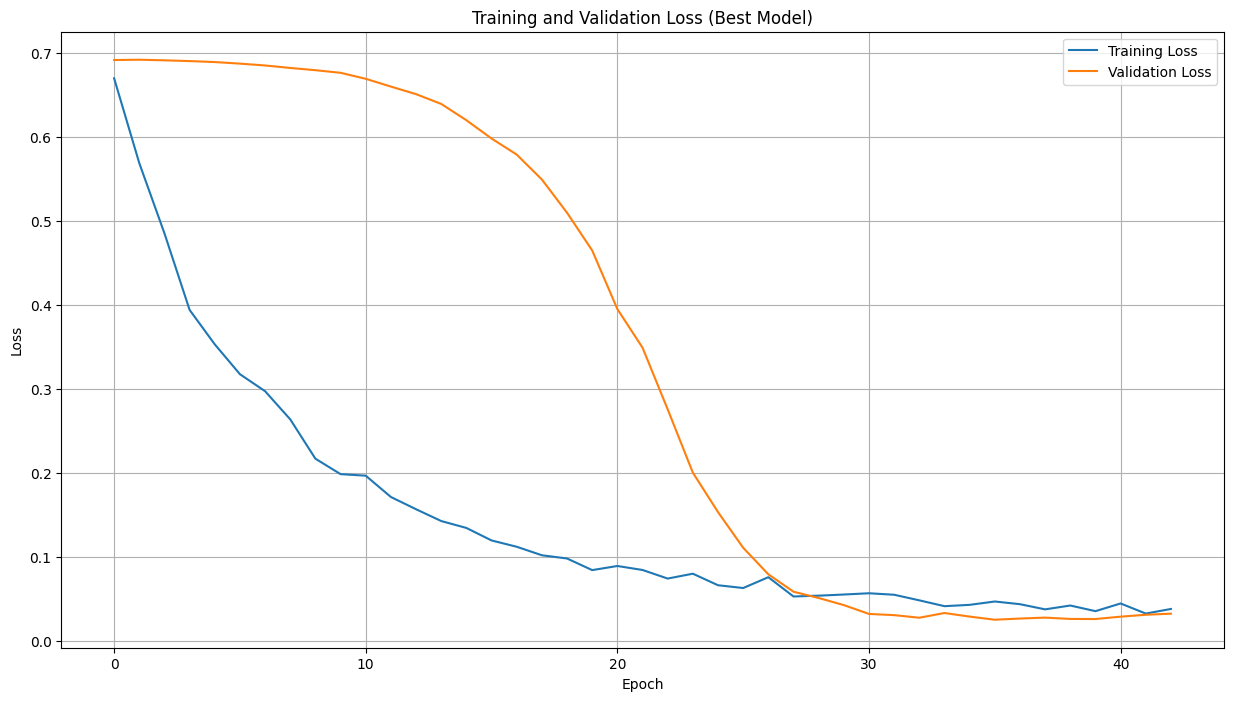

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau




def create_data_loaders(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray,
                        y_train: np.ndarray, y_val: np.ndarray, y_test: np.ndarray,
                        batch_size: int = BATCH_SIZE) -> Tuple[DataLoader, DataLoader, DataLoader]:
    #Create PyTorch DataLoaders for training, validation, and testing.
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Ensure input is 3D for LSTM: [batch, seq_len, input_size]
    if X_train_tensor.dim() == 2:
        X_train_tensor = X_train_tensor.unsqueeze(1)
    if X_val_tensor.dim() == 2:
        X_val_tensor = X_val_tensor.unsqueeze(1)
    if X_test_tensor.dim() == 2:
        X_test_tensor = X_test_tensor.unsqueeze(1)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader




def train_model_with_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                                 param_grid: Dict, n_epochs: int = N_EPOCHS) -> Tuple[Dict, List[Dict]]:
    #Perform grid search to find optimal hyperparameters.
    # Create data loaders
    train_loader, val_loader, _ = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

    # Initialize tracking variables
    best_val_loss = float('inf')
    best_params = None
    results = []

    # Grid search
    for params in tqdm(ParameterGrid(param_grid)):
        # Model initialization
        model = FaceSTRNN(
            input_size=X_train.shape[1],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            num_classes=2,
            dropout=params['dropout']
        ).to(DEVICE)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            verbose=True
        )

        # Initialize trainer 
        trainer = FaceSTRNNTrainer(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE
        )

        # Train model 
        train_losses, val_losses = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs
        )

        # Record results
        final_val_loss = val_losses[-1]
        results.append({
            'params': params,
            'final_val_loss': final_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

        # Update best parameters
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params

    return best_params, results




# Train model with grid search
best_params, results = train_model_with_grid_search(X_train, y_train, X_val, y_val, PARAM_GRID)

# Print best parameters
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
# print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training curves for best model
plt.figure(figsize=FIGURE_SIZE)
best_result = min(results, key=lambda x: x['final_val_loss'])
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Figure size 1500x800 with 0 Axes>

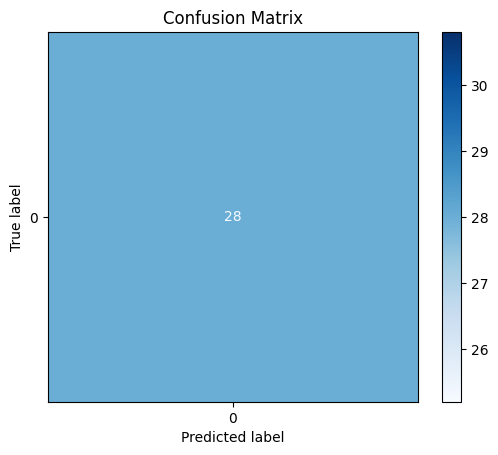

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    #Evaluate the model on the test set.
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs, _, _ = model(X)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


# Create test loader
_, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# Initialize best model
best_model = FaceSTRNN(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    num_classes=2,
    dropout=best_params['dropout']
).to(DEVICE)

# Evaluate model
y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=FIGURE_SIZE)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [ ]:
# Save the model and scaler
from training.trainer import save_model

# add PARAM_GRID["num_classes"] to best_params for easy initialization during multimodal
best_params['num_classes'] = 2 
save_model(best_model, scaler, X_train.shape[1], best_params, "face_model.pth")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
